# EEGNet

This notebook provides a modified reimplementation of the popular CNN-based EEG classifier: EEGNet by [Lawhern et al](http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta).
Most modifications include parameter changes to make it better suited for short-length windows as the original paper used input over 2 seconds long.
The knowledge and utilities obtained from experimental notebooks six and seven are used throughout this notebook.

This notebook works in an offline fashion and uses epochs with a length of 3 seconds.
This epoch starts 1 second before the visual queue was given, includes the 1 second the visual queue was shown and ends 1 second after the visual queue was hidden, totalling 3 seconds.
Baseline correction was done on the first second of the epoch, meaning the second before the visual queue was shown.
The effective training and testing are done in a half-second window, starting 0.1 seconds after the start of the visual queue.
A window of 0.5 seconds was chosen as it is a common size for sliding window approaches in online systems.


Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
   - Checking TensorFlow support
- Same subject, same session
- Same subject, new session
- New subject
- Cleaning residual notebook variables

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# allow reloading of libraries
import importlib

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset
import TF_tools
importlib.reload(CLA_dataset)
importlib.reload(TF_tools)

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

# EEGNet model
import EEGModels
from EEGModels import EEGNet

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")
import copy

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr>

### Checking TensorFlow support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

To launch the tensorboard use the following command in the `paper-notebooks` folder, be sure to have the right environments active:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

In [4]:
TF_tools.check_tf_cpu_gpu_presence()

There are 1 CPUs available under the names:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


There are 1 GPUs available under the names:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr><hr>

## Same subject, same session

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model provided through the `EEGModels.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
      - We trained for 2500 epochs, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We first use CV validation for testing on the training set and then use the test split for final validation.

In [5]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = True # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 100, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 8, # number of temporal filters. (default: 8)
        F2 = 16, # number of pointwise filters. (default: 16)
        D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/4/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook4_eegnet_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 2500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_model


####################################################
# TRAINING FOR SUBJECT B
####################################################

Shape of all data (epochs, channels, samples): (960, 21, 100)
Shape of train data (epochs, channels, samples): (768, 21, 100)
Shape of test data (epochs, channels, samples): (192, 21, 100)
Epoch 1/2500
5/5 [==============================] - ETA: 0s - loss: 1.2065 - accuracy: 0.3142
Epoch 1: val_loss improved from inf to 1.10002, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.32812, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 3s 124ms/step - loss: 1.2065 - accuracy: 0.3142 - val_loss: 1.1000 - val_accuracy: 0.3281
Epoch 2/2500
5/5 [==============================] - ETA: 0s - loss: 1.0948 - accuracy: 0.3542
Epoch 2: val_loss improved from 1.10002 to 1.09519,

Epoch 17/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.9540 - accuracy: 0.5859
Epoch 17: val_loss improved from 1.03257 to 1.02634, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 17: val_accuracy improved from 0.55729 to 0.58854, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 43ms/step - loss: 0.9847 - accuracy: 0.5434 - val_loss: 1.0263 - val_accuracy: 0.5885
Epoch 18/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.9625 - accuracy: 0.5547
Epoch 18: val_loss improved from 1.02634 to 1.02002, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 18: val_accuracy did not improve from 0.58854
5/5 [==============================] - 0s 31ms/step - loss: 0.9650 - accuracy: 0.5503 - val_loss: 1.0200 - val_accuracy: 0.5833
Epoch 19/2500
1/5 [=====>

Epoch 33/2500
5/5 [==============================] - ETA: 0s - loss: 0.8688 - accuracy: 0.6285
Epoch 33: val_loss improved from 0.92447 to 0.91900, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 33: val_accuracy improved from 0.73438 to 0.73958, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 49ms/step - loss: 0.8688 - accuracy: 0.6285 - val_loss: 0.9190 - val_accuracy: 0.7396
Epoch 34/2500
3/5 [=================>............] - ETA: 0s - loss: 0.8556 - accuracy: 0.6120
Epoch 34: val_loss improved from 0.91900 to 0.91424, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 34: val_accuracy did not improve from 0.73958
5/5 [==============================] - 0s 40ms/step - loss: 0.8514 - accuracy: 0.6337 - val_loss: 0.9142 - val_accuracy: 0.7396
Epoch 35/2500
1/5 [=====>

1/5 [=====>........................] - ETA: 0s - loss: 0.8393 - accuracy: 0.6328
Epoch 51: val_loss improved from 0.83740 to 0.83154, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 51: val_accuracy did not improve from 0.75000
5/5 [==============================] - 0s 30ms/step - loss: 0.7980 - accuracy: 0.6875 - val_loss: 0.8315 - val_accuracy: 0.7240
Epoch 52/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.8156 - accuracy: 0.6719
Epoch 52: val_loss improved from 0.83154 to 0.82602, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 52: val_accuracy did not improve from 0.75000
5/5 [==============================] - 0s 29ms/step - loss: 0.8134 - accuracy: 0.6615 - val_loss: 0.8260 - val_accuracy: 0.7188
Epoch 53/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.7982 - accuracy: 0.6328
Epoch 53: val_loss improved from 0.82602 to 0.82262, 

Epoch 70/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.8095 - accuracy: 0.7031
Epoch 70: val_loss improved from 0.76398 to 0.75768, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 70: val_accuracy did not improve from 0.75000
5/5 [==============================] - 0s 30ms/step - loss: 0.7831 - accuracy: 0.6979 - val_loss: 0.7577 - val_accuracy: 0.7292
Epoch 71/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.7507 - accuracy: 0.7031
Epoch 71: val_loss improved from 0.75768 to 0.75401, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 71: val_accuracy did not improve from 0.75000
5/5 [==============================] - 0s 29ms/step - loss: 0.7591 - accuracy: 0.6997 - val_loss: 0.7540 - val_accuracy: 0.7344
Epoch 72/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.7970 - accuracy: 0.6953
Epoch 72: val_loss improved from 0.7540


Epoch 88: val_accuracy did not improve from 0.76562
5/5 [==============================] - 0s 30ms/step - loss: 0.7193 - accuracy: 0.7205 - val_loss: 0.7079 - val_accuracy: 0.7396
Epoch 89/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6788 - accuracy: 0.7656
Epoch 89: val_loss improved from 0.70793 to 0.70505, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 89: val_accuracy did not improve from 0.76562
5/5 [==============================] - 0s 28ms/step - loss: 0.7422 - accuracy: 0.7309 - val_loss: 0.7051 - val_accuracy: 0.7500
Epoch 90/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.7366 - accuracy: 0.7246
Epoch 90: val_loss improved from 0.70505 to 0.70235, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 90: val_accuracy did not improve from 0.76562
5/5 [==============================] - 0s 34ms/step - loss: 0.7367 - accuracy: 0.

1/5 [=====>........................] - ETA: 0s - loss: 0.7154 - accuracy: 0.7266
Epoch 108: val_loss did not improve from 0.67801

Epoch 108: val_accuracy did not improve from 0.77083
5/5 [==============================] - 0s 20ms/step - loss: 0.7212 - accuracy: 0.7188 - val_loss: 0.6794 - val_accuracy: 0.7604
Epoch 109/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6613 - accuracy: 0.7734
Epoch 109: val_loss did not improve from 0.67801

Epoch 109: val_accuracy did not improve from 0.77083
5/5 [==============================] - 0s 20ms/step - loss: 0.6955 - accuracy: 0.7378 - val_loss: 0.6800 - val_accuracy: 0.7656
Epoch 110/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.7336 - accuracy: 0.6719
Epoch 110: val_loss did not improve from 0.67801

Epoch 110: val_accuracy did not improve from 0.77083
5/5 [==============================] - 0s 19ms/step - loss: 0.6924 - accuracy: 0.7309 - val_loss: 0.6812 - val_accuracy: 0.7604
Epoch 111/2500
1/5 [=====>........

1/5 [=====>........................] - ETA: 0s - loss: 0.6584 - accuracy: 0.7500
Epoch 129: val_loss did not improve from 0.65414

Epoch 129: val_accuracy did not improve from 0.78125
5/5 [==============================] - 0s 20ms/step - loss: 0.6918 - accuracy: 0.7274 - val_loss: 0.6544 - val_accuracy: 0.7604
Epoch 130/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.7297 - accuracy: 0.7578
Epoch 130: val_loss did not improve from 0.65414

Epoch 130: val_accuracy did not improve from 0.78125
5/5 [==============================] - 0s 20ms/step - loss: 0.6896 - accuracy: 0.7483 - val_loss: 0.6542 - val_accuracy: 0.7604
Epoch 131/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6893 - accuracy: 0.7266
Epoch 131: val_loss did not improve from 0.65414

Epoch 131: val_accuracy did not improve from 0.78125
5/5 [==============================] - 0s 20ms/step - loss: 0.6896 - accuracy: 0.7274 - val_loss: 0.6555 - val_accuracy: 0.7604
Epoch 132/2500
1/5 [=====>........


Epoch 150: val_accuracy did not improve from 0.78125
5/5 [==============================] - 0s 20ms/step - loss: 0.6660 - accuracy: 0.7535 - val_loss: 0.6422 - val_accuracy: 0.7604
Epoch 151/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.7202 - accuracy: 0.7344
Epoch 151: val_loss improved from 0.63979 to 0.63858, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 151: val_accuracy did not improve from 0.78125
5/5 [==============================] - 0s 31ms/step - loss: 0.6677 - accuracy: 0.7500 - val_loss: 0.6386 - val_accuracy: 0.7708
Epoch 152/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6381 - accuracy: 0.7969
Epoch 152: val_loss improved from 0.63858 to 0.63600, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 152: val_accuracy did not improve from 0.78125
5/5 [==============================] - 0s 32ms/step - loss: 0.6485 - accur

Epoch 172/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6603 - accuracy: 0.7109
Epoch 172: val_loss did not improve from 0.62001

Epoch 172: val_accuracy did not improve from 0.78646
5/5 [==============================] - 0s 20ms/step - loss: 0.6375 - accuracy: 0.7483 - val_loss: 0.6233 - val_accuracy: 0.7656
Epoch 173/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6061 - accuracy: 0.7812
Epoch 173: val_loss did not improve from 0.62001

Epoch 173: val_accuracy did not improve from 0.78646
5/5 [==============================] - 0s 20ms/step - loss: 0.6534 - accuracy: 0.7483 - val_loss: 0.6233 - val_accuracy: 0.7708
Epoch 174/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6163 - accuracy: 0.8047
Epoch 174: val_loss did not improve from 0.62001

Epoch 174: val_accuracy did not improve from 0.78646
5/5 [==============================] - 0s 20ms/step - loss: 0.6581 - accuracy: 0.7604 - val_loss: 0.6233 - val_accuracy: 0.7760
Epoch 175/2500
1/5 


Epoch 194: val_accuracy did not improve from 0.79167
5/5 [==============================] - 0s 20ms/step - loss: 0.6169 - accuracy: 0.7726 - val_loss: 0.6140 - val_accuracy: 0.7760
Epoch 195/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6858 - accuracy: 0.7422
Epoch 195: val_loss did not improve from 0.60510

Epoch 195: val_accuracy did not improve from 0.79167
5/5 [==============================] - 0s 20ms/step - loss: 0.6179 - accuracy: 0.7778 - val_loss: 0.6110 - val_accuracy: 0.7760
Epoch 196/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6369 - accuracy: 0.7422
Epoch 196: val_loss did not improve from 0.60510

Epoch 196: val_accuracy did not improve from 0.79167
5/5 [==============================] - 0s 20ms/step - loss: 0.6359 - accuracy: 0.7483 - val_loss: 0.6107 - val_accuracy: 0.7812
Epoch 197/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5651 - accuracy: 0.7734
Epoch 197: val_loss did not improve from 0.60510

Epoch 197: val_acc

5/5 [==============================] - 0s 31ms/step - loss: 0.6613 - accuracy: 0.7309 - val_loss: 0.5981 - val_accuracy: 0.7865
Epoch 218/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6217 - accuracy: 0.7812
Epoch 218: val_loss did not improve from 0.59805

Epoch 218: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 21ms/step - loss: 0.6086 - accuracy: 0.7743 - val_loss: 0.6008 - val_accuracy: 0.7865
Epoch 219/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6217 - accuracy: 0.7891
Epoch 219: val_loss did not improve from 0.59805

Epoch 219: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 21ms/step - loss: 0.6198 - accuracy: 0.7812 - val_loss: 0.6011 - val_accuracy: 0.7865
Epoch 220/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6650 - accuracy: 0.7578
Epoch 220: val_loss improved from 0.59805 to 0.59748, saving model to saved_variables/4/samesubject_samesession/subjectB\t


Epoch 240: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.5927 - accuracy: 0.7743 - val_loss: 0.5935 - val_accuracy: 0.7760
Epoch 241/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5447 - accuracy: 0.8203
Epoch 241: val_loss did not improve from 0.58868

Epoch 241: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 22ms/step - loss: 0.6305 - accuracy: 0.7465 - val_loss: 0.5910 - val_accuracy: 0.7708
Epoch 242/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5936 - accuracy: 0.7734
Epoch 242: val_loss did not improve from 0.58868

Epoch 242: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 22ms/step - loss: 0.6106 - accuracy: 0.7656 - val_loss: 0.5902 - val_accuracy: 0.7656
Epoch 243/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6577 - accuracy: 0.7422
Epoch 243: val_loss did not improve from 0.58868

Epoch 243: val_acc

5/5 [==============================] - 0s 40ms/step - loss: 0.6080 - accuracy: 0.7604 - val_loss: 0.5835 - val_accuracy: 0.7917
Epoch 265/2500
5/5 [==============================] - ETA: 0s - loss: 0.6062 - accuracy: 0.7587
Epoch 265: val_loss improved from 0.58354 to 0.57848, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 265: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 32ms/step - loss: 0.6062 - accuracy: 0.7587 - val_loss: 0.5785 - val_accuracy: 0.7917
Epoch 266/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5744 - accuracy: 0.8125
Epoch 266: val_loss did not improve from 0.57848

Epoch 266: val_accuracy improved from 0.80208 to 0.81250, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 29ms/step - loss: 0.6048 - accuracy: 0.7778 - val_loss: 0.5799 - val_accuracy: 0.8125


Epoch 288/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5881 - accuracy: 0.7500
Epoch 288: val_loss did not improve from 0.56841

Epoch 288: val_accuracy did not improve from 0.81250
5/5 [==============================] - 0s 20ms/step - loss: 0.6025 - accuracy: 0.7500 - val_loss: 0.5687 - val_accuracy: 0.7865
Epoch 289/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5313 - accuracy: 0.7812
Epoch 289: val_loss did not improve from 0.56841

Epoch 289: val_accuracy did not improve from 0.81250
5/5 [==============================] - 0s 19ms/step - loss: 0.5698 - accuracy: 0.7830 - val_loss: 0.5688 - val_accuracy: 0.7969
Epoch 290/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5385 - accuracy: 0.8125
Epoch 290: val_loss did not improve from 0.56841

Epoch 290: val_accuracy did not improve from 0.81250
5/5 [==============================] - 0s 20ms/step - loss: 0.5797 - accuracy: 0.7830 - val_loss: 0.5722 - val_accuracy: 0.7917
Epoch 291/2500
1/5 

Epoch 313/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5986 - accuracy: 0.7734
Epoch 313: val_loss improved from 0.56838 to 0.56710, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 313: val_accuracy did not improve from 0.81250
5/5 [==============================] - 0s 29ms/step - loss: 0.5822 - accuracy: 0.7760 - val_loss: 0.5671 - val_accuracy: 0.7969
Epoch 314/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6004 - accuracy: 0.7812
Epoch 314: val_loss improved from 0.56710 to 0.56214, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 314: val_accuracy did not improve from 0.81250
5/5 [==============================] - 0s 28ms/step - loss: 0.5939 - accuracy: 0.7847 - val_loss: 0.5621 - val_accuracy: 0.7917
Epoch 315/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6312 - accuracy: 0.7656
Epoch 315: val_loss improved fro


Epoch 336: val_accuracy did not improve from 0.81771
5/5 [==============================] - 0s 19ms/step - loss: 0.5769 - accuracy: 0.7743 - val_loss: 0.5727 - val_accuracy: 0.7969
Epoch 337/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5933 - accuracy: 0.7500
Epoch 337: val_loss did not improve from 0.55571

Epoch 337: val_accuracy did not improve from 0.81771
5/5 [==============================] - 0s 21ms/step - loss: 0.5998 - accuracy: 0.7639 - val_loss: 0.5764 - val_accuracy: 0.8125
Epoch 338/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6203 - accuracy: 0.7500
Epoch 338: val_loss did not improve from 0.55571

Epoch 338: val_accuracy did not improve from 0.81771
5/5 [==============================] - 0s 22ms/step - loss: 0.5836 - accuracy: 0.7795 - val_loss: 0.5768 - val_accuracy: 0.8021
Epoch 339/2500
5/5 [==============================] - ETA: 0s - loss: 0.5820 - accuracy: 0.7622
Epoch 339: val_loss did not improve from 0.55571

Epoch 339: val_acc

5/5 [==============================] - 0s 19ms/step - loss: 0.5883 - accuracy: 0.7882 - val_loss: 0.5569 - val_accuracy: 0.8073
Epoch 361/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4900 - accuracy: 0.8125
Epoch 361: val_loss did not improve from 0.55247

Epoch 361: val_accuracy did not improve from 0.81771
5/5 [==============================] - 0s 20ms/step - loss: 0.5877 - accuracy: 0.7760 - val_loss: 0.5562 - val_accuracy: 0.8021
Epoch 362/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5614 - accuracy: 0.8125
Epoch 362: val_loss did not improve from 0.55247

Epoch 362: val_accuracy did not improve from 0.81771
5/5 [==============================] - 0s 19ms/step - loss: 0.5783 - accuracy: 0.7708 - val_loss: 0.5551 - val_accuracy: 0.7969
Epoch 363/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5584 - accuracy: 0.8125
Epoch 363: val_loss did not improve from 0.55247

Epoch 363: val_accuracy did not improve from 0.81771
5/5 [==============

Epoch 385/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6523 - accuracy: 0.7266
Epoch 385: val_loss did not improve from 0.55105

Epoch 385: val_accuracy did not improve from 0.81771
5/5 [==============================] - 0s 19ms/step - loss: 0.5706 - accuracy: 0.7830 - val_loss: 0.5592 - val_accuracy: 0.7917
Epoch 386/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5643 - accuracy: 0.7812
Epoch 386: val_loss did not improve from 0.55105

Epoch 386: val_accuracy did not improve from 0.81771
5/5 [==============================] - 0s 20ms/step - loss: 0.5797 - accuracy: 0.7708 - val_loss: 0.5542 - val_accuracy: 0.7969
Epoch 387/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5743 - accuracy: 0.7891
Epoch 387: val_loss improved from 0.55105 to 0.54815, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 387: val_accuracy did not improve from 0.81771
5/5 [==============================] -

Epoch 408/2500
5/5 [==============================] - ETA: 0s - loss: 0.5655 - accuracy: 0.7951
Epoch 408: val_loss did not improve from 0.53755

Epoch 408: val_accuracy did not improve from 0.82292
5/5 [==============================] - 0s 38ms/step - loss: 0.5655 - accuracy: 0.7951 - val_loss: 0.5427 - val_accuracy: 0.8021
Epoch 409/2500
5/5 [==============================] - ETA: 0s - loss: 0.5685 - accuracy: 0.7760
Epoch 409: val_loss did not improve from 0.53755

Epoch 409: val_accuracy did not improve from 0.82292
5/5 [==============================] - 0s 26ms/step - loss: 0.5685 - accuracy: 0.7760 - val_loss: 0.5422 - val_accuracy: 0.7969
Epoch 410/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5798 - accuracy: 0.7734
Epoch 410: val_loss did not improve from 0.53755

Epoch 410: val_accuracy did not improve from 0.82292
5/5 [==============================] - 0s 20ms/step - loss: 0.5681 - accuracy: 0.7639 - val_loss: 0.5434 - val_accuracy: 0.8021
Epoch 411/2500
1/5 

Epoch 433/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5813 - accuracy: 0.7656
Epoch 433: val_loss did not improve from 0.53739

Epoch 433: val_accuracy did not improve from 0.82292
5/5 [==============================] - 0s 18ms/step - loss: 0.5749 - accuracy: 0.7830 - val_loss: 0.5535 - val_accuracy: 0.7969
Epoch 434/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5493 - accuracy: 0.8438
Epoch 434: val_loss did not improve from 0.53739

Epoch 434: val_accuracy did not improve from 0.82292
5/5 [==============================] - 0s 19ms/step - loss: 0.5554 - accuracy: 0.8194 - val_loss: 0.5458 - val_accuracy: 0.8021
Epoch 435/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5939 - accuracy: 0.7422
Epoch 435: val_loss did not improve from 0.53739

Epoch 435: val_accuracy did not improve from 0.82292
5/5 [==============================] - 0s 19ms/step - loss: 0.5440 - accuracy: 0.7934 - val_loss: 0.5376 - val_accuracy: 0.8021
Epoch 436/2500
1/5 


Epoch 457: val_accuracy did not improve from 0.82292
5/5 [==============================] - 0s 19ms/step - loss: 0.5578 - accuracy: 0.7951 - val_loss: 0.5389 - val_accuracy: 0.7969
Epoch 458/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4713 - accuracy: 0.8125
Epoch 458: val_loss did not improve from 0.52667

Epoch 458: val_accuracy did not improve from 0.82292
5/5 [==============================] - 0s 20ms/step - loss: 0.5257 - accuracy: 0.7882 - val_loss: 0.5350 - val_accuracy: 0.8021
Epoch 459/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5274 - accuracy: 0.8281
Epoch 459: val_loss did not improve from 0.52667

Epoch 459: val_accuracy did not improve from 0.82292
5/5 [==============================] - 0s 21ms/step - loss: 0.5450 - accuracy: 0.7882 - val_loss: 0.5349 - val_accuracy: 0.8021
Epoch 460/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.5520 - accuracy: 0.8066
Epoch 460: val_loss did not improve from 0.52667

Epoch 460: val_acc

1/5 [=====>........................] - ETA: 0s - loss: 0.5831 - accuracy: 0.7812
Epoch 482: val_loss did not improve from 0.52667

Epoch 482: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 23ms/step - loss: 0.5743 - accuracy: 0.7795 - val_loss: 0.5445 - val_accuracy: 0.8073
Epoch 483/2500
5/5 [==============================] - ETA: 0s - loss: 0.5655 - accuracy: 0.7535
Epoch 483: val_loss did not improve from 0.52667

Epoch 483: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 37ms/step - loss: 0.5655 - accuracy: 0.7535 - val_loss: 0.5416 - val_accuracy: 0.8073
Epoch 484/2500
5/5 [==============================] - ETA: 0s - loss: 0.5554 - accuracy: 0.7639
Epoch 484: val_loss did not improve from 0.52667

Epoch 484: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 29ms/step - loss: 0.5554 - accuracy: 0.7639 - val_loss: 0.5402 - val_accuracy: 0.8073
Epoch 485/2500
5/5 [==============


Epoch 506: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.5544 - accuracy: 0.8056 - val_loss: 0.5351 - val_accuracy: 0.8021
Epoch 507/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5355 - accuracy: 0.8125
Epoch 507: val_loss did not improve from 0.52479

Epoch 507: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5354 - accuracy: 0.7778 - val_loss: 0.5368 - val_accuracy: 0.8073
Epoch 508/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5103 - accuracy: 0.7891
Epoch 508: val_loss did not improve from 0.52479

Epoch 508: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5199 - accuracy: 0.7951 - val_loss: 0.5343 - val_accuracy: 0.8073
Epoch 509/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5762 - accuracy: 0.7266
Epoch 509: val_loss did not improve from 0.52479

Epoch 509: val_acc

5/5 [==============================] - 0s 20ms/step - loss: 0.5629 - accuracy: 0.7656 - val_loss: 0.5316 - val_accuracy: 0.8125
Epoch 532/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5410 - accuracy: 0.7891
Epoch 532: val_loss did not improve from 0.52479

Epoch 532: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5513 - accuracy: 0.7830 - val_loss: 0.5340 - val_accuracy: 0.8073
Epoch 533/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5326 - accuracy: 0.8125
Epoch 533: val_loss did not improve from 0.52479

Epoch 533: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5536 - accuracy: 0.7708 - val_loss: 0.5346 - val_accuracy: 0.7969
Epoch 534/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5345 - accuracy: 0.8125
Epoch 534: val_loss did not improve from 0.52479

Epoch 534: val_accuracy did not improve from 0.82812
5/5 [==============

Epoch 556/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5988 - accuracy: 0.7344
Epoch 556: val_loss did not improve from 0.52098

Epoch 556: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 28ms/step - loss: 0.5502 - accuracy: 0.7917 - val_loss: 0.5233 - val_accuracy: 0.7969
Epoch 557/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5854 - accuracy: 0.7734
Epoch 557: val_loss did not improve from 0.52098

Epoch 557: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5381 - accuracy: 0.7743 - val_loss: 0.5229 - val_accuracy: 0.7969
Epoch 558/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5512 - accuracy: 0.7812
Epoch 558: val_loss did not improve from 0.52098

Epoch 558: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5310 - accuracy: 0.7899 - val_loss: 0.5246 - val_accuracy: 0.7969
Epoch 559/2500
1/5 

1/5 [=====>........................] - ETA: 0s - loss: 0.6021 - accuracy: 0.7578
Epoch 580: val_loss did not improve from 0.51357

Epoch 580: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.5744 - accuracy: 0.7865 - val_loss: 0.5241 - val_accuracy: 0.7969
Epoch 581/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5674 - accuracy: 0.7656
Epoch 581: val_loss did not improve from 0.51357

Epoch 581: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5391 - accuracy: 0.7812 - val_loss: 0.5220 - val_accuracy: 0.7969
Epoch 582/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5727 - accuracy: 0.7734
Epoch 582: val_loss did not improve from 0.51357

Epoch 582: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5305 - accuracy: 0.7986 - val_loss: 0.5251 - val_accuracy: 0.8073
Epoch 583/2500
1/5 [=====>........

Epoch 605/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5124 - accuracy: 0.8047
Epoch 605: val_loss did not improve from 0.51296

Epoch 605: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5396 - accuracy: 0.7865 - val_loss: 0.5312 - val_accuracy: 0.8073
Epoch 606/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6630 - accuracy: 0.7109
Epoch 606: val_loss did not improve from 0.51296

Epoch 606: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5659 - accuracy: 0.7708 - val_loss: 0.5311 - val_accuracy: 0.8125
Epoch 607/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5420 - accuracy: 0.7734
Epoch 607: val_loss did not improve from 0.51296

Epoch 607: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.5120 - accuracy: 0.8021 - val_loss: 0.5307 - val_accuracy: 0.8073
Epoch 608/2500
1/5 

1/5 [=====>........................] - ETA: 0s - loss: 0.5305 - accuracy: 0.7734
Epoch 630: val_loss did not improve from 0.51296

Epoch 630: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 24ms/step - loss: 0.5237 - accuracy: 0.7986 - val_loss: 0.5284 - val_accuracy: 0.7969
Epoch 631/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4869 - accuracy: 0.8203
Epoch 631: val_loss did not improve from 0.51296

Epoch 631: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5231 - accuracy: 0.7830 - val_loss: 0.5321 - val_accuracy: 0.7865
Epoch 632/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4993 - accuracy: 0.7812
Epoch 632: val_loss did not improve from 0.51296

Epoch 632: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.5215 - accuracy: 0.8021 - val_loss: 0.5381 - val_accuracy: 0.7969
Epoch 633/2500
1/5 [=====>........

Epoch 655/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5053 - accuracy: 0.8125
Epoch 655: val_loss did not improve from 0.51076

Epoch 655: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5127 - accuracy: 0.8108 - val_loss: 0.5164 - val_accuracy: 0.7865
Epoch 656/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5039 - accuracy: 0.8047
Epoch 656: val_loss did not improve from 0.51076

Epoch 656: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5164 - accuracy: 0.8108 - val_loss: 0.5167 - val_accuracy: 0.7865
Epoch 657/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5408 - accuracy: 0.8047
Epoch 657: val_loss did not improve from 0.51076

Epoch 657: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.5441 - accuracy: 0.7917 - val_loss: 0.5175 - val_accuracy: 0.7812
Epoch 658/2500
1/5 

Epoch 680/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5335 - accuracy: 0.7656
Epoch 680: val_loss did not improve from 0.50706

Epoch 680: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.5306 - accuracy: 0.7917 - val_loss: 0.5240 - val_accuracy: 0.8073
Epoch 681/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6372 - accuracy: 0.7266
Epoch 681: val_loss did not improve from 0.50706

Epoch 681: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.5378 - accuracy: 0.7778 - val_loss: 0.5248 - val_accuracy: 0.8021
Epoch 682/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5685 - accuracy: 0.7812
Epoch 682: val_loss did not improve from 0.50706

Epoch 682: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.4912 - accuracy: 0.8003 - val_loss: 0.5257 - val_accuracy: 0.8021
Epoch 683/2500
1/5 


Epoch 704: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5484 - accuracy: 0.7830 - val_loss: 0.5192 - val_accuracy: 0.8177
Epoch 705/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4231 - accuracy: 0.8594
Epoch 705: val_loss did not improve from 0.50290

Epoch 705: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 21ms/step - loss: 0.5029 - accuracy: 0.8090 - val_loss: 0.5202 - val_accuracy: 0.8281
Epoch 706/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4300 - accuracy: 0.8828
Epoch 706: val_loss did not improve from 0.50290

Epoch 706: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.5156 - accuracy: 0.8038 - val_loss: 0.5161 - val_accuracy: 0.8229
Epoch 707/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5364 - accuracy: 0.8281
Epoch 707: val_loss did not improve from 0.50290

Epoch 707: val_acc

1/5 [=====>........................] - ETA: 0s - loss: 0.5514 - accuracy: 0.7969
Epoch 729: val_loss did not improve from 0.50109

Epoch 729: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 21ms/step - loss: 0.4976 - accuracy: 0.8299 - val_loss: 0.5157 - val_accuracy: 0.8177
Epoch 730/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4594 - accuracy: 0.8203
Epoch 730: val_loss did not improve from 0.50109

Epoch 730: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5081 - accuracy: 0.7830 - val_loss: 0.5111 - val_accuracy: 0.8073
Epoch 731/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5648 - accuracy: 0.7656
Epoch 731: val_loss did not improve from 0.50109

Epoch 731: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.4953 - accuracy: 0.8108 - val_loss: 0.5114 - val_accuracy: 0.8021
Epoch 732/2500
1/5 [=====>........

1/5 [=====>........................] - ETA: 0s - loss: 0.5531 - accuracy: 0.7891
Epoch 754: val_loss did not improve from 0.50109

Epoch 754: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5384 - accuracy: 0.7899 - val_loss: 0.5170 - val_accuracy: 0.7865
Epoch 755/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4315 - accuracy: 0.8281
Epoch 755: val_loss did not improve from 0.50109

Epoch 755: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5158 - accuracy: 0.7830 - val_loss: 0.5189 - val_accuracy: 0.7812
Epoch 756/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4992 - accuracy: 0.7656
Epoch 756: val_loss did not improve from 0.50109

Epoch 756: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 41ms/step - loss: 0.5168 - accuracy: 0.7865 - val_loss: 0.5240 - val_accuracy: 0.7812
Epoch 757/2500
1/5 [=====>........

1/5 [=====>........................] - ETA: 0s - loss: 0.5350 - accuracy: 0.7891
Epoch 778: val_loss did not improve from 0.49690

Epoch 778: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5134 - accuracy: 0.8038 - val_loss: 0.5075 - val_accuracy: 0.8125
Epoch 779/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4155 - accuracy: 0.8828
Epoch 779: val_loss did not improve from 0.49690

Epoch 779: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.5014 - accuracy: 0.8125 - val_loss: 0.5045 - val_accuracy: 0.8073
Epoch 780/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5631 - accuracy: 0.7891
Epoch 780: val_loss did not improve from 0.49690

Epoch 780: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.5163 - accuracy: 0.7917 - val_loss: 0.5056 - val_accuracy: 0.8073
Epoch 781/2500
1/5 [=====>........

1/5 [=====>........................] - ETA: 0s - loss: 0.4468 - accuracy: 0.8281
Epoch 803: val_loss did not improve from 0.49690

Epoch 803: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4992 - accuracy: 0.8073 - val_loss: 0.5204 - val_accuracy: 0.7917
Epoch 804/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5005 - accuracy: 0.8281
Epoch 804: val_loss did not improve from 0.49690

Epoch 804: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5425 - accuracy: 0.7830 - val_loss: 0.5230 - val_accuracy: 0.7917
Epoch 805/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4235 - accuracy: 0.8594
Epoch 805: val_loss did not improve from 0.49690

Epoch 805: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5020 - accuracy: 0.8038 - val_loss: 0.5269 - val_accuracy: 0.7812
Epoch 806/2500
1/5 [=====>........

1/5 [=====>........................] - ETA: 0s - loss: 0.5405 - accuracy: 0.8047
Epoch 828: val_loss improved from 0.49690 to 0.49510, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 828: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 29ms/step - loss: 0.5236 - accuracy: 0.7795 - val_loss: 0.4951 - val_accuracy: 0.8073
Epoch 829/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4693 - accuracy: 0.8281
Epoch 829: val_loss improved from 0.49510 to 0.49142, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 829: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 52ms/step - loss: 0.4961 - accuracy: 0.8021 - val_loss: 0.4914 - val_accuracy: 0.8073
Epoch 830/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5926 - accuracy: 0.7578
Epoch 830: val_loss did not improve from 0.4914


Epoch 852: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5145 - accuracy: 0.7917 - val_loss: 0.5183 - val_accuracy: 0.7865
Epoch 853/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5290 - accuracy: 0.8047
Epoch 853: val_loss did not improve from 0.49142

Epoch 853: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5065 - accuracy: 0.8038 - val_loss: 0.5194 - val_accuracy: 0.7708
Epoch 854/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5805 - accuracy: 0.7734
Epoch 854: val_loss did not improve from 0.49142

Epoch 854: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 21ms/step - loss: 0.4864 - accuracy: 0.8299 - val_loss: 0.5179 - val_accuracy: 0.7812
Epoch 855/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5286 - accuracy: 0.7812
Epoch 855: val_loss did not improve from 0.49142

Epoch 855: val_acc

5/5 [==============================] - 0s 20ms/step - loss: 0.4762 - accuracy: 0.8299 - val_loss: 0.5085 - val_accuracy: 0.7969
Epoch 878/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4694 - accuracy: 0.7812
Epoch 878: val_loss did not improve from 0.49142

Epoch 878: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.4954 - accuracy: 0.8142 - val_loss: 0.5076 - val_accuracy: 0.7917
Epoch 879/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5174 - accuracy: 0.7656
Epoch 879: val_loss did not improve from 0.49142

Epoch 879: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.4681 - accuracy: 0.8090 - val_loss: 0.5044 - val_accuracy: 0.8073
Epoch 880/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5560 - accuracy: 0.7578
Epoch 880: val_loss did not improve from 0.49142

Epoch 880: val_accuracy did not improve from 0.82812
5/5 [==============

Epoch 903/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5155 - accuracy: 0.7812
Epoch 903: val_loss did not improve from 0.49142

Epoch 903: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4907 - accuracy: 0.8125 - val_loss: 0.5092 - val_accuracy: 0.7969
Epoch 904/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5054 - accuracy: 0.7969
Epoch 904: val_loss did not improve from 0.49142

Epoch 904: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5000 - accuracy: 0.8194 - val_loss: 0.5108 - val_accuracy: 0.7917
Epoch 905/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4900 - accuracy: 0.7969
Epoch 905: val_loss did not improve from 0.49142

Epoch 905: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.4870 - accuracy: 0.8038 - val_loss: 0.5156 - val_accuracy: 0.7917
Epoch 906/2500
1/5 

1/5 [=====>........................] - ETA: 0s - loss: 0.4842 - accuracy: 0.8359
Epoch 927: val_loss did not improve from 0.48730

Epoch 927: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5118 - accuracy: 0.7917 - val_loss: 0.5087 - val_accuracy: 0.8073
Epoch 928/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4822 - accuracy: 0.8125
Epoch 928: val_loss did not improve from 0.48730

Epoch 928: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.4973 - accuracy: 0.7951 - val_loss: 0.5084 - val_accuracy: 0.8021
Epoch 929/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4699 - accuracy: 0.8594
Epoch 929: val_loss did not improve from 0.48730

Epoch 929: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.5096 - accuracy: 0.8090 - val_loss: 0.5069 - val_accuracy: 0.8073
Epoch 930/2500
1/5 [=====>........

1/5 [=====>........................] - ETA: 0s - loss: 0.4567 - accuracy: 0.8281
Epoch 952: val_loss did not improve from 0.48730

Epoch 952: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4936 - accuracy: 0.8038 - val_loss: 0.5049 - val_accuracy: 0.8229
Epoch 953/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5743 - accuracy: 0.7734
Epoch 953: val_loss did not improve from 0.48730

Epoch 953: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5111 - accuracy: 0.7969 - val_loss: 0.5063 - val_accuracy: 0.7969
Epoch 954/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4649 - accuracy: 0.8281
Epoch 954: val_loss did not improve from 0.48730

Epoch 954: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.5197 - accuracy: 0.7882 - val_loss: 0.5053 - val_accuracy: 0.7917
Epoch 955/2500
1/5 [=====>........

Epoch 977/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4648 - accuracy: 0.8281
Epoch 977: val_loss did not improve from 0.48583

Epoch 977: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4959 - accuracy: 0.8038 - val_loss: 0.5185 - val_accuracy: 0.7969
Epoch 978/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4979 - accuracy: 0.7969
Epoch 978: val_loss did not improve from 0.48583

Epoch 978: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4715 - accuracy: 0.8316 - val_loss: 0.5163 - val_accuracy: 0.8073
Epoch 979/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5157 - accuracy: 0.7969
Epoch 979: val_loss did not improve from 0.48583

Epoch 979: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5096 - accuracy: 0.7917 - val_loss: 0.5151 - val_accuracy: 0.7917
Epoch 980/2500
1/5 

1/5 [=====>........................] - ETA: 0s - loss: 0.4774 - accuracy: 0.8438
Epoch 1002: val_loss did not improve from 0.48583

Epoch 1002: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4715 - accuracy: 0.8333 - val_loss: 0.5126 - val_accuracy: 0.7969
Epoch 1003/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4503 - accuracy: 0.8438
Epoch 1003: val_loss did not improve from 0.48583

Epoch 1003: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.4896 - accuracy: 0.7951 - val_loss: 0.5174 - val_accuracy: 0.7865
Epoch 1004/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4611 - accuracy: 0.8047
Epoch 1004: val_loss did not improve from 0.48583

Epoch 1004: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.4657 - accuracy: 0.8142 - val_loss: 0.5195 - val_accuracy: 0.7865
Epoch 1005/2500
1/5 [=====

Epoch 1027/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4911 - accuracy: 0.7969
Epoch 1027: val_loss did not improve from 0.48583

Epoch 1027: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4813 - accuracy: 0.7969 - val_loss: 0.5094 - val_accuracy: 0.7865
Epoch 1028/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4972 - accuracy: 0.8047
Epoch 1028: val_loss did not improve from 0.48583

Epoch 1028: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 21ms/step - loss: 0.4808 - accuracy: 0.8021 - val_loss: 0.5117 - val_accuracy: 0.8021
Epoch 1029/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5108 - accuracy: 0.8047
Epoch 1029: val_loss did not improve from 0.48583

Epoch 1029: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.4845 - accuracy: 0.8194 - val_loss: 0.5097 - val_accuracy: 0.8021
Epoch 1030

5/5 [==============================] - 0s 19ms/step - loss: 0.4926 - accuracy: 0.8056 - val_loss: 0.4862 - val_accuracy: 0.8125
Epoch 1052/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5292 - accuracy: 0.8125
Epoch 1052: val_loss did not improve from 0.48336

Epoch 1052: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5069 - accuracy: 0.7951 - val_loss: 0.5050 - val_accuracy: 0.8073
Epoch 1053/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5043 - accuracy: 0.7500
Epoch 1053: val_loss did not improve from 0.48336

Epoch 1053: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.5010 - accuracy: 0.7934 - val_loss: 0.5079 - val_accuracy: 0.8021
Epoch 1054/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5006 - accuracy: 0.7969
Epoch 1054: val_loss did not improve from 0.48336

Epoch 1054: val_accuracy did not improve from 0.82812
5/5 [=====


Epoch 1076: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.4823 - accuracy: 0.8177 - val_loss: 0.5091 - val_accuracy: 0.7917
Epoch 1077/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5230 - accuracy: 0.7734
Epoch 1077: val_loss did not improve from 0.48336

Epoch 1077: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.4658 - accuracy: 0.8194 - val_loss: 0.5071 - val_accuracy: 0.7865
Epoch 1078/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4787 - accuracy: 0.8125
Epoch 1078: val_loss did not improve from 0.48336

Epoch 1078: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4987 - accuracy: 0.7969 - val_loss: 0.5040 - val_accuracy: 0.7969
Epoch 1079/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4655 - accuracy: 0.8125
Epoch 1079: val_loss did not improve from 0.48336

Epoch 107

1/5 [=====>........................] - ETA: 0s - loss: 0.4810 - accuracy: 0.7891
Epoch 1101: val_loss did not improve from 0.48336

Epoch 1101: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.4632 - accuracy: 0.7969 - val_loss: 0.4936 - val_accuracy: 0.8125
Epoch 1102/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4636 - accuracy: 0.8359
Epoch 1102: val_loss did not improve from 0.48336

Epoch 1102: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.4793 - accuracy: 0.8090 - val_loss: 0.4982 - val_accuracy: 0.8177
Epoch 1103/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5034 - accuracy: 0.8047
Epoch 1103: val_loss did not improve from 0.48336

Epoch 1103: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.4669 - accuracy: 0.8090 - val_loss: 0.5049 - val_accuracy: 0.8021
Epoch 1104/2500
1/5 [=====

Epoch 1126/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5399 - accuracy: 0.7656
Epoch 1126: val_loss did not improve from 0.48336

Epoch 1126: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4780 - accuracy: 0.8073 - val_loss: 0.5062 - val_accuracy: 0.7917
Epoch 1127/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5261 - accuracy: 0.8359
Epoch 1127: val_loss did not improve from 0.48336

Epoch 1127: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4625 - accuracy: 0.8403 - val_loss: 0.5030 - val_accuracy: 0.7865
Epoch 1128/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4554 - accuracy: 0.8125
Epoch 1128: val_loss did not improve from 0.48336

Epoch 1128: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4933 - accuracy: 0.7934 - val_loss: 0.5044 - val_accuracy: 0.7865
Epoch 1129

Epoch 1151/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4998 - accuracy: 0.7500
Epoch 1151: val_loss did not improve from 0.48336

Epoch 1151: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4810 - accuracy: 0.7951 - val_loss: 0.5033 - val_accuracy: 0.8021
Epoch 1152/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4671 - accuracy: 0.8047
Epoch 1152: val_loss did not improve from 0.48336

Epoch 1152: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4797 - accuracy: 0.8194 - val_loss: 0.4997 - val_accuracy: 0.8125
Epoch 1153/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4663 - accuracy: 0.7969
Epoch 1153: val_loss did not improve from 0.48336

Epoch 1153: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.5033 - accuracy: 0.7847 - val_loss: 0.4961 - val_accuracy: 0.8125
Epoch 1154

Epoch 1176/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4772 - accuracy: 0.8125
Epoch 1176: val_loss did not improve from 0.48336

Epoch 1176: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.4570 - accuracy: 0.8333 - val_loss: 0.5066 - val_accuracy: 0.8177
Epoch 1177/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4479 - accuracy: 0.8203
Epoch 1177: val_loss did not improve from 0.48336

Epoch 1177: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4695 - accuracy: 0.8177 - val_loss: 0.5250 - val_accuracy: 0.8073
Epoch 1178/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5078 - accuracy: 0.7891
Epoch 1178: val_loss did not improve from 0.48336

Epoch 1178: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4797 - accuracy: 0.8125 - val_loss: 0.5210 - val_accuracy: 0.8073
Epoch 1179

Epoch 1201/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4437 - accuracy: 0.8359
Epoch 1201: val_loss did not improve from 0.48336

Epoch 1201: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.4548 - accuracy: 0.8281 - val_loss: 0.5049 - val_accuracy: 0.8281
Epoch 1202/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4762 - accuracy: 0.7969
Epoch 1202: val_loss did not improve from 0.48336

Epoch 1202: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4702 - accuracy: 0.8229 - val_loss: 0.5088 - val_accuracy: 0.8281
Epoch 1203/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5492 - accuracy: 0.7266
Epoch 1203: val_loss did not improve from 0.48336

Epoch 1203: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.4840 - accuracy: 0.8003 - val_loss: 0.5116 - val_accuracy: 0.8229
Epoch 1204

Epoch 1226/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5390 - accuracy: 0.7969
Epoch 1226: val_loss did not improve from 0.48336

Epoch 1226: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4715 - accuracy: 0.8229 - val_loss: 0.5071 - val_accuracy: 0.8125
Epoch 1227/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3834 - accuracy: 0.8906
Epoch 1227: val_loss did not improve from 0.48336

Epoch 1227: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4740 - accuracy: 0.8142 - val_loss: 0.5107 - val_accuracy: 0.7969
Epoch 1228/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5360 - accuracy: 0.7578
Epoch 1228: val_loss did not improve from 0.48336

Epoch 1228: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4560 - accuracy: 0.8160 - val_loss: 0.5111 - val_accuracy: 0.7917
Epoch 1229

Epoch 1251/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4622 - accuracy: 0.8203
Epoch 1251: val_loss did not improve from 0.48336

Epoch 1251: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 21ms/step - loss: 0.4465 - accuracy: 0.8281 - val_loss: 0.4987 - val_accuracy: 0.7969
Epoch 1252/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5048 - accuracy: 0.8047
Epoch 1252: val_loss did not improve from 0.48336

Epoch 1252: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 20ms/step - loss: 0.4921 - accuracy: 0.8056 - val_loss: 0.4995 - val_accuracy: 0.8073
Epoch 1253/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4503 - accuracy: 0.7969
Epoch 1253: val_loss did not improve from 0.48336

Epoch 1253: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 19ms/step - loss: 0.4480 - accuracy: 0.8212 - val_loss: 0.4988 - val_accuracy: 0.8125
Epoch 1254

5/5 [==============================] - 0s 23ms/step - loss: 0.4799 - accuracy: 0.8073 - val_loss: 0.4997 - val_accuracy: 0.8021
Epoch 1276/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4942 - accuracy: 0.8203
Epoch 1276: val_loss did not improve from 0.48336

Epoch 1276: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4737 - accuracy: 0.8090 - val_loss: 0.5076 - val_accuracy: 0.8021
Epoch 1277/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4363 - accuracy: 0.8438
Epoch 1277: val_loss did not improve from 0.48336

Epoch 1277: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4596 - accuracy: 0.8264 - val_loss: 0.5083 - val_accuracy: 0.7917
Epoch 1278/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4695 - accuracy: 0.7969
Epoch 1278: val_loss did not improve from 0.48336

Epoch 1278: val_accuracy did not improve from 0.83333
5/5 [=====


Epoch 1300: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4879 - accuracy: 0.7986 - val_loss: 0.5092 - val_accuracy: 0.8125
Epoch 1301/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4828 - accuracy: 0.8203
Epoch 1301: val_loss did not improve from 0.48336

Epoch 1301: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4469 - accuracy: 0.8212 - val_loss: 0.5053 - val_accuracy: 0.8281
Epoch 1302/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5621 - accuracy: 0.7734
Epoch 1302: val_loss did not improve from 0.48336

Epoch 1302: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 21ms/step - loss: 0.4676 - accuracy: 0.8038 - val_loss: 0.4992 - val_accuracy: 0.8125
Epoch 1303/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4445 - accuracy: 0.8750
Epoch 1303: val_loss did not improve from 0.48336

Epoch 130

1/5 [=====>........................] - ETA: 0s - loss: 0.4113 - accuracy: 0.8516
Epoch 1325: val_loss did not improve from 0.48336

Epoch 1325: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4409 - accuracy: 0.8316 - val_loss: 0.5119 - val_accuracy: 0.7917
Epoch 1326/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4257 - accuracy: 0.8359
Epoch 1326: val_loss did not improve from 0.48336

Epoch 1326: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 21ms/step - loss: 0.4539 - accuracy: 0.8229 - val_loss: 0.5058 - val_accuracy: 0.7865
Epoch 1327/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4852 - accuracy: 0.8203
Epoch 1327: val_loss did not improve from 0.48336

Epoch 1327: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4927 - accuracy: 0.7934 - val_loss: 0.5095 - val_accuracy: 0.7865
Epoch 1328/2500
1/5 [=====

Epoch 1350/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.4244 - accuracy: 0.8477
Epoch 1350: val_loss did not improve from 0.48336

Epoch 1350: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 42ms/step - loss: 0.4271 - accuracy: 0.8455 - val_loss: 0.5034 - val_accuracy: 0.7969
Epoch 1351/2500
5/5 [==============================] - ETA: 0s - loss: 0.4534 - accuracy: 0.8264
Epoch 1351: val_loss did not improve from 0.48336

Epoch 1351: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 24ms/step - loss: 0.4534 - accuracy: 0.8264 - val_loss: 0.4966 - val_accuracy: 0.7917
Epoch 1352/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4855 - accuracy: 0.8047
Epoch 1352: val_loss did not improve from 0.48336

Epoch 1352: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4448 - accuracy: 0.8316 - val_loss: 0.4947 - val_accuracy: 0.8021
Epoch 1353

Epoch 1375/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4854 - accuracy: 0.8516
Epoch 1375: val_loss did not improve from 0.48336

Epoch 1375: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4660 - accuracy: 0.8264 - val_loss: 0.4973 - val_accuracy: 0.8177
Epoch 1376/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4245 - accuracy: 0.8516
Epoch 1376: val_loss did not improve from 0.48336

Epoch 1376: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4357 - accuracy: 0.8264 - val_loss: 0.4981 - val_accuracy: 0.8073
Epoch 1377/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3569 - accuracy: 0.8984
Epoch 1377: val_loss did not improve from 0.48336

Epoch 1377: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4195 - accuracy: 0.8385 - val_loss: 0.4979 - val_accuracy: 0.8073
Epoch 1378

5/5 [==============================] - 0s 23ms/step - loss: 0.4542 - accuracy: 0.8142 - val_loss: 0.4992 - val_accuracy: 0.7917
Epoch 1400/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4858 - accuracy: 0.7734
Epoch 1400: val_loss did not improve from 0.48169

Epoch 1400: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 22ms/step - loss: 0.4582 - accuracy: 0.8003 - val_loss: 0.5007 - val_accuracy: 0.8021
Epoch 1401/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4496 - accuracy: 0.7578
Epoch 1401: val_loss did not improve from 0.48169

Epoch 1401: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 21ms/step - loss: 0.4719 - accuracy: 0.8073 - val_loss: 0.5070 - val_accuracy: 0.7917
Epoch 1402/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4853 - accuracy: 0.7969
Epoch 1402: val_loss did not improve from 0.48169

Epoch 1402: val_accuracy did not improve from 0.83333
5/5 [=====


Epoch 1424: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 21ms/step - loss: 0.4607 - accuracy: 0.8160 - val_loss: 0.5116 - val_accuracy: 0.8125
Epoch 1425/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5433 - accuracy: 0.8125
Epoch 1425: val_loss did not improve from 0.48169

Epoch 1425: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4962 - accuracy: 0.8021 - val_loss: 0.5110 - val_accuracy: 0.7917
Epoch 1426/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3707 - accuracy: 0.8438
Epoch 1426: val_loss did not improve from 0.48169

Epoch 1426: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 21ms/step - loss: 0.4291 - accuracy: 0.8368 - val_loss: 0.5054 - val_accuracy: 0.7917
Epoch 1427/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4366 - accuracy: 0.7891
Epoch 1427: val_loss did not improve from 0.48169

Epoch 142

1/5 [=====>........................] - ETA: 0s - loss: 0.4321 - accuracy: 0.8516
Epoch 1449: val_loss did not improve from 0.48169

Epoch 1449: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4907 - accuracy: 0.8142 - val_loss: 0.4958 - val_accuracy: 0.7969
Epoch 1450/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3989 - accuracy: 0.8438
Epoch 1450: val_loss did not improve from 0.48169

Epoch 1450: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4509 - accuracy: 0.8125 - val_loss: 0.5045 - val_accuracy: 0.7917
Epoch 1451/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4680 - accuracy: 0.7969
Epoch 1451: val_loss did not improve from 0.48169

Epoch 1451: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4753 - accuracy: 0.8177 - val_loss: 0.5056 - val_accuracy: 0.7917
Epoch 1452/2500
1/5 [=====

Epoch 1474/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4415 - accuracy: 0.8594
Epoch 1474: val_loss did not improve from 0.48169

Epoch 1474: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4531 - accuracy: 0.8420 - val_loss: 0.4985 - val_accuracy: 0.7969
Epoch 1475/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3708 - accuracy: 0.8750
Epoch 1475: val_loss did not improve from 0.48169

Epoch 1475: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4399 - accuracy: 0.8212 - val_loss: 0.4979 - val_accuracy: 0.7969
Epoch 1476/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4510 - accuracy: 0.8125
Epoch 1476: val_loss did not improve from 0.48169

Epoch 1476: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4696 - accuracy: 0.8038 - val_loss: 0.4948 - val_accuracy: 0.7969
Epoch 1477

Epoch 1499/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5021 - accuracy: 0.7891
Epoch 1499: val_loss did not improve from 0.48169

Epoch 1499: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4593 - accuracy: 0.8229 - val_loss: 0.4830 - val_accuracy: 0.7917
Epoch 1500/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4876 - accuracy: 0.8281
Epoch 1500: val_loss improved from 0.48169 to 0.47710, saving model to saved_variables/4/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1500: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 29ms/step - loss: 0.4772 - accuracy: 0.8125 - val_loss: 0.4771 - val_accuracy: 0.7969
Epoch 1501/2500
5/5 [==============================] - ETA: 0s - loss: 0.4488 - accuracy: 0.8108
Epoch 1501: val_loss did not improve from 0.47710

Epoch 1501: val_accuracy did not improve from 0.83333
5/5 [========================

5/5 [==============================] - 0s 20ms/step - loss: 0.4448 - accuracy: 0.8299 - val_loss: 0.5147 - val_accuracy: 0.7708
Epoch 1524/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4566 - accuracy: 0.8203
Epoch 1524: val_loss did not improve from 0.47710

Epoch 1524: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4285 - accuracy: 0.8351 - val_loss: 0.5071 - val_accuracy: 0.7812
Epoch 1525/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4748 - accuracy: 0.8125
Epoch 1525: val_loss did not improve from 0.47710

Epoch 1525: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4956 - accuracy: 0.7969 - val_loss: 0.4982 - val_accuracy: 0.7865
Epoch 1526/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4081 - accuracy: 0.8359
Epoch 1526: val_loss did not improve from 0.47710

Epoch 1526: val_accuracy did not improve from 0.83333
5/5 [=====


Epoch 1548: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4535 - accuracy: 0.8160 - val_loss: 0.5175 - val_accuracy: 0.7917
Epoch 1549/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4433 - accuracy: 0.8281
Epoch 1549: val_loss did not improve from 0.47710

Epoch 1549: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4197 - accuracy: 0.8385 - val_loss: 0.5207 - val_accuracy: 0.7917
Epoch 1550/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4096 - accuracy: 0.8281
Epoch 1550: val_loss did not improve from 0.47710

Epoch 1550: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4640 - accuracy: 0.8368 - val_loss: 0.5084 - val_accuracy: 0.7865
Epoch 1551/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4942 - accuracy: 0.7969
Epoch 1551: val_loss did not improve from 0.47710

Epoch 155

Epoch 1573/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4525 - accuracy: 0.8203
Epoch 1573: val_loss did not improve from 0.47569

Epoch 1573: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4294 - accuracy: 0.8385 - val_loss: 0.4949 - val_accuracy: 0.7812
Epoch 1574/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3950 - accuracy: 0.8203
Epoch 1574: val_loss did not improve from 0.47569

Epoch 1574: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4311 - accuracy: 0.8264 - val_loss: 0.4960 - val_accuracy: 0.7760
Epoch 1575/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5022 - accuracy: 0.7891
Epoch 1575: val_loss did not improve from 0.47569

Epoch 1575: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 21ms/step - loss: 0.4426 - accuracy: 0.8299 - val_loss: 0.4979 - val_accuracy: 0.7812
Epoch 1576

Epoch 1598/2500
5/5 [==============================] - ETA: 0s - loss: 0.4599 - accuracy: 0.8177
Epoch 1598: val_loss did not improve from 0.47569

Epoch 1598: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 25ms/step - loss: 0.4599 - accuracy: 0.8177 - val_loss: 0.5067 - val_accuracy: 0.7969
Epoch 1599/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.4378 - accuracy: 0.8438
Epoch 1599: val_loss did not improve from 0.47569

Epoch 1599: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 29ms/step - loss: 0.4367 - accuracy: 0.8420 - val_loss: 0.5197 - val_accuracy: 0.7917
Epoch 1600/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4066 - accuracy: 0.8203
Epoch 1600: val_loss did not improve from 0.47569

Epoch 1600: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4641 - accuracy: 0.7934 - val_loss: 0.5171 - val_accuracy: 0.7969
Epoch 1601

Epoch 1623/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5107 - accuracy: 0.7969
Epoch 1623: val_loss did not improve from 0.47569

Epoch 1623: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4460 - accuracy: 0.8368 - val_loss: 0.4929 - val_accuracy: 0.7812
Epoch 1624/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5369 - accuracy: 0.7734
Epoch 1624: val_loss did not improve from 0.47569

Epoch 1624: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4606 - accuracy: 0.8194 - val_loss: 0.5129 - val_accuracy: 0.7917
Epoch 1625/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3912 - accuracy: 0.8594
Epoch 1625: val_loss did not improve from 0.47569

Epoch 1625: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4167 - accuracy: 0.8351 - val_loss: 0.5170 - val_accuracy: 0.7917
Epoch 1626

Epoch 1648/2500
3/5 [=================>............] - ETA: 0s - loss: 0.3939 - accuracy: 0.8411
Epoch 1648: val_loss did not improve from 0.47569

Epoch 1648: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 40ms/step - loss: 0.4094 - accuracy: 0.8385 - val_loss: 0.4827 - val_accuracy: 0.7969
Epoch 1649/2500
5/5 [==============================] - ETA: 0s - loss: 0.4395 - accuracy: 0.8142
Epoch 1649: val_loss did not improve from 0.47569

Epoch 1649: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 26ms/step - loss: 0.4395 - accuracy: 0.8142 - val_loss: 0.4920 - val_accuracy: 0.8021
Epoch 1650/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.4341 - accuracy: 0.8398
Epoch 1650: val_loss did not improve from 0.47569

Epoch 1650: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 25ms/step - loss: 0.4312 - accuracy: 0.8403 - val_loss: 0.4985 - val_accuracy: 0.7969
Epoch 1651

Epoch 1673/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5138 - accuracy: 0.7500
Epoch 1673: val_loss did not improve from 0.47569

Epoch 1673: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4452 - accuracy: 0.8108 - val_loss: 0.4890 - val_accuracy: 0.8073
Epoch 1674/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4478 - accuracy: 0.8438
Epoch 1674: val_loss did not improve from 0.47569

Epoch 1674: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 23ms/step - loss: 0.4523 - accuracy: 0.8333 - val_loss: 0.4923 - val_accuracy: 0.7969
Epoch 1675/2500
5/5 [==============================] - ETA: 0s - loss: 0.4317 - accuracy: 0.8247
Epoch 1675: val_loss did not improve from 0.47569

Epoch 1675: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 24ms/step - loss: 0.4317 - accuracy: 0.8247 - val_loss: 0.4981 - val_accuracy: 0.7917
Epoch 1676

Epoch 1698/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3671 - accuracy: 0.8984
Epoch 1698: val_loss did not improve from 0.47569

Epoch 1698: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4513 - accuracy: 0.8351 - val_loss: 0.4894 - val_accuracy: 0.8021
Epoch 1699/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4146 - accuracy: 0.8594
Epoch 1699: val_loss did not improve from 0.47569

Epoch 1699: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4112 - accuracy: 0.8351 - val_loss: 0.5032 - val_accuracy: 0.7917
Epoch 1700/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4359 - accuracy: 0.7969
Epoch 1700: val_loss did not improve from 0.47569

Epoch 1700: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 21ms/step - loss: 0.4607 - accuracy: 0.7969 - val_loss: 0.5094 - val_accuracy: 0.7865
Epoch 1701

Epoch 1723/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4603 - accuracy: 0.8125
Epoch 1723: val_loss did not improve from 0.47569

Epoch 1723: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 21ms/step - loss: 0.4580 - accuracy: 0.8108 - val_loss: 0.5091 - val_accuracy: 0.7917
Epoch 1724/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4273 - accuracy: 0.8281
Epoch 1724: val_loss did not improve from 0.47569

Epoch 1724: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 21ms/step - loss: 0.4236 - accuracy: 0.8333 - val_loss: 0.4934 - val_accuracy: 0.7917
Epoch 1725/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4784 - accuracy: 0.7969
Epoch 1725: val_loss did not improve from 0.47569

Epoch 1725: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4649 - accuracy: 0.8125 - val_loss: 0.4912 - val_accuracy: 0.7917
Epoch 1726

Epoch 1748/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3889 - accuracy: 0.8203
Epoch 1748: val_loss did not improve from 0.47569

Epoch 1748: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4120 - accuracy: 0.8368 - val_loss: 0.4861 - val_accuracy: 0.8073
Epoch 1749/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4421 - accuracy: 0.8359
Epoch 1749: val_loss did not improve from 0.47569

Epoch 1749: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4357 - accuracy: 0.8212 - val_loss: 0.5040 - val_accuracy: 0.7917
Epoch 1750/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5058 - accuracy: 0.7969
Epoch 1750: val_loss did not improve from 0.47569

Epoch 1750: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 21ms/step - loss: 0.4293 - accuracy: 0.8385 - val_loss: 0.5129 - val_accuracy: 0.7865
Epoch 1751

Epoch 1773/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4241 - accuracy: 0.8125
Epoch 1773: val_loss did not improve from 0.47569

Epoch 1773: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4017 - accuracy: 0.8403 - val_loss: 0.5013 - val_accuracy: 0.7917
Epoch 1774/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3123 - accuracy: 0.9062
Epoch 1774: val_loss did not improve from 0.47569

Epoch 1774: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4277 - accuracy: 0.8177 - val_loss: 0.4995 - val_accuracy: 0.7969
Epoch 1775/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4679 - accuracy: 0.8125
Epoch 1775: val_loss did not improve from 0.47569

Epoch 1775: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 21ms/step - loss: 0.4050 - accuracy: 0.8542 - val_loss: 0.5010 - val_accuracy: 0.7917
Epoch 1776

Epoch 1798/2500
5/5 [==============================] - ETA: 0s - loss: 0.4588 - accuracy: 0.8212
Epoch 1798: val_loss did not improve from 0.47569

Epoch 1798: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 23ms/step - loss: 0.4588 - accuracy: 0.8212 - val_loss: 0.5125 - val_accuracy: 0.7812
Epoch 1799/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4575 - accuracy: 0.8672
Epoch 1799: val_loss did not improve from 0.47569

Epoch 1799: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 22ms/step - loss: 0.4543 - accuracy: 0.8264 - val_loss: 0.5260 - val_accuracy: 0.7969
Epoch 1800/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3309 - accuracy: 0.8828
Epoch 1800: val_loss did not improve from 0.47569

Epoch 1800: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 21ms/step - loss: 0.4201 - accuracy: 0.8455 - val_loss: 0.5249 - val_accuracy: 0.7865
Epoch 1801

Epoch 1823/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3859 - accuracy: 0.8516
Epoch 1823: val_loss did not improve from 0.47569

Epoch 1823: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 28ms/step - loss: 0.3951 - accuracy: 0.8490 - val_loss: 0.5102 - val_accuracy: 0.8073
Epoch 1824/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.4396 - accuracy: 0.8438
Epoch 1824: val_loss did not improve from 0.47569

Epoch 1824: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 28ms/step - loss: 0.4261 - accuracy: 0.8507 - val_loss: 0.5143 - val_accuracy: 0.7969
Epoch 1825/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4630 - accuracy: 0.8359
Epoch 1825: val_loss did not improve from 0.47569

Epoch 1825: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4645 - accuracy: 0.8194 - val_loss: 0.5064 - val_accuracy: 0.7969
Epoch 1826

Epoch 1848/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4106 - accuracy: 0.8516
Epoch 1848: val_loss did not improve from 0.47569

Epoch 1848: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 22ms/step - loss: 0.4264 - accuracy: 0.8247 - val_loss: 0.5067 - val_accuracy: 0.8021
Epoch 1849/2500
5/5 [==============================] - ETA: 0s - loss: 0.4364 - accuracy: 0.8316
Epoch 1849: val_loss did not improve from 0.47569

Epoch 1849: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 23ms/step - loss: 0.4364 - accuracy: 0.8316 - val_loss: 0.5031 - val_accuracy: 0.8021
Epoch 1850/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3985 - accuracy: 0.8359
Epoch 1850: val_loss did not improve from 0.47569

Epoch 1850: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.3862 - accuracy: 0.8628 - val_loss: 0.4922 - val_accuracy: 0.7917
Epoch 1851

Epoch 1873/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.4299 - accuracy: 0.8398
Epoch 1873: val_loss did not improve from 0.47569

Epoch 1873: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 26ms/step - loss: 0.4319 - accuracy: 0.8316 - val_loss: 0.5095 - val_accuracy: 0.7917
Epoch 1874/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4828 - accuracy: 0.7812
Epoch 1874: val_loss did not improve from 0.47569

Epoch 1874: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4447 - accuracy: 0.8403 - val_loss: 0.4999 - val_accuracy: 0.7917
Epoch 1875/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3736 - accuracy: 0.8438
Epoch 1875: val_loss did not improve from 0.47569

Epoch 1875: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4404 - accuracy: 0.8299 - val_loss: 0.4923 - val_accuracy: 0.7865
Epoch 1876

Epoch 1898/2500
5/5 [==============================] - ETA: 0s - loss: 0.4048 - accuracy: 0.8403
Epoch 1898: val_loss did not improve from 0.47569

Epoch 1898: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 24ms/step - loss: 0.4048 - accuracy: 0.8403 - val_loss: 0.5045 - val_accuracy: 0.7969
Epoch 1899/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4624 - accuracy: 0.8359
Epoch 1899: val_loss did not improve from 0.47569

Epoch 1899: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4551 - accuracy: 0.8316 - val_loss: 0.5152 - val_accuracy: 0.7760
Epoch 1900/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4221 - accuracy: 0.8203
Epoch 1900: val_loss did not improve from 0.47569

Epoch 1900: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4617 - accuracy: 0.8229 - val_loss: 0.5293 - val_accuracy: 0.7812
Epoch 1901

Epoch 1923/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4111 - accuracy: 0.8359
Epoch 1923: val_loss did not improve from 0.47569

Epoch 1923: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4051 - accuracy: 0.8385 - val_loss: 0.4973 - val_accuracy: 0.7917
Epoch 1924/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4212 - accuracy: 0.8359
Epoch 1924: val_loss did not improve from 0.47569

Epoch 1924: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 18ms/step - loss: 0.4358 - accuracy: 0.8420 - val_loss: 0.4891 - val_accuracy: 0.8021
Epoch 1925/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5592 - accuracy: 0.7578
Epoch 1925: val_loss did not improve from 0.47569

Epoch 1925: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4515 - accuracy: 0.8125 - val_loss: 0.4955 - val_accuracy: 0.7917
Epoch 1926

Epoch 1948/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4372 - accuracy: 0.8594
Epoch 1948: val_loss did not improve from 0.47569

Epoch 1948: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4375 - accuracy: 0.8316 - val_loss: 0.4884 - val_accuracy: 0.8021
Epoch 1949/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5476 - accuracy: 0.7031
Epoch 1949: val_loss did not improve from 0.47569

Epoch 1949: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4465 - accuracy: 0.8229 - val_loss: 0.4975 - val_accuracy: 0.8021
Epoch 1950/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4086 - accuracy: 0.8359
Epoch 1950: val_loss did not improve from 0.47569

Epoch 1950: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4286 - accuracy: 0.8264 - val_loss: 0.5074 - val_accuracy: 0.8073
Epoch 1951

5/5 [==============================] - 0s 20ms/step - loss: 0.4549 - accuracy: 0.8073 - val_loss: 0.5172 - val_accuracy: 0.7917
Epoch 1973/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4128 - accuracy: 0.8438
Epoch 1973: val_loss did not improve from 0.47466

Epoch 1973: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4270 - accuracy: 0.8368 - val_loss: 0.5181 - val_accuracy: 0.7917
Epoch 1974/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4200 - accuracy: 0.8750
Epoch 1974: val_loss did not improve from 0.47466

Epoch 1974: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.3911 - accuracy: 0.8611 - val_loss: 0.5173 - val_accuracy: 0.7917
Epoch 1975/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4155 - accuracy: 0.8281
Epoch 1975: val_loss did not improve from 0.47466

Epoch 1975: val_accuracy did not improve from 0.83333
5/5 [=====


Epoch 1997: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 23ms/step - loss: 0.4589 - accuracy: 0.8247 - val_loss: 0.5065 - val_accuracy: 0.7865
Epoch 1998/2500
5/5 [==============================] - ETA: 0s - loss: 0.4266 - accuracy: 0.8316
Epoch 1998: val_loss did not improve from 0.47466

Epoch 1998: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 26ms/step - loss: 0.4266 - accuracy: 0.8316 - val_loss: 0.5099 - val_accuracy: 0.7865
Epoch 1999/2500
2/5 [===========>..................] - ETA: 0s - loss: 0.4125 - accuracy: 0.8359
Epoch 1999: val_loss did not improve from 0.47466

Epoch 1999: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 44ms/step - loss: 0.4144 - accuracy: 0.8385 - val_loss: 0.5090 - val_accuracy: 0.7917
Epoch 2000/2500
5/5 [==============================] - ETA: 0s - loss: 0.4021 - accuracy: 0.8594
Epoch 2000: val_loss did not improve from 0.47466

Epoch 200

1/5 [=====>........................] - ETA: 0s - loss: 0.4461 - accuracy: 0.8516
Epoch 2022: val_loss did not improve from 0.47466

Epoch 2022: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4384 - accuracy: 0.8299 - val_loss: 0.4946 - val_accuracy: 0.7917
Epoch 2023/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4419 - accuracy: 0.8359
Epoch 2023: val_loss did not improve from 0.47466

Epoch 2023: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4338 - accuracy: 0.8247 - val_loss: 0.5009 - val_accuracy: 0.7865
Epoch 2024/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4186 - accuracy: 0.8438
Epoch 2024: val_loss did not improve from 0.47466

Epoch 2024: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4313 - accuracy: 0.8316 - val_loss: 0.5089 - val_accuracy: 0.7812
Epoch 2025/2500
1/5 [=====

Epoch 2047/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4371 - accuracy: 0.8438
Epoch 2047: val_loss did not improve from 0.47466

Epoch 2047: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4269 - accuracy: 0.8490 - val_loss: 0.5011 - val_accuracy: 0.7708
Epoch 2048/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4466 - accuracy: 0.8203
Epoch 2048: val_loss did not improve from 0.47466

Epoch 2048: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 27ms/step - loss: 0.4657 - accuracy: 0.8142 - val_loss: 0.5036 - val_accuracy: 0.7760
Epoch 2049/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3774 - accuracy: 0.8594
Epoch 2049: val_loss did not improve from 0.47466

Epoch 2049: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 26ms/step - loss: 0.3752 - accuracy: 0.8611 - val_loss: 0.4971 - val_accuracy: 0.7917
Epoch 2050

Epoch 2072/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4257 - accuracy: 0.8281
Epoch 2072: val_loss did not improve from 0.47466

Epoch 2072: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 21ms/step - loss: 0.3781 - accuracy: 0.8472 - val_loss: 0.5197 - val_accuracy: 0.7917
Epoch 2073/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3154 - accuracy: 0.9062
Epoch 2073: val_loss did not improve from 0.47466

Epoch 2073: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 21ms/step - loss: 0.4137 - accuracy: 0.8490 - val_loss: 0.5198 - val_accuracy: 0.7865
Epoch 2074/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4892 - accuracy: 0.8203
Epoch 2074: val_loss did not improve from 0.47466

Epoch 2074: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4392 - accuracy: 0.8247 - val_loss: 0.5149 - val_accuracy: 0.7865
Epoch 2075

Epoch 2097/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4045 - accuracy: 0.8047
Epoch 2097: val_loss did not improve from 0.47466

Epoch 2097: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.3928 - accuracy: 0.8351 - val_loss: 0.5042 - val_accuracy: 0.7760
Epoch 2098/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3822 - accuracy: 0.8828
Epoch 2098: val_loss did not improve from 0.47466

Epoch 2098: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.3999 - accuracy: 0.8507 - val_loss: 0.5021 - val_accuracy: 0.7760
Epoch 2099/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5235 - accuracy: 0.8047
Epoch 2099: val_loss did not improve from 0.47466

Epoch 2099: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4323 - accuracy: 0.8316 - val_loss: 0.5097 - val_accuracy: 0.7708
Epoch 2100

Epoch 2122/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4820 - accuracy: 0.8047
Epoch 2122: val_loss did not improve from 0.47466

Epoch 2122: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4090 - accuracy: 0.8316 - val_loss: 0.5200 - val_accuracy: 0.7917
Epoch 2123/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3606 - accuracy: 0.8594
Epoch 2123: val_loss did not improve from 0.47466

Epoch 2123: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4012 - accuracy: 0.8472 - val_loss: 0.5154 - val_accuracy: 0.7708
Epoch 2124/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3902 - accuracy: 0.8828
Epoch 2124: val_loss did not improve from 0.47466

Epoch 2124: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4105 - accuracy: 0.8542 - val_loss: 0.5225 - val_accuracy: 0.7708
Epoch 2125

Epoch 2147/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5308 - accuracy: 0.7969
Epoch 2147: val_loss did not improve from 0.47466

Epoch 2147: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4412 - accuracy: 0.8194 - val_loss: 0.5240 - val_accuracy: 0.7708
Epoch 2148/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4174 - accuracy: 0.8438
Epoch 2148: val_loss did not improve from 0.47466

Epoch 2148: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4193 - accuracy: 0.8455 - val_loss: 0.5140 - val_accuracy: 0.7656
Epoch 2149/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4525 - accuracy: 0.8281
Epoch 2149: val_loss did not improve from 0.47466

Epoch 2149: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4584 - accuracy: 0.8212 - val_loss: 0.5055 - val_accuracy: 0.7708
Epoch 2150

Epoch 2172/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5136 - accuracy: 0.7656
Epoch 2172: val_loss did not improve from 0.47466

Epoch 2172: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4314 - accuracy: 0.8403 - val_loss: 0.5247 - val_accuracy: 0.7865
Epoch 2173/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3376 - accuracy: 0.9062
Epoch 2173: val_loss did not improve from 0.47466

Epoch 2173: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4141 - accuracy: 0.8385 - val_loss: 0.5117 - val_accuracy: 0.7917
Epoch 2174/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4465 - accuracy: 0.8438
Epoch 2174: val_loss did not improve from 0.47466

Epoch 2174: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4431 - accuracy: 0.8316 - val_loss: 0.5082 - val_accuracy: 0.7812
Epoch 2175

Epoch 2197/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4136 - accuracy: 0.8359
Epoch 2197: val_loss did not improve from 0.47466

Epoch 2197: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4186 - accuracy: 0.8472 - val_loss: 0.5131 - val_accuracy: 0.7708
Epoch 2198/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3632 - accuracy: 0.8906
Epoch 2198: val_loss did not improve from 0.47466

Epoch 2198: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4085 - accuracy: 0.8507 - val_loss: 0.5176 - val_accuracy: 0.7812
Epoch 2199/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4020 - accuracy: 0.7969
Epoch 2199: val_loss did not improve from 0.47466

Epoch 2199: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4023 - accuracy: 0.8385 - val_loss: 0.5262 - val_accuracy: 0.7760
Epoch 2200

Epoch 2222/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3813 - accuracy: 0.8438
Epoch 2222: val_loss did not improve from 0.47466

Epoch 2222: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4236 - accuracy: 0.8455 - val_loss: 0.5201 - val_accuracy: 0.7917
Epoch 2223/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3452 - accuracy: 0.8516
Epoch 2223: val_loss did not improve from 0.47466

Epoch 2223: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.3777 - accuracy: 0.8559 - val_loss: 0.5279 - val_accuracy: 0.7917
Epoch 2224/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3560 - accuracy: 0.8828
Epoch 2224: val_loss did not improve from 0.47466

Epoch 2224: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4233 - accuracy: 0.8316 - val_loss: 0.5298 - val_accuracy: 0.7969
Epoch 2225

Epoch 2247/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4153 - accuracy: 0.8359
Epoch 2247: val_loss did not improve from 0.47466

Epoch 2247: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4401 - accuracy: 0.8264 - val_loss: 0.5245 - val_accuracy: 0.7656
Epoch 2248/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3476 - accuracy: 0.8750
Epoch 2248: val_loss did not improve from 0.47466

Epoch 2248: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4085 - accuracy: 0.8385 - val_loss: 0.5239 - val_accuracy: 0.7708
Epoch 2249/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3987 - accuracy: 0.8203
Epoch 2249: val_loss did not improve from 0.47466

Epoch 2249: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 21ms/step - loss: 0.4432 - accuracy: 0.8177 - val_loss: 0.5206 - val_accuracy: 0.7604
Epoch 2250

Epoch 2272/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5088 - accuracy: 0.7578
Epoch 2272: val_loss did not improve from 0.47466

Epoch 2272: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4269 - accuracy: 0.8264 - val_loss: 0.5375 - val_accuracy: 0.7708
Epoch 2273/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3723 - accuracy: 0.8828
Epoch 2273: val_loss did not improve from 0.47466

Epoch 2273: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 21ms/step - loss: 0.4322 - accuracy: 0.8333 - val_loss: 0.5265 - val_accuracy: 0.7865
Epoch 2274/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3812 - accuracy: 0.8516
Epoch 2274: val_loss did not improve from 0.47466

Epoch 2274: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4083 - accuracy: 0.8524 - val_loss: 0.5253 - val_accuracy: 0.7865
Epoch 2275

Epoch 2297/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4082 - accuracy: 0.8125
Epoch 2297: val_loss did not improve from 0.47466

Epoch 2297: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4396 - accuracy: 0.8177 - val_loss: 0.5156 - val_accuracy: 0.7760
Epoch 2298/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3642 - accuracy: 0.8984
Epoch 2298: val_loss did not improve from 0.47466

Epoch 2298: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.3929 - accuracy: 0.8681 - val_loss: 0.5208 - val_accuracy: 0.7917
Epoch 2299/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4478 - accuracy: 0.8047
Epoch 2299: val_loss did not improve from 0.47466

Epoch 2299: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4333 - accuracy: 0.8229 - val_loss: 0.5181 - val_accuracy: 0.7760
Epoch 2300

Epoch 2322/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4265 - accuracy: 0.8125
Epoch 2322: val_loss did not improve from 0.47466

Epoch 2322: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4030 - accuracy: 0.8507 - val_loss: 0.5217 - val_accuracy: 0.7708
Epoch 2323/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3587 - accuracy: 0.8906
Epoch 2323: val_loss did not improve from 0.47466

Epoch 2323: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4160 - accuracy: 0.8403 - val_loss: 0.5331 - val_accuracy: 0.7708
Epoch 2324/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4688 - accuracy: 0.8281
Epoch 2324: val_loss did not improve from 0.47466

Epoch 2324: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 21ms/step - loss: 0.4128 - accuracy: 0.8455 - val_loss: 0.5313 - val_accuracy: 0.7708
Epoch 2325

Epoch 2347/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4914 - accuracy: 0.8281
Epoch 2347: val_loss did not improve from 0.47466

Epoch 2347: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4289 - accuracy: 0.8264 - val_loss: 0.5182 - val_accuracy: 0.7760
Epoch 2348/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3497 - accuracy: 0.8828
Epoch 2348: val_loss did not improve from 0.47466

Epoch 2348: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.3909 - accuracy: 0.8542 - val_loss: 0.5132 - val_accuracy: 0.7656
Epoch 2349/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4497 - accuracy: 0.8203
Epoch 2349: val_loss did not improve from 0.47466

Epoch 2349: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4225 - accuracy: 0.8524 - val_loss: 0.5100 - val_accuracy: 0.7708
Epoch 2350

Epoch 2372/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4489 - accuracy: 0.8047
Epoch 2372: val_loss did not improve from 0.47466

Epoch 2372: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4064 - accuracy: 0.8403 - val_loss: 0.5245 - val_accuracy: 0.7760
Epoch 2373/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4791 - accuracy: 0.8047
Epoch 2373: val_loss did not improve from 0.47466

Epoch 2373: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.4255 - accuracy: 0.8351 - val_loss: 0.5260 - val_accuracy: 0.7812
Epoch 2374/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3731 - accuracy: 0.8672
Epoch 2374: val_loss did not improve from 0.47466

Epoch 2374: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 19ms/step - loss: 0.3913 - accuracy: 0.8559 - val_loss: 0.5416 - val_accuracy: 0.8125
Epoch 2375

Epoch 2397/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3111 - accuracy: 0.9219
Epoch 2397: val_loss did not improve from 0.47466

Epoch 2397: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4313 - accuracy: 0.8385 - val_loss: 0.5166 - val_accuracy: 0.7760
Epoch 2398/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5696 - accuracy: 0.7891
Epoch 2398: val_loss did not improve from 0.47466

Epoch 2398: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4700 - accuracy: 0.8038 - val_loss: 0.5111 - val_accuracy: 0.7812
Epoch 2399/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3986 - accuracy: 0.8438
Epoch 2399: val_loss did not improve from 0.47466

Epoch 2399: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4254 - accuracy: 0.8351 - val_loss: 0.5114 - val_accuracy: 0.7760
Epoch 2400

Epoch 2422/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3249 - accuracy: 0.8906
Epoch 2422: val_loss did not improve from 0.47466

Epoch 2422: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.3863 - accuracy: 0.8611 - val_loss: 0.5064 - val_accuracy: 0.7865
Epoch 2423/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3654 - accuracy: 0.8828
Epoch 2423: val_loss did not improve from 0.47466

Epoch 2423: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.3958 - accuracy: 0.8420 - val_loss: 0.5025 - val_accuracy: 0.7812
Epoch 2424/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3513 - accuracy: 0.8828
Epoch 2424: val_loss did not improve from 0.47466

Epoch 2424: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.3640 - accuracy: 0.8594 - val_loss: 0.5004 - val_accuracy: 0.7917
Epoch 2425

Epoch 2447/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4278 - accuracy: 0.8359
Epoch 2447: val_loss did not improve from 0.47466

Epoch 2447: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4027 - accuracy: 0.8507 - val_loss: 0.5117 - val_accuracy: 0.7865
Epoch 2448/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4177 - accuracy: 0.8281
Epoch 2448: val_loss did not improve from 0.47466

Epoch 2448: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4187 - accuracy: 0.8351 - val_loss: 0.4930 - val_accuracy: 0.7917
Epoch 2449/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4242 - accuracy: 0.8438
Epoch 2449: val_loss did not improve from 0.47466

Epoch 2449: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4230 - accuracy: 0.8438 - val_loss: 0.4894 - val_accuracy: 0.7865
Epoch 2450

Epoch 2472/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3233 - accuracy: 0.8672
Epoch 2472: val_loss did not improve from 0.47466

Epoch 2472: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.3643 - accuracy: 0.8559 - val_loss: 0.5402 - val_accuracy: 0.7865
Epoch 2473/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3797 - accuracy: 0.8750
Epoch 2473: val_loss did not improve from 0.47466

Epoch 2473: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4397 - accuracy: 0.8194 - val_loss: 0.5207 - val_accuracy: 0.7865
Epoch 2474/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4258 - accuracy: 0.8359
Epoch 2474: val_loss did not improve from 0.47466

Epoch 2474: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 21ms/step - loss: 0.4310 - accuracy: 0.8160 - val_loss: 0.5121 - val_accuracy: 0.7812
Epoch 2475

Epoch 2497/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5854 - accuracy: 0.7500
Epoch 2497: val_loss did not improve from 0.47466

Epoch 2497: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 22ms/step - loss: 0.4210 - accuracy: 0.8264 - val_loss: 0.5241 - val_accuracy: 0.7812
Epoch 2498/2500
5/5 [==============================] - ETA: 0s - loss: 0.4314 - accuracy: 0.8264
Epoch 2498: val_loss did not improve from 0.47466

Epoch 2498: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 23ms/step - loss: 0.4314 - accuracy: 0.8264 - val_loss: 0.5229 - val_accuracy: 0.7812
Epoch 2499/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4355 - accuracy: 0.8359
Epoch 2499: val_loss did not improve from 0.47466

Epoch 2499: val_accuracy did not improve from 0.83333
5/5 [==============================] - 0s 20ms/step - loss: 0.4525 - accuracy: 0.8247 - val_loss: 0.5226 - val_accuracy: 0.7812
Epoch 2500

5/5 [==============================] - 0s 42ms/step - loss: 0.9303 - accuracy: 0.6191 - val_loss: 0.9915 - val_accuracy: 0.6823
Epoch 14/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.9729 - accuracy: 0.6094
Epoch 14: val_loss improved from 0.99151 to 0.98395, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 14: val_accuracy did not improve from 0.68229
5/5 [==============================] - 0s 33ms/step - loss: 0.9325 - accuracy: 0.6191 - val_loss: 0.9839 - val_accuracy: 0.6771
Epoch 15/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.9808 - accuracy: 0.5469
Epoch 15: val_loss improved from 0.98395 to 0.97625, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 15: val_accuracy improved from 0.68229 to 0.69792, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_highest_acc_model.hdf5
5/5 [====================


Epoch 30: val_accuracy did not improve from 0.77083
5/5 [==============================] - 0s 37ms/step - loss: 0.7968 - accuracy: 0.7252 - val_loss: 0.8725 - val_accuracy: 0.7708
Epoch 31/2500
5/5 [==============================] - ETA: 0s - loss: 0.7960 - accuracy: 0.6991
Epoch 31: val_loss improved from 0.87247 to 0.86641, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 31: val_accuracy did not improve from 0.77083
5/5 [==============================] - 0s 36ms/step - loss: 0.7960 - accuracy: 0.6991 - val_loss: 0.8664 - val_accuracy: 0.7708
Epoch 32/2500
5/5 [==============================] - ETA: 0s - loss: 0.7887 - accuracy: 0.7130
Epoch 32: val_loss improved from 0.86641 to 0.85781, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 32: val_accuracy improved from 0.77083 to 0.77604, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_m

Epoch 48/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.7086 - accuracy: 0.7656
Epoch 48: val_loss improved from 0.78441 to 0.77937, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 48: val_accuracy did not improve from 0.81250
5/5 [==============================] - 0s 29ms/step - loss: 0.7161 - accuracy: 0.7826 - val_loss: 0.7794 - val_accuracy: 0.8073
Epoch 49/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6802 - accuracy: 0.7812
Epoch 49: val_loss improved from 0.77937 to 0.77378, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 49: val_accuracy did not improve from 0.81250
5/5 [==============================] - 0s 30ms/step - loss: 0.7160 - accuracy: 0.7670 - val_loss: 0.7738 - val_accuracy: 0.8125
Epoch 50/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.7271 - accuracy: 0.7578
Epoch 50: val_loss improved from 0.7737


Epoch 65: val_accuracy improved from 0.84896 to 0.85417, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 38ms/step - loss: 0.6535 - accuracy: 0.8139 - val_loss: 0.7093 - val_accuracy: 0.8542
Epoch 66/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6758 - accuracy: 0.7656
Epoch 66: val_loss improved from 0.70931 to 0.70767, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 66: val_accuracy improved from 0.85417 to 0.85938, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 38ms/step - loss: 0.6599 - accuracy: 0.8104 - val_loss: 0.7077 - val_accuracy: 0.8594
Epoch 67/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6016 - accuracy: 0.8359
Epoch 67: val_loss improved from 0.70767 to 0.70202, saving model to save

Epoch 84/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6551 - accuracy: 0.7812
Epoch 84: val_loss improved from 0.63330 to 0.63143, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 84: val_accuracy did not improve from 0.86458
5/5 [==============================] - 0s 30ms/step - loss: 0.6023 - accuracy: 0.8226 - val_loss: 0.6314 - val_accuracy: 0.8542
Epoch 85/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5765 - accuracy: 0.8594
Epoch 85: val_loss improved from 0.63143 to 0.62695, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 85: val_accuracy did not improve from 0.86458
5/5 [==============================] - 0s 29ms/step - loss: 0.5930 - accuracy: 0.8365 - val_loss: 0.6269 - val_accuracy: 0.8594
Epoch 86/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.6081 - accuracy: 0.8203
Epoch 86: val_loss improved from 0.6269


Epoch 103: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 29ms/step - loss: 0.5366 - accuracy: 0.8452 - val_loss: 0.5800 - val_accuracy: 0.8542
Epoch 104/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5775 - accuracy: 0.8125
Epoch 104: val_loss did not improve from 0.57998

Epoch 104: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 20ms/step - loss: 0.5544 - accuracy: 0.8539 - val_loss: 0.5802 - val_accuracy: 0.8646
Epoch 105/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5549 - accuracy: 0.8047
Epoch 105: val_loss improved from 0.57998 to 0.57759, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 105: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 29ms/step - loss: 0.5404 - accuracy: 0.8417 - val_loss: 0.5776 - val_accuracy: 0.8542
Epoch 106/2500
1/5 [=====>........................] - E

1/5 [=====>........................] - ETA: 0s - loss: 0.4913 - accuracy: 0.8672
Epoch 123: val_loss improved from 0.54476 to 0.54025, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 123: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 29ms/step - loss: 0.5197 - accuracy: 0.8487 - val_loss: 0.5403 - val_accuracy: 0.8594
Epoch 124/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5234 - accuracy: 0.8516
Epoch 124: val_loss improved from 0.54025 to 0.53931, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 124: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 29ms/step - loss: 0.5144 - accuracy: 0.8452 - val_loss: 0.5393 - val_accuracy: 0.8646
Epoch 125/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5082 - accuracy: 0.8672
Epoch 125: val_loss improved from 0.53931 to 0.

1/5 [=====>........................] - ETA: 0s - loss: 0.4262 - accuracy: 0.9297
Epoch 143: val_loss improved from 0.51214 to 0.50811, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 143: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 33ms/step - loss: 0.4936 - accuracy: 0.8591 - val_loss: 0.5081 - val_accuracy: 0.8594
Epoch 144/2500
5/5 [==============================] - ETA: 0s - loss: 0.5102 - accuracy: 0.8470
Epoch 144: val_loss improved from 0.50811 to 0.50376, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 144: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 31ms/step - loss: 0.5102 - accuracy: 0.8470 - val_loss: 0.5038 - val_accuracy: 0.8594
Epoch 145/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.5226 - accuracy: 0.8047
Epoch 145: val_loss improved from 0.50376 to 0.

1/5 [=====>........................] - ETA: 0s - loss: 0.4557 - accuracy: 0.8516
Epoch 165: val_loss improved from 0.48319 to 0.48233, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 165: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 30ms/step - loss: 0.4764 - accuracy: 0.8591 - val_loss: 0.4823 - val_accuracy: 0.8750
Epoch 166/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4581 - accuracy: 0.8906
Epoch 166: val_loss improved from 0.48233 to 0.47737, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 166: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 30ms/step - loss: 0.4646 - accuracy: 0.8609 - val_loss: 0.4774 - val_accuracy: 0.8750
Epoch 167/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4729 - accuracy: 0.8672
Epoch 167: val_loss did not improve from 0.4773


Epoch 186: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 30ms/step - loss: 0.4540 - accuracy: 0.8696 - val_loss: 0.4680 - val_accuracy: 0.8646
Epoch 187/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4808 - accuracy: 0.8672
Epoch 187: val_loss did not improve from 0.46801

Epoch 187: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 19ms/step - loss: 0.4489 - accuracy: 0.8800 - val_loss: 0.4689 - val_accuracy: 0.8646
Epoch 188/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4940 - accuracy: 0.8516
Epoch 188: val_loss did not improve from 0.46801

Epoch 188: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 20ms/step - loss: 0.4459 - accuracy: 0.8800 - val_loss: 0.4714 - val_accuracy: 0.8542
Epoch 189/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4386 - accuracy: 0.8672
Epoch 189: val_loss did not improve from 0.46801

Epoch 189: val_acc

1/5 [=====>........................] - ETA: 0s - loss: 0.4601 - accuracy: 0.8984
Epoch 209: val_loss improved from 0.45567 to 0.45519, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 209: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 30ms/step - loss: 0.4380 - accuracy: 0.8678 - val_loss: 0.4552 - val_accuracy: 0.8698
Epoch 210/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4008 - accuracy: 0.8984
Epoch 210: val_loss improved from 0.45519 to 0.44906, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 210: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 31ms/step - loss: 0.4294 - accuracy: 0.8922 - val_loss: 0.4491 - val_accuracy: 0.8594
Epoch 211/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4685 - accuracy: 0.8906
Epoch 211: val_loss improved from 0.44906 to 0.

1/5 [=====>........................] - ETA: 0s - loss: 0.3106 - accuracy: 0.9375
Epoch 231: val_loss did not improve from 0.43723

Epoch 231: val_accuracy did not improve from 0.89062
5/5 [==============================] - 0s 20ms/step - loss: 0.3934 - accuracy: 0.8974 - val_loss: 0.4408 - val_accuracy: 0.8802
Epoch 232/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3880 - accuracy: 0.9141
Epoch 232: val_loss did not improve from 0.43723

Epoch 232: val_accuracy did not improve from 0.89062
5/5 [==============================] - 0s 20ms/step - loss: 0.4098 - accuracy: 0.8852 - val_loss: 0.4394 - val_accuracy: 0.8646
Epoch 233/2500
5/5 [==============================] - ETA: 0s - loss: 0.4205 - accuracy: 0.8661
Epoch 233: val_loss did not improve from 0.43723

Epoch 233: val_accuracy did not improve from 0.89062
5/5 [==============================] - 0s 24ms/step - loss: 0.4205 - accuracy: 0.8661 - val_loss: 0.4396 - val_accuracy: 0.8698
Epoch 234/2500
1/5 [=====>........

5/5 [==============================] - ETA: 0s - loss: 0.4133 - accuracy: 0.8835
Epoch 254: val_loss improved from 0.42794 to 0.42788, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 254: val_accuracy improved from 0.89062 to 0.89583, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 50ms/step - loss: 0.4133 - accuracy: 0.8835 - val_loss: 0.4279 - val_accuracy: 0.8958
Epoch 255/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3826 - accuracy: 0.8906
Epoch 255: val_loss did not improve from 0.42788

Epoch 255: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 22ms/step - loss: 0.4091 - accuracy: 0.8870 - val_loss: 0.4297 - val_accuracy: 0.8906
Epoch 256/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4586 - accuracy: 0.8906
Epoch 256: val_loss did not improve from 0.4278


Epoch 276: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 21ms/step - loss: 0.3935 - accuracy: 0.8870 - val_loss: 0.4196 - val_accuracy: 0.8750
Epoch 277/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4177 - accuracy: 0.8594
Epoch 277: val_loss improved from 0.41899 to 0.41723, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 277: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 32ms/step - loss: 0.4174 - accuracy: 0.8609 - val_loss: 0.4172 - val_accuracy: 0.8750
Epoch 278/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3892 - accuracy: 0.8672
Epoch 278: val_loss improved from 0.41723 to 0.41660, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 278: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 31ms/step - loss: 0.3899 - accur

Epoch 300/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4025 - accuracy: 0.8906
Epoch 300: val_loss did not improve from 0.40827

Epoch 300: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 20ms/step - loss: 0.3725 - accuracy: 0.8991 - val_loss: 0.4109 - val_accuracy: 0.8802
Epoch 301/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3809 - accuracy: 0.8984
Epoch 301: val_loss did not improve from 0.40827

Epoch 301: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 21ms/step - loss: 0.3773 - accuracy: 0.8904 - val_loss: 0.4143 - val_accuracy: 0.8854
Epoch 302/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3751 - accuracy: 0.9219
Epoch 302: val_loss did not improve from 0.40827

Epoch 302: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 20ms/step - loss: 0.3960 - accuracy: 0.8904 - val_loss: 0.4170 - val_accuracy: 0.8906
Epoch 303/2500
1/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.3716 - accuracy: 0.8926
Epoch 324: val_loss did not improve from 0.40288

Epoch 324: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 37ms/step - loss: 0.3727 - accuracy: 0.8939 - val_loss: 0.4063 - val_accuracy: 0.8958
Epoch 325/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4162 - accuracy: 0.8672
Epoch 325: val_loss improved from 0.40288 to 0.40228, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 325: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 30ms/step - loss: 0.3907 - accuracy: 0.8852 - val_loss: 0.4023 - val_accuracy: 0.8854
Epoch 326/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.4291 - accuracy: 0.8281
Epoch 326: val_loss did not improve from 0.40228

Epoch 326: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 23ms/step -

1/5 [=====>........................] - ETA: 0s - loss: 0.3234 - accuracy: 0.8906
Epoch 347: val_loss did not improve from 0.39072

Epoch 347: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 23ms/step - loss: 0.3607 - accuracy: 0.9009 - val_loss: 0.3952 - val_accuracy: 0.8698
Epoch 348/2500
5/5 [==============================] - ETA: 0s - loss: 0.3430 - accuracy: 0.9235
Epoch 348: val_loss improved from 0.39072 to 0.38690, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 348: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 36ms/step - loss: 0.3430 - accuracy: 0.9235 - val_loss: 0.3869 - val_accuracy: 0.8854
Epoch 349/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3711 - accuracy: 0.8906
Epoch 349: val_loss did not improve from 0.38690

Epoch 349: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 20ms/step -


Epoch 370: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 20ms/step - loss: 0.3412 - accuracy: 0.9061 - val_loss: 0.3837 - val_accuracy: 0.8906
Epoch 371/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3027 - accuracy: 0.9453
Epoch 371: val_loss did not improve from 0.38271

Epoch 371: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 22ms/step - loss: 0.3532 - accuracy: 0.9026 - val_loss: 0.3854 - val_accuracy: 0.8854
Epoch 372/2500
5/5 [==============================] - ETA: 0s - loss: 0.3750 - accuracy: 0.8870
Epoch 372: val_loss did not improve from 0.38271

Epoch 372: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 24ms/step - loss: 0.3750 - accuracy: 0.8870 - val_loss: 0.3871 - val_accuracy: 0.8854
Epoch 373/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3866 - accuracy: 0.8750
Epoch 373: val_loss did not improve from 0.38271

Epoch 373: val_acc

5/5 [==============================] - 0s 34ms/step - loss: 0.3314 - accuracy: 0.9078 - val_loss: 0.3877 - val_accuracy: 0.8750
Epoch 395/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3536 - accuracy: 0.9023
Epoch 395: val_loss did not improve from 0.37361

Epoch 395: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 26ms/step - loss: 0.3431 - accuracy: 0.9096 - val_loss: 0.3830 - val_accuracy: 0.8802
Epoch 396/2500
5/5 [==============================] - ETA: 0s - loss: 0.3404 - accuracy: 0.8904
Epoch 396: val_loss did not improve from 0.37361

Epoch 396: val_accuracy improved from 0.89583 to 0.90104, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 41ms/step - loss: 0.3404 - accuracy: 0.8904 - val_loss: 0.3758 - val_accuracy: 0.9010
Epoch 397/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3324 - accuracy: 0.8984
Epoch 397: va

Epoch 419/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3445 - accuracy: 0.8984
Epoch 419: val_loss did not improve from 0.37011

Epoch 419: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 21ms/step - loss: 0.3361 - accuracy: 0.8904 - val_loss: 0.3751 - val_accuracy: 0.8594
Epoch 420/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3960 - accuracy: 0.8750
Epoch 420: val_loss did not improve from 0.37011

Epoch 420: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 22ms/step - loss: 0.3579 - accuracy: 0.8817 - val_loss: 0.3733 - val_accuracy: 0.8854
Epoch 421/2500
5/5 [==============================] - ETA: 0s - loss: 0.3538 - accuracy: 0.8817
Epoch 421: val_loss improved from 0.37011 to 0.36925, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 421: val_accuracy did not improve from 0.90104
5/5 [==============================] -


Epoch 442: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 22ms/step - loss: 0.3368 - accuracy: 0.9043 - val_loss: 0.3731 - val_accuracy: 0.8802
Epoch 443/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.2850 - accuracy: 0.9453
Epoch 443: val_loss did not improve from 0.36290

Epoch 443: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 23ms/step - loss: 0.3332 - accuracy: 0.8957 - val_loss: 0.3777 - val_accuracy: 0.8750
Epoch 444/2500
5/5 [==============================] - ETA: 0s - loss: 0.3420 - accuracy: 0.8939
Epoch 444: val_loss did not improve from 0.36290

Epoch 444: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.3420 - accuracy: 0.8939 - val_loss: 0.3786 - val_accuracy: 0.8802
Epoch 445/2500
5/5 [==============================] - ETA: 0s - loss: 0.3208 - accuracy: 0.9061
Epoch 445: val_loss did not improve from 0.36290

Epoch 445: val_acc

5/5 [==============================] - 0s 21ms/step - loss: 0.3190 - accuracy: 0.9130 - val_loss: 0.3787 - val_accuracy: 0.8750
Epoch 468/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.2870 - accuracy: 0.8984
Epoch 468: val_loss did not improve from 0.36290

Epoch 468: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 21ms/step - loss: 0.3082 - accuracy: 0.8922 - val_loss: 0.3776 - val_accuracy: 0.8750
Epoch 469/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.2938 - accuracy: 0.9297
Epoch 469: val_loss did not improve from 0.36290

Epoch 469: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 21ms/step - loss: 0.3262 - accuracy: 0.8922 - val_loss: 0.3754 - val_accuracy: 0.8750
Epoch 470/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3633 - accuracy: 0.8828
Epoch 470: val_loss did not improve from 0.36290

Epoch 470: val_accuracy did not improve from 0.90104
5/5 [==============

Epoch 492/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.2706 - accuracy: 0.9297
Epoch 492: val_loss did not improve from 0.35457

Epoch 492: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 20ms/step - loss: 0.3093 - accuracy: 0.8974 - val_loss: 0.3676 - val_accuracy: 0.8854
Epoch 493/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3118 - accuracy: 0.9219
Epoch 493: val_loss did not improve from 0.35457

Epoch 493: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 21ms/step - loss: 0.3413 - accuracy: 0.8922 - val_loss: 0.3665 - val_accuracy: 0.8906
Epoch 494/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3066 - accuracy: 0.9141
Epoch 494: val_loss did not improve from 0.35457

Epoch 494: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 21ms/step - loss: 0.3327 - accuracy: 0.8783 - val_loss: 0.3659 - val_accuracy: 0.8906
Epoch 495/2500
1/5 

1/5 [=====>........................] - ETA: 0s - loss: 0.2974 - accuracy: 0.9141
Epoch 517: val_loss did not improve from 0.35457

Epoch 517: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 21ms/step - loss: 0.3096 - accuracy: 0.9061 - val_loss: 0.3630 - val_accuracy: 0.8802
Epoch 518/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3307 - accuracy: 0.8906
Epoch 518: val_loss did not improve from 0.35457

Epoch 518: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 21ms/step - loss: 0.3120 - accuracy: 0.8922 - val_loss: 0.3665 - val_accuracy: 0.8802
Epoch 519/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3746 - accuracy: 0.8672
Epoch 519: val_loss did not improve from 0.35457

Epoch 519: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 21ms/step - loss: 0.3381 - accuracy: 0.8870 - val_loss: 0.3667 - val_accuracy: 0.8750
Epoch 520/2500
1/5 [=====>........

1/5 [=====>........................] - ETA: 0s - loss: 0.2868 - accuracy: 0.9297
Epoch 541: val_loss did not improve from 0.34839

Epoch 541: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 20ms/step - loss: 0.3104 - accuracy: 0.8974 - val_loss: 0.3542 - val_accuracy: 0.8854
Epoch 542/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3245 - accuracy: 0.8906
Epoch 542: val_loss did not improve from 0.34839

Epoch 542: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 20ms/step - loss: 0.3191 - accuracy: 0.8852 - val_loss: 0.3552 - val_accuracy: 0.8802
Epoch 543/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3659 - accuracy: 0.8516
Epoch 543: val_loss did not improve from 0.34839

Epoch 543: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 20ms/step - loss: 0.3295 - accuracy: 0.8817 - val_loss: 0.3540 - val_accuracy: 0.8802
Epoch 544/2500
1/5 [=====>........

4/5 [=======================>......] - ETA: 0s - loss: 0.3335 - accuracy: 0.8789
Epoch 565: val_loss did not improve from 0.34604

Epoch 565: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 33ms/step - loss: 0.3436 - accuracy: 0.8730 - val_loss: 0.3516 - val_accuracy: 0.8854
Epoch 566/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3089 - accuracy: 0.8926
Epoch 566: val_loss did not improve from 0.34604

Epoch 566: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 29ms/step - loss: 0.3149 - accuracy: 0.8887 - val_loss: 0.3494 - val_accuracy: 0.8906
Epoch 567/2500
3/5 [=================>............] - ETA: 0s - loss: 0.3040 - accuracy: 0.9036
Epoch 567: val_loss did not improve from 0.34604

Epoch 567: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 41ms/step - loss: 0.3082 - accuracy: 0.9061 - val_loss: 0.3512 - val_accuracy: 0.8958
Epoch 568/2500
5/5 [==============

Epoch 590/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2994 - accuracy: 0.9062
Epoch 590: val_loss did not improve from 0.34479

Epoch 590: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 29ms/step - loss: 0.2944 - accuracy: 0.9061 - val_loss: 0.3487 - val_accuracy: 0.8906
Epoch 591/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2974 - accuracy: 0.9082
Epoch 591: val_loss did not improve from 0.34479

Epoch 591: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 32ms/step - loss: 0.2949 - accuracy: 0.9096 - val_loss: 0.3503 - val_accuracy: 0.8854
Epoch 592/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3111 - accuracy: 0.8906
Epoch 592: val_loss did not improve from 0.34479

Epoch 592: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 34ms/step - loss: 0.3042 - accuracy: 0.8957 - val_loss: 0.3503 - val_accuracy: 0.8906
Epoch 593/2500
3/5 

Epoch 614/2500
5/5 [==============================] - ETA: 0s - loss: 0.2774 - accuracy: 0.9200
Epoch 614: val_loss did not improve from 0.34063

Epoch 614: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 28ms/step - loss: 0.2774 - accuracy: 0.9200 - val_loss: 0.3489 - val_accuracy: 0.8906
Epoch 615/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3009 - accuracy: 0.9023
Epoch 615: val_loss did not improve from 0.34063

Epoch 615: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 36ms/step - loss: 0.3026 - accuracy: 0.9043 - val_loss: 0.3468 - val_accuracy: 0.8802
Epoch 616/2500
5/5 [==============================] - ETA: 0s - loss: 0.2895 - accuracy: 0.9061
Epoch 616: val_loss did not improve from 0.34063

Epoch 616: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 28ms/step - loss: 0.2895 - accuracy: 0.9061 - val_loss: 0.3442 - val_accuracy: 0.8802
Epoch 617/2500
4/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.3036 - accuracy: 0.9023
Epoch 639: val_loss did not improve from 0.34063

Epoch 639: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 34ms/step - loss: 0.2979 - accuracy: 0.9078 - val_loss: 0.3442 - val_accuracy: 0.8958
Epoch 640/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2861 - accuracy: 0.9062
Epoch 640: val_loss did not improve from 0.34063

Epoch 640: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 29ms/step - loss: 0.2868 - accuracy: 0.9061 - val_loss: 0.3456 - val_accuracy: 0.8958
Epoch 641/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3069 - accuracy: 0.9023
Epoch 641: val_loss did not improve from 0.34063

Epoch 641: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 27ms/step - loss: 0.2923 - accuracy: 0.9096 - val_loss: 0.3464 - val_accuracy: 0.8854
Epoch 642/2500
5/5 [==============

Epoch 664/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2936 - accuracy: 0.9004
Epoch 664: val_loss did not improve from 0.33866

Epoch 664: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 26ms/step - loss: 0.2954 - accuracy: 0.8991 - val_loss: 0.3422 - val_accuracy: 0.8958
Epoch 665/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2830 - accuracy: 0.9043
Epoch 665: val_loss did not improve from 0.33866

Epoch 665: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 26ms/step - loss: 0.2807 - accuracy: 0.9061 - val_loss: 0.3421 - val_accuracy: 0.9010
Epoch 666/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2648 - accuracy: 0.9160
Epoch 666: val_loss did not improve from 0.33866

Epoch 666: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 27ms/step - loss: 0.2694 - accuracy: 0.9130 - val_loss: 0.3452 - val_accuracy: 0.8958
Epoch 667/2500
4/5 

Epoch 688/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2775 - accuracy: 0.9004
Epoch 688: val_loss did not improve from 0.33403

Epoch 688: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 28ms/step - loss: 0.2757 - accuracy: 0.9026 - val_loss: 0.3389 - val_accuracy: 0.8750
Epoch 689/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2857 - accuracy: 0.9180
Epoch 689: val_loss did not improve from 0.33403

Epoch 689: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 29ms/step - loss: 0.2848 - accuracy: 0.9148 - val_loss: 0.3372 - val_accuracy: 0.8958
Epoch 690/2500
5/5 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.9078
Epoch 690: val_loss did not improve from 0.33403

Epoch 690: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 29ms/step - loss: 0.3038 - accuracy: 0.9078 - val_loss: 0.3366 - val_accuracy: 0.9010
Epoch 691/2500
4/5 

Epoch 712/2500
5/5 [==============================] - ETA: 0s - loss: 0.2958 - accuracy: 0.8991
Epoch 712: val_loss did not improve from 0.32986

Epoch 712: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 24ms/step - loss: 0.2958 - accuracy: 0.8991 - val_loss: 0.3454 - val_accuracy: 0.8802
Epoch 713/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2853 - accuracy: 0.9160
Epoch 713: val_loss did not improve from 0.32986

Epoch 713: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 28ms/step - loss: 0.2877 - accuracy: 0.9078 - val_loss: 0.3449 - val_accuracy: 0.8906
Epoch 714/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2839 - accuracy: 0.9121
Epoch 714: val_loss did not improve from 0.32986

Epoch 714: val_accuracy did not improve from 0.90625
5/5 [==============================] - 0s 27ms/step - loss: 0.2867 - accuracy: 0.9061 - val_loss: 0.3434 - val_accuracy: 0.9010
Epoch 715/2500
5/5 


Epoch 735: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.2569 - accuracy: 0.9165 - val_loss: 0.3267 - val_accuracy: 0.9010
Epoch 736/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2590 - accuracy: 0.9199
Epoch 736: val_loss did not improve from 0.32356

Epoch 736: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 34ms/step - loss: 0.2501 - accuracy: 0.9217 - val_loss: 0.3305 - val_accuracy: 0.9010
Epoch 737/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2842 - accuracy: 0.9043
Epoch 737: val_loss did not improve from 0.32356

Epoch 737: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.2896 - accuracy: 0.9043 - val_loss: 0.3328 - val_accuracy: 0.8958
Epoch 738/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3002 - accuracy: 0.8906
Epoch 738: val_loss did not improve from 0.32356

Epoch 738: val_acc

5/5 [==============================] - 0s 30ms/step - loss: 0.2833 - accuracy: 0.9043 - val_loss: 0.3356 - val_accuracy: 0.8906
Epoch 761/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2485 - accuracy: 0.9238
Epoch 761: val_loss did not improve from 0.32356

Epoch 761: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.2540 - accuracy: 0.9200 - val_loss: 0.3343 - val_accuracy: 0.8906
Epoch 762/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2547 - accuracy: 0.9238
Epoch 762: val_loss did not improve from 0.32356

Epoch 762: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.2622 - accuracy: 0.9217 - val_loss: 0.3343 - val_accuracy: 0.8906
Epoch 763/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2769 - accuracy: 0.9160
Epoch 763: val_loss did not improve from 0.32356

Epoch 763: val_accuracy did not improve from 0.91146
5/5 [==============

Epoch 786/2500
5/5 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.9096
Epoch 786: val_loss did not improve from 0.32356

Epoch 786: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 26ms/step - loss: 0.2821 - accuracy: 0.9096 - val_loss: 0.3429 - val_accuracy: 0.8854
Epoch 787/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2652 - accuracy: 0.9199
Epoch 787: val_loss did not improve from 0.32356

Epoch 787: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 28ms/step - loss: 0.2606 - accuracy: 0.9235 - val_loss: 0.3423 - val_accuracy: 0.8906
Epoch 788/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2129 - accuracy: 0.9414
Epoch 788: val_loss did not improve from 0.32356

Epoch 788: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 27ms/step - loss: 0.2364 - accuracy: 0.9374 - val_loss: 0.3402 - val_accuracy: 0.8906
Epoch 789/2500
5/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.2792 - accuracy: 0.8965
Epoch 811: val_loss did not improve from 0.32356

Epoch 811: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 26ms/step - loss: 0.2741 - accuracy: 0.8974 - val_loss: 0.3366 - val_accuracy: 0.8854
Epoch 812/2500
5/5 [==============================] - ETA: 0s - loss: 0.2845 - accuracy: 0.9009
Epoch 812: val_loss did not improve from 0.32356

Epoch 812: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 24ms/step - loss: 0.2845 - accuracy: 0.9009 - val_loss: 0.3316 - val_accuracy: 0.8906
Epoch 813/2500
5/5 [==============================] - ETA: 0s - loss: 0.2692 - accuracy: 0.9165
Epoch 813: val_loss did not improve from 0.32356

Epoch 813: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 24ms/step - loss: 0.2692 - accuracy: 0.9165 - val_loss: 0.3291 - val_accuracy: 0.9062
Epoch 814/2500
5/5 [==============

Epoch 836/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2535 - accuracy: 0.9062
Epoch 836: val_loss did not improve from 0.32283

Epoch 836: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.2420 - accuracy: 0.9148 - val_loss: 0.3244 - val_accuracy: 0.8854
Epoch 837/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2256 - accuracy: 0.9453
Epoch 837: val_loss did not improve from 0.32283

Epoch 837: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.2293 - accuracy: 0.9461 - val_loss: 0.3277 - val_accuracy: 0.8854
Epoch 838/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2633 - accuracy: 0.9219
Epoch 838: val_loss did not improve from 0.32283

Epoch 838: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 26ms/step - loss: 0.2633 - accuracy: 0.9217 - val_loss: 0.3333 - val_accuracy: 0.8854
Epoch 839/2500
5/5 

5/5 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.9130
Epoch 861: val_loss did not improve from 0.32283

Epoch 861: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 27ms/step - loss: 0.2635 - accuracy: 0.9130 - val_loss: 0.3239 - val_accuracy: 0.8958
Epoch 862/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2519 - accuracy: 0.9258
Epoch 862: val_loss improved from 0.32283 to 0.32155, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 862: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 43ms/step - loss: 0.2556 - accuracy: 0.9235 - val_loss: 0.3216 - val_accuracy: 0.9010
Epoch 863/2500
5/5 [==============================] - ETA: 0s - loss: 0.2546 - accuracy: 0.9096
Epoch 863: val_loss did not improve from 0.32155

Epoch 863: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 27ms/step -

Epoch 886/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2783 - accuracy: 0.9180
Epoch 886: val_loss did not improve from 0.32155

Epoch 886: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 26ms/step - loss: 0.2740 - accuracy: 0.9148 - val_loss: 0.3305 - val_accuracy: 0.8802
Epoch 887/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2731 - accuracy: 0.9062
Epoch 887: val_loss did not improve from 0.32155

Epoch 887: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.2792 - accuracy: 0.8991 - val_loss: 0.3353 - val_accuracy: 0.8854
Epoch 888/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2369 - accuracy: 0.9180
Epoch 888: val_loss did not improve from 0.32155

Epoch 888: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.2349 - accuracy: 0.9183 - val_loss: 0.3363 - val_accuracy: 0.8802
Epoch 889/2500
4/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.2863 - accuracy: 0.8984
Epoch 911: val_loss did not improve from 0.32155

Epoch 911: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 27ms/step - loss: 0.2766 - accuracy: 0.9026 - val_loss: 0.3285 - val_accuracy: 0.8958
Epoch 912/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2687 - accuracy: 0.9121
Epoch 912: val_loss did not improve from 0.32155

Epoch 912: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 28ms/step - loss: 0.2599 - accuracy: 0.9148 - val_loss: 0.3284 - val_accuracy: 0.8958
Epoch 913/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2576 - accuracy: 0.9062
Epoch 913: val_loss did not improve from 0.32155

Epoch 913: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.2650 - accuracy: 0.9061 - val_loss: 0.3252 - val_accuracy: 0.8854
Epoch 914/2500
4/5 [==============


Epoch 935: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.2573 - accuracy: 0.9183 - val_loss: 0.3302 - val_accuracy: 0.8958
Epoch 936/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2461 - accuracy: 0.9219
Epoch 936: val_loss did not improve from 0.31942

Epoch 936: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 27ms/step - loss: 0.2504 - accuracy: 0.9165 - val_loss: 0.3311 - val_accuracy: 0.8854
Epoch 937/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2674 - accuracy: 0.9023
Epoch 937: val_loss did not improve from 0.31942

Epoch 937: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 27ms/step - loss: 0.2549 - accuracy: 0.9096 - val_loss: 0.3324 - val_accuracy: 0.8854
Epoch 938/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2453 - accuracy: 0.9219
Epoch 938: val_loss did not improve from 0.31942

Epoch 938: val_acc

5/5 [==============================] - 0s 27ms/step - loss: 0.2414 - accuracy: 0.9026 - val_loss: 0.3287 - val_accuracy: 0.8854
Epoch 961/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2400 - accuracy: 0.9180
Epoch 961: val_loss did not improve from 0.31942

Epoch 961: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 28ms/step - loss: 0.2456 - accuracy: 0.9183 - val_loss: 0.3282 - val_accuracy: 0.8854
Epoch 962/2500
5/5 [==============================] - ETA: 0s - loss: 0.2395 - accuracy: 0.9304
Epoch 962: val_loss did not improve from 0.31942

Epoch 962: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 27ms/step - loss: 0.2395 - accuracy: 0.9304 - val_loss: 0.3277 - val_accuracy: 0.8958
Epoch 963/2500
5/5 [==============================] - ETA: 0s - loss: 0.2533 - accuracy: 0.9183
Epoch 963: val_loss did not improve from 0.31942

Epoch 963: val_accuracy did not improve from 0.91146
5/5 [==============

Epoch 986/2500
5/5 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.9217
Epoch 986: val_loss did not improve from 0.31942

Epoch 986: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 28ms/step - loss: 0.2369 - accuracy: 0.9217 - val_loss: 0.3281 - val_accuracy: 0.8958
Epoch 987/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2274 - accuracy: 0.9199
Epoch 987: val_loss did not improve from 0.31942

Epoch 987: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 27ms/step - loss: 0.2316 - accuracy: 0.9183 - val_loss: 0.3286 - val_accuracy: 0.9010
Epoch 988/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2443 - accuracy: 0.9160
Epoch 988: val_loss did not improve from 0.31942

Epoch 988: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 28ms/step - loss: 0.2451 - accuracy: 0.9165 - val_loss: 0.3255 - val_accuracy: 0.9010
Epoch 989/2500
4/5 

Epoch 1011/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2575 - accuracy: 0.9180
Epoch 1011: val_loss did not improve from 0.31942

Epoch 1011: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 28ms/step - loss: 0.2503 - accuracy: 0.9217 - val_loss: 0.3257 - val_accuracy: 0.8906
Epoch 1012/2500
5/5 [==============================] - ETA: 0s - loss: 0.2418 - accuracy: 0.9252
Epoch 1012: val_loss did not improve from 0.31942

Epoch 1012: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 27ms/step - loss: 0.2418 - accuracy: 0.9252 - val_loss: 0.3248 - val_accuracy: 0.8958
Epoch 1013/2500
5/5 [==============================] - ETA: 0s - loss: 0.2816 - accuracy: 0.8904
Epoch 1013: val_loss did not improve from 0.31942

Epoch 1013: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 26ms/step - loss: 0.2816 - accuracy: 0.8904 - val_loss: 0.3223 - val_accuracy: 0.8906
Epoch 1014

Epoch 1036/2500
5/5 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.9322
Epoch 1036: val_loss did not improve from 0.31942

Epoch 1036: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.2411 - accuracy: 0.9322 - val_loss: 0.3240 - val_accuracy: 0.9010
Epoch 1037/2500
5/5 [==============================] - ETA: 0s - loss: 0.2601 - accuracy: 0.9113
Epoch 1037: val_loss did not improve from 0.31942

Epoch 1037: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 25ms/step - loss: 0.2601 - accuracy: 0.9113 - val_loss: 0.3250 - val_accuracy: 0.8958
Epoch 1038/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2450 - accuracy: 0.9180
Epoch 1038: val_loss did not improve from 0.31942

Epoch 1038: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.2424 - accuracy: 0.9165 - val_loss: 0.3274 - val_accuracy: 0.8906
Epoch 1039

Epoch 1060/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2719 - accuracy: 0.8867
Epoch 1060: val_loss improved from 0.31737 to 0.31344, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 1060: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 38ms/step - loss: 0.2640 - accuracy: 0.8922 - val_loss: 0.3134 - val_accuracy: 0.8906
Epoch 1061/2500
5/5 [==============================] - ETA: 0s - loss: 0.2517 - accuracy: 0.9009
Epoch 1061: val_loss improved from 0.31344 to 0.31082, saving model to saved_variables/4/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 1061: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 36ms/step - loss: 0.2517 - accuracy: 0.9009 - val_loss: 0.3108 - val_accuracy: 0.9010
Epoch 1062/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2694 - accuracy: 0.8984
Epoch 1062: val_loss did 

4/5 [=======================>......] - ETA: 0s - loss: 0.2317 - accuracy: 0.9297
Epoch 1084: val_loss did not improve from 0.31082

Epoch 1084: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 33ms/step - loss: 0.2563 - accuracy: 0.9252 - val_loss: 0.3300 - val_accuracy: 0.8958
Epoch 1085/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2361 - accuracy: 0.9141
Epoch 1085: val_loss did not improve from 0.31082

Epoch 1085: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.2410 - accuracy: 0.9096 - val_loss: 0.3282 - val_accuracy: 0.8854
Epoch 1086/2500
5/5 [==============================] - ETA: 0s - loss: 0.2567 - accuracy: 0.9113
Epoch 1086: val_loss did not improve from 0.31082

Epoch 1086: val_accuracy did not improve from 0.91146
5/5 [==============================] - 1s 109ms/step - loss: 0.2567 - accuracy: 0.9113 - val_loss: 0.3194 - val_accuracy: 0.9010
Epoch 1087/2500
4/5 [====

Epoch 1109/2500
5/5 [==============================] - ETA: 0s - loss: 0.2459 - accuracy: 0.9183
Epoch 1109: val_loss did not improve from 0.31082

Epoch 1109: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 26ms/step - loss: 0.2459 - accuracy: 0.9183 - val_loss: 0.3181 - val_accuracy: 0.8958
Epoch 1110/2500
5/5 [==============================] - ETA: 0s - loss: 0.2350 - accuracy: 0.9078
Epoch 1110: val_loss did not improve from 0.31082

Epoch 1110: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 25ms/step - loss: 0.2350 - accuracy: 0.9078 - val_loss: 0.3179 - val_accuracy: 0.9010
Epoch 1111/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.2112 - accuracy: 0.9219
Epoch 1111: val_loss did not improve from 0.31082

Epoch 1111: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 21ms/step - loss: 0.2372 - accuracy: 0.9287 - val_loss: 0.3211 - val_accuracy: 0.8958
Epoch 1112

Epoch 1134/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2420 - accuracy: 0.9043
Epoch 1134: val_loss did not improve from 0.31082

Epoch 1134: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 33ms/step - loss: 0.2458 - accuracy: 0.8991 - val_loss: 0.3262 - val_accuracy: 0.8906
Epoch 1135/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2481 - accuracy: 0.9121
Epoch 1135: val_loss did not improve from 0.31082

Epoch 1135: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 33ms/step - loss: 0.2504 - accuracy: 0.9096 - val_loss: 0.3255 - val_accuracy: 0.8906
Epoch 1136/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2255 - accuracy: 0.9219
Epoch 1136: val_loss did not improve from 0.31082

Epoch 1136: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 34ms/step - loss: 0.2257 - accuracy: 0.9217 - val_loss: 0.3237 - val_accuracy: 0.8854
Epoch 1137

Epoch 1159/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2579 - accuracy: 0.9062
Epoch 1159: val_loss did not improve from 0.31082

Epoch 1159: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 36ms/step - loss: 0.2575 - accuracy: 0.9043 - val_loss: 0.3160 - val_accuracy: 0.9010
Epoch 1160/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2210 - accuracy: 0.9355
Epoch 1160: val_loss did not improve from 0.31082

Epoch 1160: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 37ms/step - loss: 0.2235 - accuracy: 0.9339 - val_loss: 0.3250 - val_accuracy: 0.8958
Epoch 1161/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2178 - accuracy: 0.9336
Epoch 1161: val_loss did not improve from 0.31082

Epoch 1161: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 36ms/step - loss: 0.2201 - accuracy: 0.9304 - val_loss: 0.3343 - val_accuracy: 0.8802
Epoch 1162

Epoch 1184/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2584 - accuracy: 0.9043
Epoch 1184: val_loss did not improve from 0.31082

Epoch 1184: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 40ms/step - loss: 0.2563 - accuracy: 0.9061 - val_loss: 0.3334 - val_accuracy: 0.8854
Epoch 1185/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2505 - accuracy: 0.8958
Epoch 1185: val_loss did not improve from 0.31082

Epoch 1185: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 39ms/step - loss: 0.2329 - accuracy: 0.9096 - val_loss: 0.3274 - val_accuracy: 0.8906
Epoch 1186/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2118 - accuracy: 0.9434
Epoch 1186: val_loss did not improve from 0.31082

Epoch 1186: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 37ms/step - loss: 0.2041 - accuracy: 0.9478 - val_loss: 0.3284 - val_accuracy: 0.8906
Epoch 1187

Epoch 1209/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2417 - accuracy: 0.9258
Epoch 1209: val_loss did not improve from 0.31082

Epoch 1209: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 33ms/step - loss: 0.2373 - accuracy: 0.9270 - val_loss: 0.3268 - val_accuracy: 0.8958
Epoch 1210/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2488 - accuracy: 0.9180
Epoch 1210: val_loss did not improve from 0.31082

Epoch 1210: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.2446 - accuracy: 0.9183 - val_loss: 0.3263 - val_accuracy: 0.8854
Epoch 1211/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2567 - accuracy: 0.9121
Epoch 1211: val_loss did not improve from 0.31082

Epoch 1211: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 35ms/step - loss: 0.2507 - accuracy: 0.9148 - val_loss: 0.3255 - val_accuracy: 0.8854
Epoch 1212

Epoch 1234/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2308 - accuracy: 0.9316
Epoch 1234: val_loss did not improve from 0.31082

Epoch 1234: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 35ms/step - loss: 0.2327 - accuracy: 0.9304 - val_loss: 0.3201 - val_accuracy: 0.8958
Epoch 1235/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2225 - accuracy: 0.9180
Epoch 1235: val_loss did not improve from 0.31082

Epoch 1235: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.2347 - accuracy: 0.9130 - val_loss: 0.3238 - val_accuracy: 0.8906
Epoch 1236/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2336 - accuracy: 0.9160
Epoch 1236: val_loss did not improve from 0.31082

Epoch 1236: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.2227 - accuracy: 0.9200 - val_loss: 0.3234 - val_accuracy: 0.8906
Epoch 1237

Epoch 1259/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2004 - accuracy: 0.9277
Epoch 1259: val_loss did not improve from 0.31082

Epoch 1259: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.1972 - accuracy: 0.9287 - val_loss: 0.3235 - val_accuracy: 0.8906
Epoch 1260/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2253 - accuracy: 0.9160
Epoch 1260: val_loss did not improve from 0.31082

Epoch 1260: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 35ms/step - loss: 0.2387 - accuracy: 0.9130 - val_loss: 0.3272 - val_accuracy: 0.9010
Epoch 1261/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2382 - accuracy: 0.9121
Epoch 1261: val_loss did not improve from 0.31082

Epoch 1261: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 33ms/step - loss: 0.2431 - accuracy: 0.9096 - val_loss: 0.3264 - val_accuracy: 0.8906
Epoch 1262

Epoch 1284/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2449 - accuracy: 0.9121
Epoch 1284: val_loss did not improve from 0.31082

Epoch 1284: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 35ms/step - loss: 0.2372 - accuracy: 0.9165 - val_loss: 0.3201 - val_accuracy: 0.8958
Epoch 1285/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1985 - accuracy: 0.9238
Epoch 1285: val_loss did not improve from 0.31082

Epoch 1285: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 35ms/step - loss: 0.2092 - accuracy: 0.9200 - val_loss: 0.3219 - val_accuracy: 0.9010
Epoch 1286/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2150 - accuracy: 0.9316
Epoch 1286: val_loss did not improve from 0.31082

Epoch 1286: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 33ms/step - loss: 0.2145 - accuracy: 0.9287 - val_loss: 0.3308 - val_accuracy: 0.9010
Epoch 1287

Epoch 1309/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2055 - accuracy: 0.9219
Epoch 1309: val_loss did not improve from 0.31082

Epoch 1309: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 36ms/step - loss: 0.2148 - accuracy: 0.9183 - val_loss: 0.3237 - val_accuracy: 0.8802
Epoch 1310/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2165 - accuracy: 0.9258
Epoch 1310: val_loss did not improve from 0.31082

Epoch 1310: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.2104 - accuracy: 0.9287 - val_loss: 0.3257 - val_accuracy: 0.8802
Epoch 1311/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2096 - accuracy: 0.9277
Epoch 1311: val_loss did not improve from 0.31082

Epoch 1311: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 35ms/step - loss: 0.2072 - accuracy: 0.9304 - val_loss: 0.3260 - val_accuracy: 0.8802
Epoch 1312

Epoch 1334/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2067 - accuracy: 0.9375
Epoch 1334: val_loss did not improve from 0.31082

Epoch 1334: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 34ms/step - loss: 0.2019 - accuracy: 0.9409 - val_loss: 0.3211 - val_accuracy: 0.8854
Epoch 1335/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2316 - accuracy: 0.9160
Epoch 1335: val_loss did not improve from 0.31082

Epoch 1335: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 35ms/step - loss: 0.2336 - accuracy: 0.9096 - val_loss: 0.3248 - val_accuracy: 0.8854
Epoch 1336/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2096 - accuracy: 0.9316
Epoch 1336: val_loss did not improve from 0.31082

Epoch 1336: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.2074 - accuracy: 0.9304 - val_loss: 0.3257 - val_accuracy: 0.8802
Epoch 1337

Epoch 1359/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2172 - accuracy: 0.9160
Epoch 1359: val_loss did not improve from 0.31082

Epoch 1359: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 36ms/step - loss: 0.2150 - accuracy: 0.9183 - val_loss: 0.3323 - val_accuracy: 0.8802
Epoch 1360/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2542 - accuracy: 0.9160
Epoch 1360: val_loss did not improve from 0.31082

Epoch 1360: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 34ms/step - loss: 0.2480 - accuracy: 0.9148 - val_loss: 0.3268 - val_accuracy: 0.8906
Epoch 1361/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2170 - accuracy: 0.9336
Epoch 1361: val_loss did not improve from 0.31082

Epoch 1361: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.2168 - accuracy: 0.9322 - val_loss: 0.3265 - val_accuracy: 0.8906
Epoch 1362

5/5 [==============================] - 0s 32ms/step - loss: 0.2302 - accuracy: 0.9200 - val_loss: 0.3256 - val_accuracy: 0.8906
Epoch 1384/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1977 - accuracy: 0.9453
Epoch 1384: val_loss did not improve from 0.31002

Epoch 1384: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 33ms/step - loss: 0.1992 - accuracy: 0.9443 - val_loss: 0.3227 - val_accuracy: 0.8958
Epoch 1385/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2129 - accuracy: 0.9258
Epoch 1385: val_loss did not improve from 0.31002

Epoch 1385: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 33ms/step - loss: 0.2089 - accuracy: 0.9304 - val_loss: 0.3237 - val_accuracy: 0.8906
Epoch 1386/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1958 - accuracy: 0.9395
Epoch 1386: val_loss did not improve from 0.31002

Epoch 1386: val_accuracy did not improve from 0.91146
5/5 [=====


Epoch 1408: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 21ms/step - loss: 0.2540 - accuracy: 0.9130 - val_loss: 0.3146 - val_accuracy: 0.8906
Epoch 1409/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.1913 - accuracy: 0.9297
Epoch 1409: val_loss did not improve from 0.31002

Epoch 1409: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 22ms/step - loss: 0.2209 - accuracy: 0.9287 - val_loss: 0.3133 - val_accuracy: 0.8854
Epoch 1410/2500
5/5 [==============================] - ETA: 0s - loss: 0.2476 - accuracy: 0.9217
Epoch 1410: val_loss did not improve from 0.31002

Epoch 1410: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 24ms/step - loss: 0.2476 - accuracy: 0.9217 - val_loss: 0.3123 - val_accuracy: 0.8854
Epoch 1411/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.1850 - accuracy: 0.9609
Epoch 1411: val_loss did not improve from 0.31002

Epoch 141

5/5 [==============================] - 0s 32ms/step - loss: 0.2339 - accuracy: 0.9235 - val_loss: 0.3362 - val_accuracy: 0.8958
Epoch 1433/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2513 - accuracy: 0.9082
Epoch 1433: val_loss did not improve from 0.30884

Epoch 1433: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.2488 - accuracy: 0.9078 - val_loss: 0.3338 - val_accuracy: 0.8802
Epoch 1434/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2110 - accuracy: 0.9121
Epoch 1434: val_loss did not improve from 0.30884

Epoch 1434: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.2198 - accuracy: 0.9096 - val_loss: 0.3249 - val_accuracy: 0.8854
Epoch 1435/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1957 - accuracy: 0.9336
Epoch 1435: val_loss did not improve from 0.30884

Epoch 1435: val_accuracy did not improve from 0.91146
5/5 [=====


Epoch 1457: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 34ms/step - loss: 0.2325 - accuracy: 0.9130 - val_loss: 0.3174 - val_accuracy: 0.8906
Epoch 1458/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2279 - accuracy: 0.9102
Epoch 1458: val_loss did not improve from 0.30884

Epoch 1458: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 33ms/step - loss: 0.2245 - accuracy: 0.9148 - val_loss: 0.3165 - val_accuracy: 0.8906
Epoch 1459/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2072 - accuracy: 0.9453
Epoch 1459: val_loss did not improve from 0.30884

Epoch 1459: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 34ms/step - loss: 0.2072 - accuracy: 0.9426 - val_loss: 0.3165 - val_accuracy: 0.8854
Epoch 1460/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2275 - accuracy: 0.9180
Epoch 1460: val_loss did not improve from 0.30884

Epoch 146

4/5 [=======================>......] - ETA: 0s - loss: 0.1998 - accuracy: 0.9375
Epoch 1482: val_loss did not improve from 0.30884

Epoch 1482: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 33ms/step - loss: 0.1961 - accuracy: 0.9409 - val_loss: 0.3164 - val_accuracy: 0.8906
Epoch 1483/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2324 - accuracy: 0.9141
Epoch 1483: val_loss did not improve from 0.30884

Epoch 1483: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 34ms/step - loss: 0.2245 - accuracy: 0.9165 - val_loss: 0.3212 - val_accuracy: 0.8958
Epoch 1484/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2111 - accuracy: 0.9141
Epoch 1484: val_loss did not improve from 0.30884

Epoch 1484: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 33ms/step - loss: 0.2129 - accuracy: 0.9165 - val_loss: 0.3302 - val_accuracy: 0.8750
Epoch 1485/2500
4/5 [=====

Epoch 1507/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2354 - accuracy: 0.9219
Epoch 1507: val_loss did not improve from 0.30884

Epoch 1507: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.2419 - accuracy: 0.9148 - val_loss: 0.3235 - val_accuracy: 0.8854
Epoch 1508/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2193 - accuracy: 0.9180
Epoch 1508: val_loss did not improve from 0.30884

Epoch 1508: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 34ms/step - loss: 0.2083 - accuracy: 0.9270 - val_loss: 0.3213 - val_accuracy: 0.8906
Epoch 1509/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2153 - accuracy: 0.9297
Epoch 1509: val_loss did not improve from 0.30884

Epoch 1509: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.2125 - accuracy: 0.9322 - val_loss: 0.3190 - val_accuracy: 0.8906
Epoch 1510

Epoch 1532/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2228 - accuracy: 0.9199
Epoch 1532: val_loss did not improve from 0.30884

Epoch 1532: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 37ms/step - loss: 0.2148 - accuracy: 0.9217 - val_loss: 0.3238 - val_accuracy: 0.8802
Epoch 1533/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2173 - accuracy: 0.9277
Epoch 1533: val_loss did not improve from 0.30884

Epoch 1533: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 35ms/step - loss: 0.2327 - accuracy: 0.9148 - val_loss: 0.3215 - val_accuracy: 0.8854
Epoch 1534/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2204 - accuracy: 0.9277
Epoch 1534: val_loss did not improve from 0.30884

Epoch 1534: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 36ms/step - loss: 0.2174 - accuracy: 0.9287 - val_loss: 0.3185 - val_accuracy: 0.9010
Epoch 1535

Epoch 1557/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2510 - accuracy: 0.9036
Epoch 1557: val_loss did not improve from 0.30884

Epoch 1557: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 40ms/step - loss: 0.2431 - accuracy: 0.9130 - val_loss: 0.3358 - val_accuracy: 0.8906
Epoch 1558/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2116 - accuracy: 0.9297
Epoch 1558: val_loss did not improve from 0.30884

Epoch 1558: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 36ms/step - loss: 0.2092 - accuracy: 0.9287 - val_loss: 0.3317 - val_accuracy: 0.9010
Epoch 1559/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2528 - accuracy: 0.9160
Epoch 1559: val_loss did not improve from 0.30884

Epoch 1559: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 37ms/step - loss: 0.2414 - accuracy: 0.9217 - val_loss: 0.3317 - val_accuracy: 0.8958
Epoch 1560

Epoch 1582/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2043 - accuracy: 0.9323
Epoch 1582: val_loss did not improve from 0.30884

Epoch 1582: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 37ms/step - loss: 0.2089 - accuracy: 0.9339 - val_loss: 0.3358 - val_accuracy: 0.8958
Epoch 1583/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2161 - accuracy: 0.9375
Epoch 1583: val_loss did not improve from 0.30884

Epoch 1583: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 38ms/step - loss: 0.2184 - accuracy: 0.9287 - val_loss: 0.3371 - val_accuracy: 0.8906
Epoch 1584/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2387 - accuracy: 0.9082
Epoch 1584: val_loss did not improve from 0.30884

Epoch 1584: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 35ms/step - loss: 0.2285 - accuracy: 0.9130 - val_loss: 0.3360 - val_accuracy: 0.8906
Epoch 1585

Epoch 1607/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1949 - accuracy: 0.9434
Epoch 1607: val_loss did not improve from 0.30884

Epoch 1607: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 36ms/step - loss: 0.2029 - accuracy: 0.9391 - val_loss: 0.3321 - val_accuracy: 0.8802
Epoch 1608/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2226 - accuracy: 0.9180
Epoch 1608: val_loss did not improve from 0.30884

Epoch 1608: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 36ms/step - loss: 0.2166 - accuracy: 0.9200 - val_loss: 0.3326 - val_accuracy: 0.8750
Epoch 1609/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2439 - accuracy: 0.9023
Epoch 1609: val_loss did not improve from 0.30884

Epoch 1609: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 35ms/step - loss: 0.2286 - accuracy: 0.9113 - val_loss: 0.3256 - val_accuracy: 0.8802
Epoch 1610

Epoch 1632/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2001 - accuracy: 0.9375
Epoch 1632: val_loss did not improve from 0.30884

Epoch 1632: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 34ms/step - loss: 0.2059 - accuracy: 0.9339 - val_loss: 0.3193 - val_accuracy: 0.8802
Epoch 1633/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2312 - accuracy: 0.9167
Epoch 1633: val_loss did not improve from 0.30884

Epoch 1633: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 34ms/step - loss: 0.2126 - accuracy: 0.9252 - val_loss: 0.3205 - val_accuracy: 0.8854
Epoch 1634/2500
5/5 [==============================] - ETA: 0s - loss: 0.2297 - accuracy: 0.9200
Epoch 1634: val_loss did not improve from 0.30884

Epoch 1634: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 27ms/step - loss: 0.2297 - accuracy: 0.9200 - val_loss: 0.3255 - val_accuracy: 0.8802
Epoch 1635

5/5 [==============================] - 0s 33ms/step - loss: 0.2029 - accuracy: 0.9357 - val_loss: 0.3245 - val_accuracy: 0.8958
Epoch 1657/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2050 - accuracy: 0.9336
Epoch 1657: val_loss did not improve from 0.30883

Epoch 1657: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 33ms/step - loss: 0.1956 - accuracy: 0.9339 - val_loss: 0.3274 - val_accuracy: 0.8906
Epoch 1658/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2031 - accuracy: 0.9355
Epoch 1658: val_loss did not improve from 0.30883

Epoch 1658: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.1976 - accuracy: 0.9374 - val_loss: 0.3214 - val_accuracy: 0.8906
Epoch 1659/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1997 - accuracy: 0.9414
Epoch 1659: val_loss did not improve from 0.30883

Epoch 1659: val_accuracy did not improve from 0.91146
5/5 [=====


Epoch 1681: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 38ms/step - loss: 0.2250 - accuracy: 0.9217 - val_loss: 0.3351 - val_accuracy: 0.8958
Epoch 1682/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2278 - accuracy: 0.9141
Epoch 1682: val_loss did not improve from 0.30883

Epoch 1682: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 35ms/step - loss: 0.2320 - accuracy: 0.9130 - val_loss: 0.3347 - val_accuracy: 0.8958
Epoch 1683/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2189 - accuracy: 0.9219
Epoch 1683: val_loss did not improve from 0.30883

Epoch 1683: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 34ms/step - loss: 0.2093 - accuracy: 0.9304 - val_loss: 0.3361 - val_accuracy: 0.8958
Epoch 1684/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2575 - accuracy: 0.9160
Epoch 1684: val_loss did not improve from 0.30883

Epoch 168

4/5 [=======================>......] - ETA: 0s - loss: 0.2148 - accuracy: 0.9297
Epoch 1706: val_loss did not improve from 0.30883

Epoch 1706: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.2191 - accuracy: 0.9217 - val_loss: 0.3156 - val_accuracy: 0.9115
Epoch 1707/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2183 - accuracy: 0.9180
Epoch 1707: val_loss did not improve from 0.30883

Epoch 1707: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.2221 - accuracy: 0.9130 - val_loss: 0.3173 - val_accuracy: 0.9062
Epoch 1708/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2022 - accuracy: 0.9375
Epoch 1708: val_loss did not improve from 0.30883

Epoch 1708: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.2019 - accuracy: 0.9391 - val_loss: 0.3243 - val_accuracy: 0.8958
Epoch 1709/2500
4/5 [=====

Epoch 1731/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1998 - accuracy: 0.9355
Epoch 1731: val_loss did not improve from 0.30883

Epoch 1731: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.1968 - accuracy: 0.9374 - val_loss: 0.3220 - val_accuracy: 0.8854
Epoch 1732/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2114 - accuracy: 0.9277
Epoch 1732: val_loss did not improve from 0.30883

Epoch 1732: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.2101 - accuracy: 0.9322 - val_loss: 0.3273 - val_accuracy: 0.8958
Epoch 1733/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2084 - accuracy: 0.9238
Epoch 1733: val_loss did not improve from 0.30883

Epoch 1733: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.2329 - accuracy: 0.9183 - val_loss: 0.3362 - val_accuracy: 0.8750
Epoch 1734

Epoch 1756/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1985 - accuracy: 0.9316
Epoch 1756: val_loss did not improve from 0.30883

Epoch 1756: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.1909 - accuracy: 0.9357 - val_loss: 0.3338 - val_accuracy: 0.8906
Epoch 1757/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2024 - accuracy: 0.9316
Epoch 1757: val_loss did not improve from 0.30883

Epoch 1757: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.2002 - accuracy: 0.9357 - val_loss: 0.3335 - val_accuracy: 0.8958
Epoch 1758/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2177 - accuracy: 0.9238
Epoch 1758: val_loss did not improve from 0.30883

Epoch 1758: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.2081 - accuracy: 0.9304 - val_loss: 0.3320 - val_accuracy: 0.8854
Epoch 1759

Epoch 1781/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2064 - accuracy: 0.9277
Epoch 1781: val_loss did not improve from 0.30883

Epoch 1781: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.1935 - accuracy: 0.9357 - val_loss: 0.3370 - val_accuracy: 0.8906
Epoch 1782/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1930 - accuracy: 0.9316
Epoch 1782: val_loss did not improve from 0.30883

Epoch 1782: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 28ms/step - loss: 0.2126 - accuracy: 0.9217 - val_loss: 0.3303 - val_accuracy: 0.8906
Epoch 1783/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2331 - accuracy: 0.9258
Epoch 1783: val_loss did not improve from 0.30883

Epoch 1783: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.2267 - accuracy: 0.9287 - val_loss: 0.3271 - val_accuracy: 0.8854
Epoch 1784

Epoch 1806/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2064 - accuracy: 0.9297
Epoch 1806: val_loss did not improve from 0.30883

Epoch 1806: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.2190 - accuracy: 0.9217 - val_loss: 0.3227 - val_accuracy: 0.8906
Epoch 1807/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2113 - accuracy: 0.9141
Epoch 1807: val_loss did not improve from 0.30883

Epoch 1807: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.2042 - accuracy: 0.9183 - val_loss: 0.3151 - val_accuracy: 0.9010
Epoch 1808/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1500 - accuracy: 0.9570
Epoch 1808: val_loss did not improve from 0.30883

Epoch 1808: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.1513 - accuracy: 0.9565 - val_loss: 0.3178 - val_accuracy: 0.9010
Epoch 1809

Epoch 1831/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1702 - accuracy: 0.9473
Epoch 1831: val_loss did not improve from 0.30883

Epoch 1831: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.1785 - accuracy: 0.9443 - val_loss: 0.3572 - val_accuracy: 0.8750
Epoch 1832/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2078 - accuracy: 0.9238
Epoch 1832: val_loss did not improve from 0.30883

Epoch 1832: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.2115 - accuracy: 0.9200 - val_loss: 0.3513 - val_accuracy: 0.8802
Epoch 1833/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2196 - accuracy: 0.9238
Epoch 1833: val_loss did not improve from 0.30883

Epoch 1833: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.2227 - accuracy: 0.9200 - val_loss: 0.3464 - val_accuracy: 0.8854
Epoch 1834

Epoch 1856/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2192 - accuracy: 0.9180
Epoch 1856: val_loss did not improve from 0.30883

Epoch 1856: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 34ms/step - loss: 0.2221 - accuracy: 0.9165 - val_loss: 0.3346 - val_accuracy: 0.8802
Epoch 1857/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1785 - accuracy: 0.9473
Epoch 1857: val_loss did not improve from 0.30883

Epoch 1857: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.1772 - accuracy: 0.9513 - val_loss: 0.3356 - val_accuracy: 0.8802
Epoch 1858/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1691 - accuracy: 0.9453
Epoch 1858: val_loss did not improve from 0.30883

Epoch 1858: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.1707 - accuracy: 0.9461 - val_loss: 0.3408 - val_accuracy: 0.8906
Epoch 1859

Epoch 1881/2500
3/5 [=================>............] - ETA: 0s - loss: 0.1776 - accuracy: 0.9427
Epoch 1881: val_loss did not improve from 0.30883

Epoch 1881: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 35ms/step - loss: 0.2019 - accuracy: 0.9270 - val_loss: 0.3483 - val_accuracy: 0.8854
Epoch 1882/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1940 - accuracy: 0.9277
Epoch 1882: val_loss did not improve from 0.30883

Epoch 1882: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.2010 - accuracy: 0.9270 - val_loss: 0.3456 - val_accuracy: 0.8854
Epoch 1883/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2046 - accuracy: 0.9180
Epoch 1883: val_loss did not improve from 0.30883

Epoch 1883: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.2016 - accuracy: 0.9200 - val_loss: 0.3433 - val_accuracy: 0.8802
Epoch 1884

Epoch 1906/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2158 - accuracy: 0.9219
Epoch 1906: val_loss did not improve from 0.30883

Epoch 1906: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.2126 - accuracy: 0.9235 - val_loss: 0.3392 - val_accuracy: 0.8802
Epoch 1907/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1892 - accuracy: 0.9434
Epoch 1907: val_loss did not improve from 0.30883

Epoch 1907: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 34ms/step - loss: 0.1932 - accuracy: 0.9391 - val_loss: 0.3400 - val_accuracy: 0.8802
Epoch 1908/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2225 - accuracy: 0.9199
Epoch 1908: val_loss did not improve from 0.30883

Epoch 1908: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 33ms/step - loss: 0.2192 - accuracy: 0.9200 - val_loss: 0.3383 - val_accuracy: 0.8906
Epoch 1909

Epoch 1931/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2069 - accuracy: 0.9316
Epoch 1931: val_loss did not improve from 0.30883

Epoch 1931: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 34ms/step - loss: 0.2109 - accuracy: 0.9252 - val_loss: 0.3453 - val_accuracy: 0.8906
Epoch 1932/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1977 - accuracy: 0.9238
Epoch 1932: val_loss did not improve from 0.30883

Epoch 1932: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.1999 - accuracy: 0.9270 - val_loss: 0.3378 - val_accuracy: 0.8854
Epoch 1933/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1924 - accuracy: 0.9355
Epoch 1933: val_loss did not improve from 0.30883

Epoch 1933: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.1916 - accuracy: 0.9339 - val_loss: 0.3312 - val_accuracy: 0.8802
Epoch 1934

Epoch 1956/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2341 - accuracy: 0.9180
Epoch 1956: val_loss did not improve from 0.30883

Epoch 1956: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.2257 - accuracy: 0.9252 - val_loss: 0.3287 - val_accuracy: 0.8802
Epoch 1957/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2183 - accuracy: 0.9199
Epoch 1957: val_loss did not improve from 0.30883

Epoch 1957: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.2163 - accuracy: 0.9252 - val_loss: 0.3336 - val_accuracy: 0.8854
Epoch 1958/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1870 - accuracy: 0.9414
Epoch 1958: val_loss did not improve from 0.30883

Epoch 1958: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.1866 - accuracy: 0.9461 - val_loss: 0.3338 - val_accuracy: 0.8802
Epoch 1959

Epoch 1981/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2096 - accuracy: 0.9258
Epoch 1981: val_loss did not improve from 0.30883

Epoch 1981: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.2109 - accuracy: 0.9235 - val_loss: 0.3288 - val_accuracy: 0.8958
Epoch 1982/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2054 - accuracy: 0.9277
Epoch 1982: val_loss did not improve from 0.30883

Epoch 1982: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.1947 - accuracy: 0.9322 - val_loss: 0.3298 - val_accuracy: 0.8906
Epoch 1983/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1979 - accuracy: 0.9258
Epoch 1983: val_loss did not improve from 0.30883

Epoch 1983: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.1958 - accuracy: 0.9252 - val_loss: 0.3342 - val_accuracy: 0.8906
Epoch 1984

Epoch 2006/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1751 - accuracy: 0.9473
Epoch 2006: val_loss did not improve from 0.30883

Epoch 2006: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.1930 - accuracy: 0.9426 - val_loss: 0.3411 - val_accuracy: 0.8854
Epoch 2007/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1987 - accuracy: 0.9336
Epoch 2007: val_loss did not improve from 0.30883

Epoch 2007: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.2033 - accuracy: 0.9304 - val_loss: 0.3376 - val_accuracy: 0.8906
Epoch 2008/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1839 - accuracy: 0.9258
Epoch 2008: val_loss did not improve from 0.30883

Epoch 2008: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.1773 - accuracy: 0.9322 - val_loss: 0.3416 - val_accuracy: 0.8802
Epoch 2009

Epoch 2031/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2223 - accuracy: 0.9102
Epoch 2031: val_loss did not improve from 0.30883

Epoch 2031: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.2239 - accuracy: 0.9113 - val_loss: 0.3420 - val_accuracy: 0.8802
Epoch 2032/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2216 - accuracy: 0.9160
Epoch 2032: val_loss did not improve from 0.30883

Epoch 2032: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.2109 - accuracy: 0.9217 - val_loss: 0.3433 - val_accuracy: 0.9010
Epoch 2033/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.1915 - accuracy: 0.9297
Epoch 2033: val_loss did not improve from 0.30883

Epoch 2033: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 21ms/step - loss: 0.1975 - accuracy: 0.9357 - val_loss: 0.3393 - val_accuracy: 0.8854
Epoch 2034

Epoch 2056/2500
5/5 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.9183
Epoch 2056: val_loss did not improve from 0.30883

Epoch 2056: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 49ms/step - loss: 0.2366 - accuracy: 0.9183 - val_loss: 0.3354 - val_accuracy: 0.8854
Epoch 2057/2500
5/5 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9478
Epoch 2057: val_loss did not improve from 0.30883

Epoch 2057: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 45ms/step - loss: 0.1637 - accuracy: 0.9478 - val_loss: 0.3286 - val_accuracy: 0.8906
Epoch 2058/2500
3/5 [=================>............] - ETA: 0s - loss: 0.1785 - accuracy: 0.9401
Epoch 2058: val_loss did not improve from 0.30883

Epoch 2058: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 40ms/step - loss: 0.1916 - accuracy: 0.9391 - val_loss: 0.3281 - val_accuracy: 0.8958
Epoch 2059

Epoch 2081/2500
5/5 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9426
Epoch 2081: val_loss did not improve from 0.30883

Epoch 2081: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 58ms/step - loss: 0.1847 - accuracy: 0.9426 - val_loss: 0.3412 - val_accuracy: 0.8802
Epoch 2082/2500
5/5 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.9148
Epoch 2082: val_loss did not improve from 0.30883

Epoch 2082: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 72ms/step - loss: 0.2076 - accuracy: 0.9148 - val_loss: 0.3299 - val_accuracy: 0.8906
Epoch 2083/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2174 - accuracy: 0.9180
Epoch 2083: val_loss did not improve from 0.30883

Epoch 2083: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 37ms/step - loss: 0.2113 - accuracy: 0.9200 - val_loss: 0.3319 - val_accuracy: 0.8958
Epoch 2084

Epoch 2106/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1995 - accuracy: 0.9180
Epoch 2106: val_loss did not improve from 0.30883

Epoch 2106: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 37ms/step - loss: 0.1891 - accuracy: 0.9252 - val_loss: 0.3268 - val_accuracy: 0.8958
Epoch 2107/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1702 - accuracy: 0.9492
Epoch 2107: val_loss did not improve from 0.30883

Epoch 2107: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 34ms/step - loss: 0.1826 - accuracy: 0.9443 - val_loss: 0.3263 - val_accuracy: 0.9010
Epoch 2108/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1958 - accuracy: 0.9219
Epoch 2108: val_loss did not improve from 0.30883

Epoch 2108: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 57ms/step - loss: 0.1964 - accuracy: 0.9235 - val_loss: 0.3297 - val_accuracy: 0.9010
Epoch 2109

Epoch 2131/2500
5/5 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9287
Epoch 2131: val_loss did not improve from 0.30883

Epoch 2131: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 27ms/step - loss: 0.1832 - accuracy: 0.9287 - val_loss: 0.3342 - val_accuracy: 0.8958
Epoch 2132/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1969 - accuracy: 0.9336
Epoch 2132: val_loss did not improve from 0.30883

Epoch 2132: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.1870 - accuracy: 0.9374 - val_loss: 0.3301 - val_accuracy: 0.9010
Epoch 2133/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1696 - accuracy: 0.9551
Epoch 2133: val_loss did not improve from 0.30883

Epoch 2133: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.1822 - accuracy: 0.9478 - val_loss: 0.3296 - val_accuracy: 0.9010
Epoch 2134

Epoch 2156/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1951 - accuracy: 0.9277
Epoch 2156: val_loss did not improve from 0.30883

Epoch 2156: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.1848 - accuracy: 0.9322 - val_loss: 0.3426 - val_accuracy: 0.8906
Epoch 2157/2500
5/5 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.9409
Epoch 2157: val_loss did not improve from 0.30883

Epoch 2157: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.1768 - accuracy: 0.9409 - val_loss: 0.3368 - val_accuracy: 0.9010
Epoch 2158/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1853 - accuracy: 0.9238
Epoch 2158: val_loss did not improve from 0.30883

Epoch 2158: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.1876 - accuracy: 0.9252 - val_loss: 0.3359 - val_accuracy: 0.9010
Epoch 2159

Epoch 2181/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1979 - accuracy: 0.9199
Epoch 2181: val_loss did not improve from 0.30883

Epoch 2181: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.2039 - accuracy: 0.9183 - val_loss: 0.3335 - val_accuracy: 0.8906
Epoch 2182/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1949 - accuracy: 0.9355
Epoch 2182: val_loss did not improve from 0.30883

Epoch 2182: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.1975 - accuracy: 0.9339 - val_loss: 0.3384 - val_accuracy: 0.8906
Epoch 2183/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1688 - accuracy: 0.9316
Epoch 2183: val_loss did not improve from 0.30883

Epoch 2183: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.1749 - accuracy: 0.9287 - val_loss: 0.3465 - val_accuracy: 0.8958
Epoch 2184

Epoch 2206/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1933 - accuracy: 0.9238
Epoch 2206: val_loss did not improve from 0.30883

Epoch 2206: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 28ms/step - loss: 0.1880 - accuracy: 0.9252 - val_loss: 0.3285 - val_accuracy: 0.8906
Epoch 2207/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2099 - accuracy: 0.9180
Epoch 2207: val_loss did not improve from 0.30883

Epoch 2207: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.2064 - accuracy: 0.9200 - val_loss: 0.3278 - val_accuracy: 0.8906
Epoch 2208/2500
5/5 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9357
Epoch 2208: val_loss did not improve from 0.30883

Epoch 2208: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.1901 - accuracy: 0.9357 - val_loss: 0.3238 - val_accuracy: 0.9062
Epoch 2209

Epoch 2231/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2204 - accuracy: 0.9121
Epoch 2231: val_loss did not improve from 0.30883

Epoch 2231: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.2188 - accuracy: 0.9165 - val_loss: 0.3400 - val_accuracy: 0.8906
Epoch 2232/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2098 - accuracy: 0.9160
Epoch 2232: val_loss did not improve from 0.30883

Epoch 2232: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.1980 - accuracy: 0.9217 - val_loss: 0.3383 - val_accuracy: 0.8854
Epoch 2233/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1879 - accuracy: 0.9219
Epoch 2233: val_loss did not improve from 0.30883

Epoch 2233: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.1910 - accuracy: 0.9235 - val_loss: 0.3385 - val_accuracy: 0.8906
Epoch 2234

Epoch 2256/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1784 - accuracy: 0.9277
Epoch 2256: val_loss did not improve from 0.30883

Epoch 2256: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.1719 - accuracy: 0.9322 - val_loss: 0.3300 - val_accuracy: 0.9010
Epoch 2257/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2367 - accuracy: 0.9160
Epoch 2257: val_loss did not improve from 0.30883

Epoch 2257: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.2310 - accuracy: 0.9165 - val_loss: 0.3301 - val_accuracy: 0.8958
Epoch 2258/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1978 - accuracy: 0.9375
Epoch 2258: val_loss did not improve from 0.30883

Epoch 2258: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.1990 - accuracy: 0.9357 - val_loss: 0.3300 - val_accuracy: 0.8906
Epoch 2259

Epoch 2281/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1969 - accuracy: 0.9238
Epoch 2281: val_loss did not improve from 0.30883

Epoch 2281: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.2082 - accuracy: 0.9183 - val_loss: 0.3192 - val_accuracy: 0.8854
Epoch 2282/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2154 - accuracy: 0.9258
Epoch 2282: val_loss did not improve from 0.30883

Epoch 2282: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.2136 - accuracy: 0.9304 - val_loss: 0.3160 - val_accuracy: 0.8906
Epoch 2283/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1919 - accuracy: 0.9355
Epoch 2283: val_loss did not improve from 0.30883

Epoch 2283: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.1959 - accuracy: 0.9322 - val_loss: 0.3239 - val_accuracy: 0.8906
Epoch 2284

Epoch 2306/2500
5/5 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.9148
Epoch 2306: val_loss did not improve from 0.30883

Epoch 2306: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 28ms/step - loss: 0.2010 - accuracy: 0.9148 - val_loss: 0.3353 - val_accuracy: 0.8906
Epoch 2307/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2037 - accuracy: 0.9062
Epoch 2307: val_loss did not improve from 0.30883

Epoch 2307: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.2076 - accuracy: 0.9061 - val_loss: 0.3332 - val_accuracy: 0.8854
Epoch 2308/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1860 - accuracy: 0.9434
Epoch 2308: val_loss did not improve from 0.30883

Epoch 2308: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.1905 - accuracy: 0.9409 - val_loss: 0.3375 - val_accuracy: 0.8854
Epoch 2309

Epoch 2331/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1877 - accuracy: 0.9258
Epoch 2331: val_loss did not improve from 0.30883

Epoch 2331: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 25ms/step - loss: 0.1877 - accuracy: 0.9252 - val_loss: 0.3554 - val_accuracy: 0.8854
Epoch 2332/2500
5/5 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9357
Epoch 2332: val_loss did not improve from 0.30883

Epoch 2332: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 26ms/step - loss: 0.1832 - accuracy: 0.9357 - val_loss: 0.3464 - val_accuracy: 0.8854
Epoch 2333/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1746 - accuracy: 0.9375
Epoch 2333: val_loss did not improve from 0.30883

Epoch 2333: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 34ms/step - loss: 0.1708 - accuracy: 0.9409 - val_loss: 0.3420 - val_accuracy: 0.8854
Epoch 2334

Epoch 2356/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1917 - accuracy: 0.9355
Epoch 2356: val_loss did not improve from 0.30883

Epoch 2356: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.1894 - accuracy: 0.9357 - val_loss: 0.3465 - val_accuracy: 0.8906
Epoch 2357/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1765 - accuracy: 0.9395
Epoch 2357: val_loss did not improve from 0.30883

Epoch 2357: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 33ms/step - loss: 0.1922 - accuracy: 0.9391 - val_loss: 0.3441 - val_accuracy: 0.8854
Epoch 2358/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1941 - accuracy: 0.9355
Epoch 2358: val_loss did not improve from 0.30883

Epoch 2358: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.1861 - accuracy: 0.9409 - val_loss: 0.3399 - val_accuracy: 0.8906
Epoch 2359

Epoch 2381/2500
3/5 [=================>............] - ETA: 0s - loss: 0.1605 - accuracy: 0.9557
Epoch 2381: val_loss did not improve from 0.30883

Epoch 2381: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 33ms/step - loss: 0.1791 - accuracy: 0.9478 - val_loss: 0.3344 - val_accuracy: 0.8906
Epoch 2382/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1933 - accuracy: 0.9238
Epoch 2382: val_loss did not improve from 0.30883

Epoch 2382: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.1871 - accuracy: 0.9252 - val_loss: 0.3354 - val_accuracy: 0.8854
Epoch 2383/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1707 - accuracy: 0.9414
Epoch 2383: val_loss did not improve from 0.30883

Epoch 2383: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 29ms/step - loss: 0.1680 - accuracy: 0.9461 - val_loss: 0.3338 - val_accuracy: 0.8906
Epoch 2384

Epoch 2406/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1664 - accuracy: 0.9434
Epoch 2406: val_loss did not improve from 0.30883

Epoch 2406: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 33ms/step - loss: 0.1788 - accuracy: 0.9391 - val_loss: 0.3292 - val_accuracy: 0.8958
Epoch 2407/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2032 - accuracy: 0.9316
Epoch 2407: val_loss did not improve from 0.30883

Epoch 2407: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 34ms/step - loss: 0.2068 - accuracy: 0.9322 - val_loss: 0.3285 - val_accuracy: 0.8854
Epoch 2408/2500
3/5 [=================>............] - ETA: 0s - loss: 0.1710 - accuracy: 0.9401
Epoch 2408: val_loss did not improve from 0.30883

Epoch 2408: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 37ms/step - loss: 0.1697 - accuracy: 0.9374 - val_loss: 0.3292 - val_accuracy: 0.8906
Epoch 2409

Epoch 2431/2500
5/5 [==============================] - ETA: 0s - loss: 0.1657 - accuracy: 0.9357
Epoch 2431: val_loss did not improve from 0.30883

Epoch 2431: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 24ms/step - loss: 0.1657 - accuracy: 0.9357 - val_loss: 0.3431 - val_accuracy: 0.8958
Epoch 2432/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1763 - accuracy: 0.9512
Epoch 2432: val_loss did not improve from 0.30883

Epoch 2432: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 30ms/step - loss: 0.1757 - accuracy: 0.9496 - val_loss: 0.3443 - val_accuracy: 0.8854
Epoch 2433/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1861 - accuracy: 0.9316
Epoch 2433: val_loss did not improve from 0.30883

Epoch 2433: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 27ms/step - loss: 0.1892 - accuracy: 0.9287 - val_loss: 0.3328 - val_accuracy: 0.8958
Epoch 2434

Epoch 2456/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1846 - accuracy: 0.9375
Epoch 2456: val_loss did not improve from 0.30883

Epoch 2456: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 34ms/step - loss: 0.1815 - accuracy: 0.9409 - val_loss: 0.3517 - val_accuracy: 0.8750
Epoch 2457/2500
3/5 [=================>............] - ETA: 0s - loss: 0.1658 - accuracy: 0.9401
Epoch 2457: val_loss did not improve from 0.30883

Epoch 2457: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.1851 - accuracy: 0.9391 - val_loss: 0.3474 - val_accuracy: 0.8750
Epoch 2458/2500
5/5 [==============================] - ETA: 0s - loss: 0.1757 - accuracy: 0.9357
Epoch 2458: val_loss did not improve from 0.30883

Epoch 2458: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 41ms/step - loss: 0.1757 - accuracy: 0.9357 - val_loss: 0.3428 - val_accuracy: 0.8906
Epoch 2459

Epoch 2481/2500
3/5 [=================>............] - ETA: 0s - loss: 0.1714 - accuracy: 0.9349
Epoch 2481: val_loss did not improve from 0.30883

Epoch 2481: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 32ms/step - loss: 0.1772 - accuracy: 0.9357 - val_loss: 0.3295 - val_accuracy: 0.8854
Epoch 2482/2500
5/5 [==============================] - ETA: 0s - loss: 0.1649 - accuracy: 0.9496
Epoch 2482: val_loss did not improve from 0.30883

Epoch 2482: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 25ms/step - loss: 0.1649 - accuracy: 0.9496 - val_loss: 0.3300 - val_accuracy: 0.8958
Epoch 2483/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1819 - accuracy: 0.9297
Epoch 2483: val_loss did not improve from 0.30883

Epoch 2483: val_accuracy did not improve from 0.91146
5/5 [==============================] - 0s 31ms/step - loss: 0.1786 - accuracy: 0.9339 - val_loss: 0.3350 - val_accuracy: 0.8854
Epoch 2484


Epoch 3: val_accuracy improved from 0.54974 to 0.56021, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 53ms/step - loss: 1.0440 - accuracy: 0.4729 - val_loss: 1.0544 - val_accuracy: 0.5602
Epoch 4/2500
5/5 [==============================] - ETA: 0s - loss: 0.9993 - accuracy: 0.5654
Epoch 4: val_loss improved from 1.05443 to 1.04067, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 4: val_accuracy improved from 0.56021 to 0.58639, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 85ms/step - loss: 0.9993 - accuracy: 0.5654 - val_loss: 1.0407 - val_accuracy: 0.5864
Epoch 5/2500
5/5 [==============================] - ETA: 0s - loss: 0.9699 - accuracy: 0.5550
Epoch 5: val_loss improved from 1.04067 to 1.02300, saving model to saved_vari

4/5 [=======================>......] - ETA: 0s - loss: 0.7416 - accuracy: 0.7051
Epoch 20: val_loss improved from 0.84952 to 0.84376, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 20: val_accuracy did not improve from 0.75916
5/5 [==============================] - 0s 41ms/step - loss: 0.7475 - accuracy: 0.6998 - val_loss: 0.8438 - val_accuracy: 0.7592
Epoch 21/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.7459 - accuracy: 0.7168
Epoch 21: val_loss improved from 0.84376 to 0.83841, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 21: val_accuracy did not improve from 0.75916
5/5 [==============================] - 0s 41ms/step - loss: 0.7449 - accuracy: 0.7138 - val_loss: 0.8384 - val_accuracy: 0.7435
Epoch 22/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.7424 - accuracy: 0.6953
Epoch 22: val_loss improved from 0.83841 to 0.83209, 

4/5 [=======================>......] - ETA: 0s - loss: 0.6692 - accuracy: 0.7500
Epoch 38: val_loss improved from 0.76362 to 0.75633, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 38: val_accuracy did not improve from 0.79058
5/5 [==============================] - 0s 39ms/step - loss: 0.6703 - accuracy: 0.7539 - val_loss: 0.7563 - val_accuracy: 0.7853
Epoch 39/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.6634 - accuracy: 0.7773
Epoch 39: val_loss improved from 0.75633 to 0.75078, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 39: val_accuracy did not improve from 0.79058
5/5 [==============================] - 0s 43ms/step - loss: 0.6637 - accuracy: 0.7731 - val_loss: 0.7508 - val_accuracy: 0.7801
Epoch 40/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.6745 - accuracy: 0.7734
Epoch 40: val_loss improved from 0.75078 to 0.74476, 

4/5 [=======================>......] - ETA: 0s - loss: 0.6093 - accuracy: 0.7969
Epoch 56: val_loss improved from 0.66770 to 0.66137, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 56: val_accuracy improved from 0.81675 to 0.82723, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 51ms/step - loss: 0.6113 - accuracy: 0.8028 - val_loss: 0.6614 - val_accuracy: 0.8272
Epoch 57/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.6320 - accuracy: 0.7773
Epoch 57: val_loss improved from 0.66137 to 0.65721, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 57: val_accuracy did not improve from 0.82723
5/5 [==============================] - 0s 41ms/step - loss: 0.6355 - accuracy: 0.7749 - val_loss: 0.6572 - val_accuracy: 0.8272
Epoch 58/2500
5/5 [====================

3/5 [=================>............] - ETA: 0s - loss: 0.6193 - accuracy: 0.8021
Epoch 75: val_loss improved from 0.58804 to 0.58611, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 75: val_accuracy did not improve from 0.82723
5/5 [==============================] - 0s 55ms/step - loss: 0.5967 - accuracy: 0.8080 - val_loss: 0.5861 - val_accuracy: 0.8220
Epoch 76/2500
5/5 [==============================] - ETA: 0s - loss: 0.5944 - accuracy: 0.8045
Epoch 76: val_loss improved from 0.58611 to 0.58335, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 76: val_accuracy did not improve from 0.82723
5/5 [==============================] - 0s 38ms/step - loss: 0.5944 - accuracy: 0.8045 - val_loss: 0.5834 - val_accuracy: 0.8115
Epoch 77/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.6002 - accuracy: 0.7852
Epoch 77: val_loss improved from 0.58335 to 0.57743, 

Epoch 95/2500
3/5 [=================>............] - ETA: 0s - loss: 0.5628 - accuracy: 0.7917
Epoch 95: val_loss improved from 0.51803 to 0.51724, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 95: val_accuracy did not improve from 0.83770
5/5 [==============================] - 0s 49ms/step - loss: 0.5642 - accuracy: 0.7923 - val_loss: 0.5172 - val_accuracy: 0.8377
Epoch 96/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.5582 - accuracy: 0.7988
Epoch 96: val_loss did not improve from 0.51724

Epoch 96: val_accuracy did not improve from 0.83770
5/5 [==============================] - 0s 33ms/step - loss: 0.5477 - accuracy: 0.8098 - val_loss: 0.5192 - val_accuracy: 0.8377
Epoch 97/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.5545 - accuracy: 0.8184
Epoch 97: val_loss did not improve from 0.51724

Epoch 97: val_accuracy did not improve from 0.83770
5/5 [==============================] - 0s 29ms/


Epoch 114: val_accuracy did not improve from 0.85864
5/5 [==============================] - 0s 41ms/step - loss: 0.5511 - accuracy: 0.7993 - val_loss: 0.4756 - val_accuracy: 0.8377
Epoch 115/2500
5/5 [==============================] - ETA: 0s - loss: 0.5469 - accuracy: 0.8220
Epoch 115: val_loss improved from 0.47559 to 0.46970, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 115: val_accuracy did not improve from 0.85864
5/5 [==============================] - 0s 39ms/step - loss: 0.5469 - accuracy: 0.8220 - val_loss: 0.4697 - val_accuracy: 0.8377
Epoch 116/2500
5/5 [==============================] - ETA: 0s - loss: 0.5333 - accuracy: 0.8168
Epoch 116: val_loss did not improve from 0.46970

Epoch 116: val_accuracy did not improve from 0.85864
5/5 [==============================] - 0s 28ms/step - loss: 0.5333 - accuracy: 0.8168 - val_loss: 0.4769 - val_accuracy: 0.8429
Epoch 117/2500
5/5 [==============================] - E

5/5 [==============================] - 0s 70ms/step - loss: 0.4980 - accuracy: 0.8412 - val_loss: 0.4452 - val_accuracy: 0.8639
Epoch 137/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.5074 - accuracy: 0.8438
Epoch 137: val_loss improved from 0.44519 to 0.43860, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 137: val_accuracy did not improve from 0.86387
5/5 [==============================] - 0s 58ms/step - loss: 0.5185 - accuracy: 0.8342 - val_loss: 0.4386 - val_accuracy: 0.8639
Epoch 138/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.4852 - accuracy: 0.8496
Epoch 138: val_loss did not improve from 0.43860

Epoch 138: val_accuracy did not improve from 0.86387
5/5 [==============================] - 0s 78ms/step - loss: 0.4934 - accuracy: 0.8429 - val_loss: 0.4416 - val_accuracy: 0.8586
Epoch 139/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.5287 - accuracy: 0.8086
Epoch 139: va


Epoch 158: val_accuracy did not improve from 0.87435
5/5 [==============================] - 0s 27ms/step - loss: 0.4947 - accuracy: 0.8307 - val_loss: 0.4152 - val_accuracy: 0.8586
Epoch 159/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.5019 - accuracy: 0.8223
Epoch 159: val_loss did not improve from 0.41389

Epoch 159: val_accuracy did not improve from 0.87435
5/5 [==============================] - 0s 26ms/step - loss: 0.5107 - accuracy: 0.8185 - val_loss: 0.4221 - val_accuracy: 0.8377
Epoch 160/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.4986 - accuracy: 0.8242
Epoch 160: val_loss did not improve from 0.41389

Epoch 160: val_accuracy improved from 0.87435 to 0.87958, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 39ms/step - loss: 0.4959 - accuracy: 0.8255 - val_loss: 0.4174 - val_accuracy: 0.8796
Epoch 161/2500
4/5 [=======================>......] - E

4/5 [=======================>......] - ETA: 0s - loss: 0.5005 - accuracy: 0.8223
Epoch 180: val_loss did not improve from 0.39727

Epoch 180: val_accuracy did not improve from 0.89005
5/5 [==============================] - 0s 36ms/step - loss: 0.4901 - accuracy: 0.8325 - val_loss: 0.3998 - val_accuracy: 0.8743
Epoch 181/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.5049 - accuracy: 0.8105
Epoch 181: val_loss improved from 0.39727 to 0.39613, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 181: val_accuracy did not improve from 0.89005
5/5 [==============================] - 0s 43ms/step - loss: 0.5004 - accuracy: 0.8185 - val_loss: 0.3961 - val_accuracy: 0.8796
Epoch 182/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.4823 - accuracy: 0.8164
Epoch 182: val_loss did not improve from 0.39613

Epoch 182: val_accuracy did not improve from 0.89005
5/5 [==============================] - 0s 38ms/step -


Epoch 203: val_accuracy did not improve from 0.89005
5/5 [==============================] - 0s 54ms/step - loss: 0.4511 - accuracy: 0.8429 - val_loss: 0.3803 - val_accuracy: 0.8743
Epoch 204/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.4638 - accuracy: 0.8301
Epoch 204: val_loss did not improve from 0.38032

Epoch 204: val_accuracy did not improve from 0.89005
5/5 [==============================] - 0s 28ms/step - loss: 0.4687 - accuracy: 0.8255 - val_loss: 0.3872 - val_accuracy: 0.8586
Epoch 205/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.4423 - accuracy: 0.8555
Epoch 205: val_loss did not improve from 0.38032

Epoch 205: val_accuracy did not improve from 0.89005
5/5 [==============================] - 0s 28ms/step - loss: 0.4475 - accuracy: 0.8517 - val_loss: 0.3915 - val_accuracy: 0.8639
Epoch 206/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.4551 - accuracy: 0.8340
Epoch 206: val_loss did not improve from 0.38032

Epoch 206: val_acc

Epoch 226/2500
3/5 [=================>............] - ETA: 0s - loss: 0.4564 - accuracy: 0.8516
Epoch 226: val_loss did not improve from 0.36710

Epoch 226: val_accuracy did not improve from 0.89005
5/5 [==============================] - 1s 69ms/step - loss: 0.4504 - accuracy: 0.8551 - val_loss: 0.3683 - val_accuracy: 0.8743
Epoch 227/2500
2/5 [===========>..................] - ETA: 0s - loss: 0.4580 - accuracy: 0.8320
Epoch 227: val_loss did not improve from 0.36710

Epoch 227: val_accuracy did not improve from 0.89005
5/5 [==============================] - 0s 47ms/step - loss: 0.4543 - accuracy: 0.8447 - val_loss: 0.3674 - val_accuracy: 0.8691
Epoch 228/2500
5/5 [==============================] - ETA: 0s - loss: 0.4510 - accuracy: 0.8517
Epoch 228: val_loss improved from 0.36710 to 0.36101, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 228: val_accuracy did not improve from 0.89005
5/5 [==============================] -


Epoch 249: val_accuracy did not improve from 0.89529
5/5 [==============================] - 0s 26ms/step - loss: 0.4474 - accuracy: 0.8482 - val_loss: 0.3582 - val_accuracy: 0.8901
Epoch 250/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.4442 - accuracy: 0.8594
Epoch 250: val_loss did not improve from 0.35079

Epoch 250: val_accuracy did not improve from 0.89529
5/5 [==============================] - 0s 85ms/step - loss: 0.4428 - accuracy: 0.8621 - val_loss: 0.3523 - val_accuracy: 0.8848
Epoch 251/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.4498 - accuracy: 0.8340
Epoch 251: val_loss did not improve from 0.35079

Epoch 251: val_accuracy did not improve from 0.89529
5/5 [==============================] - 0s 32ms/step - loss: 0.4462 - accuracy: 0.8377 - val_loss: 0.3526 - val_accuracy: 0.8796
Epoch 252/2500
3/5 [=================>............] - ETA: 0s - loss: 0.4679 - accuracy: 0.8438
Epoch 252: val_loss improved from 0.35079 to 0.34965, saving model t

Epoch 273/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.4188 - accuracy: 0.8633
Epoch 273: val_loss did not improve from 0.34362

Epoch 273: val_accuracy did not improve from 0.89529
5/5 [==============================] - 0s 32ms/step - loss: 0.4167 - accuracy: 0.8604 - val_loss: 0.3511 - val_accuracy: 0.8743
Epoch 274/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.4253 - accuracy: 0.8613
Epoch 274: val_loss did not improve from 0.34362

Epoch 274: val_accuracy did not improve from 0.89529
5/5 [==============================] - 0s 33ms/step - loss: 0.4319 - accuracy: 0.8586 - val_loss: 0.3525 - val_accuracy: 0.8743
Epoch 275/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.4153 - accuracy: 0.8672
Epoch 275: val_loss improved from 0.34362 to 0.34352, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 275: val_accuracy did not improve from 0.89529
5/5 [==============================] -


Epoch 296: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 37ms/step - loss: 0.4122 - accuracy: 0.8517 - val_loss: 0.3370 - val_accuracy: 0.9005
Epoch 297/2500
3/5 [=================>............] - ETA: 0s - loss: 0.4191 - accuracy: 0.8672
Epoch 297: val_loss did not improve from 0.33699

Epoch 297: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 37ms/step - loss: 0.4106 - accuracy: 0.8604 - val_loss: 0.3370 - val_accuracy: 0.8901
Epoch 298/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3928 - accuracy: 0.8730
Epoch 298: val_loss did not improve from 0.33699

Epoch 298: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 31ms/step - loss: 0.3941 - accuracy: 0.8709 - val_loss: 0.3375 - val_accuracy: 0.8848
Epoch 299/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.4183 - accuracy: 0.8496
Epoch 299: val_loss did not improve from 0.33699

Epoch 299: val_acc

4/5 [=======================>......] - ETA: 0s - loss: 0.4406 - accuracy: 0.8242
Epoch 320: val_loss did not improve from 0.32884

Epoch 320: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.4395 - accuracy: 0.8237 - val_loss: 0.3466 - val_accuracy: 0.8953
Epoch 321/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.4181 - accuracy: 0.8594
Epoch 321: val_loss did not improve from 0.32884

Epoch 321: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 31ms/step - loss: 0.4223 - accuracy: 0.8569 - val_loss: 0.3358 - val_accuracy: 0.8743
Epoch 322/2500
5/5 [==============================] - ETA: 0s - loss: 0.4365 - accuracy: 0.8551
Epoch 322: val_loss did not improve from 0.32884

Epoch 322: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 30ms/step - loss: 0.4365 - accuracy: 0.8551 - val_loss: 0.3337 - val_accuracy: 0.8848
Epoch 323/2500
5/5 [==============


Epoch 344: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 39ms/step - loss: 0.4101 - accuracy: 0.8639 - val_loss: 0.3242 - val_accuracy: 0.8953
Epoch 345/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3979 - accuracy: 0.8691
Epoch 345: val_loss did not improve from 0.32417

Epoch 345: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.3925 - accuracy: 0.8726 - val_loss: 0.3288 - val_accuracy: 0.8901
Epoch 346/2500
3/5 [=================>............] - ETA: 0s - loss: 0.3743 - accuracy: 0.8776
Epoch 346: val_loss did not improve from 0.32417

Epoch 346: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 34ms/step - loss: 0.3777 - accuracy: 0.8691 - val_loss: 0.3325 - val_accuracy: 0.8901
Epoch 347/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3836 - accuracy: 0.8574
Epoch 347: val_loss did not improve from 0.32417

Epoch 347: val_acc

5/5 [==============================] - 0s 39ms/step - loss: 0.4140 - accuracy: 0.8674 - val_loss: 0.3312 - val_accuracy: 0.8901
Epoch 369/2500
5/5 [==============================] - ETA: 0s - loss: 0.4121 - accuracy: 0.8656
Epoch 369: val_loss did not improve from 0.32112

Epoch 369: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 53ms/step - loss: 0.4121 - accuracy: 0.8656 - val_loss: 0.3267 - val_accuracy: 0.9005
Epoch 370/2500
5/5 [==============================] - ETA: 0s - loss: 0.3931 - accuracy: 0.8691
Epoch 370: val_loss did not improve from 0.32112

Epoch 370: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 24ms/step - loss: 0.3931 - accuracy: 0.8691 - val_loss: 0.3296 - val_accuracy: 0.9005
Epoch 371/2500
5/5 [==============================] - ETA: 0s - loss: 0.3842 - accuracy: 0.8709
Epoch 371: val_loss did not improve from 0.32112

Epoch 371: val_accuracy did not improve from 0.90576
5/5 [==============

Epoch 393/2500
5/5 [==============================] - ETA: 0s - loss: 0.4003 - accuracy: 0.8586
Epoch 393: val_loss did not improve from 0.31599

Epoch 393: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 117ms/step - loss: 0.4003 - accuracy: 0.8586 - val_loss: 0.3231 - val_accuracy: 0.9005
Epoch 394/2500
3/5 [=================>............] - ETA: 0s - loss: 0.4207 - accuracy: 0.8464
Epoch 394: val_loss did not improve from 0.31599

Epoch 394: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 62ms/step - loss: 0.3999 - accuracy: 0.8534 - val_loss: 0.3214 - val_accuracy: 0.8953
Epoch 395/2500
5/5 [==============================] - ETA: 0s - loss: 0.3953 - accuracy: 0.8743
Epoch 395: val_loss did not improve from 0.31599

Epoch 395: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 45ms/step - loss: 0.3953 - accuracy: 0.8743 - val_loss: 0.3200 - val_accuracy: 0.8901
Epoch 396/2500
4/5

Epoch 418/2500
5/5 [==============================] - ETA: 0s - loss: 0.3663 - accuracy: 0.8796
Epoch 418: val_loss did not improve from 0.31479

Epoch 418: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 24ms/step - loss: 0.3663 - accuracy: 0.8796 - val_loss: 0.3209 - val_accuracy: 0.8848
Epoch 419/2500
5/5 [==============================] - ETA: 0s - loss: 0.3620 - accuracy: 0.8778
Epoch 419: val_loss did not improve from 0.31479

Epoch 419: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 23ms/step - loss: 0.3620 - accuracy: 0.8778 - val_loss: 0.3165 - val_accuracy: 0.8848
Epoch 420/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3996 - accuracy: 0.8652
Epoch 420: val_loss did not improve from 0.31479

Epoch 420: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 26ms/step - loss: 0.4021 - accuracy: 0.8604 - val_loss: 0.3168 - val_accuracy: 0.8901
Epoch 421/2500
5/5 

Epoch 443/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3944 - accuracy: 0.8379
Epoch 443: val_loss improved from 0.31055 to 0.30458, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 443: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 53ms/step - loss: 0.3876 - accuracy: 0.8447 - val_loss: 0.3046 - val_accuracy: 0.8848
Epoch 444/2500
5/5 [==============================] - ETA: 0s - loss: 0.3912 - accuracy: 0.8656
Epoch 444: val_loss improved from 0.30458 to 0.30450, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 444: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 59ms/step - loss: 0.3912 - accuracy: 0.8656 - val_loss: 0.3045 - val_accuracy: 0.8953
Epoch 445/2500
5/5 [==============================] - ETA: 0s - loss: 0.3760 - accuracy: 0.8743
Epoch 445: val_loss did not impr


Epoch 467: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 36ms/step - loss: 0.3794 - accuracy: 0.8831 - val_loss: 0.3125 - val_accuracy: 0.8901
Epoch 468/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3598 - accuracy: 0.8848
Epoch 468: val_loss did not improve from 0.30450

Epoch 468: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 26ms/step - loss: 0.3722 - accuracy: 0.8778 - val_loss: 0.3117 - val_accuracy: 0.9058
Epoch 469/2500
5/5 [==============================] - ETA: 0s - loss: 0.3726 - accuracy: 0.8970
Epoch 469: val_loss did not improve from 0.30450

Epoch 469: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 50ms/step - loss: 0.3726 - accuracy: 0.8970 - val_loss: 0.3054 - val_accuracy: 0.9005
Epoch 470/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3640 - accuracy: 0.8730
Epoch 470: val_loss did not improve from 0.30450

Epoch 470: val_acc

Epoch 492/2500
3/5 [=================>............] - ETA: 0s - loss: 0.3996 - accuracy: 0.8646
Epoch 492: val_loss did not improve from 0.30214

Epoch 492: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 36ms/step - loss: 0.3944 - accuracy: 0.8534 - val_loss: 0.3084 - val_accuracy: 0.8901
Epoch 493/2500
3/5 [=================>............] - ETA: 0s - loss: 0.3566 - accuracy: 0.8880
Epoch 493: val_loss did not improve from 0.30214

Epoch 493: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 46ms/step - loss: 0.3754 - accuracy: 0.8743 - val_loss: 0.3092 - val_accuracy: 0.8796
Epoch 494/2500
5/5 [==============================] - ETA: 0s - loss: 0.3958 - accuracy: 0.8621
Epoch 494: val_loss did not improve from 0.30214

Epoch 494: val_accuracy did not improve from 0.91099
5/5 [==============================] - 1s 196ms/step - loss: 0.3958 - accuracy: 0.8621 - val_loss: 0.3173 - val_accuracy: 0.8953
Epoch 495/2500
3/5


Epoch 516: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 34ms/step - loss: 0.3814 - accuracy: 0.8743 - val_loss: 0.2997 - val_accuracy: 0.8848
Epoch 517/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.3190 - accuracy: 0.8906
Epoch 517: val_loss improved from 0.29971 to 0.29926, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 517: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 34ms/step - loss: 0.3658 - accuracy: 0.8621 - val_loss: 0.2993 - val_accuracy: 0.9058
Epoch 518/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3863 - accuracy: 0.8574
Epoch 518: val_loss improved from 0.29926 to 0.29822, saving model to saved_variables/4/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 518: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 40ms/step - loss: 0.3885 - accur

Epoch 540/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3999 - accuracy: 0.8496
Epoch 540: val_loss did not improve from 0.29610

Epoch 540: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 29ms/step - loss: 0.3966 - accuracy: 0.8551 - val_loss: 0.3071 - val_accuracy: 0.8953
Epoch 541/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3725 - accuracy: 0.8711
Epoch 541: val_loss did not improve from 0.29610

Epoch 541: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 29ms/step - loss: 0.3656 - accuracy: 0.8726 - val_loss: 0.3004 - val_accuracy: 0.8901
Epoch 542/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3783 - accuracy: 0.8691
Epoch 542: val_loss did not improve from 0.29610

Epoch 542: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 31ms/step - loss: 0.3791 - accuracy: 0.8639 - val_loss: 0.2965 - val_accuracy: 0.9110
Epoch 543/2500
4/5 


Epoch 564: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 38ms/step - loss: 0.3372 - accuracy: 0.8918 - val_loss: 0.3018 - val_accuracy: 0.8901
Epoch 565/2500
5/5 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.8709
Epoch 565: val_loss did not improve from 0.29218

Epoch 565: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 31ms/step - loss: 0.3746 - accuracy: 0.8709 - val_loss: 0.3105 - val_accuracy: 0.8901
Epoch 566/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3806 - accuracy: 0.8516
Epoch 566: val_loss did not improve from 0.29218

Epoch 566: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 36ms/step - loss: 0.3756 - accuracy: 0.8551 - val_loss: 0.3085 - val_accuracy: 0.8901
Epoch 567/2500
3/5 [=================>............] - ETA: 0s - loss: 0.3538 - accuracy: 0.9010
Epoch 567: val_loss did not improve from 0.29218

Epoch 567: val_acc

5/5 [==============================] - 0s 38ms/step - loss: 0.3604 - accuracy: 0.8656 - val_loss: 0.3024 - val_accuracy: 0.9005
Epoch 590/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3610 - accuracy: 0.8594
Epoch 590: val_loss did not improve from 0.29218

Epoch 590: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 34ms/step - loss: 0.3620 - accuracy: 0.8586 - val_loss: 0.3058 - val_accuracy: 0.8953
Epoch 591/2500
3/5 [=================>............] - ETA: 0s - loss: 0.3450 - accuracy: 0.8802
Epoch 591: val_loss did not improve from 0.29218

Epoch 591: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 38ms/step - loss: 0.3388 - accuracy: 0.8831 - val_loss: 0.3027 - val_accuracy: 0.8796
Epoch 592/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3598 - accuracy: 0.8691
Epoch 592: val_loss did not improve from 0.29218

Epoch 592: val_accuracy did not improve from 0.91099
5/5 [==============

Epoch 614/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3844 - accuracy: 0.8535
Epoch 614: val_loss did not improve from 0.28613

Epoch 614: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 34ms/step - loss: 0.3800 - accuracy: 0.8551 - val_loss: 0.2894 - val_accuracy: 0.8848
Epoch 615/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3372 - accuracy: 0.8867
Epoch 615: val_loss did not improve from 0.28613

Epoch 615: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 31ms/step - loss: 0.3412 - accuracy: 0.8848 - val_loss: 0.2909 - val_accuracy: 0.8901
Epoch 616/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3493 - accuracy: 0.8867
Epoch 616: val_loss did not improve from 0.28613

Epoch 616: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 30ms/step - loss: 0.3541 - accuracy: 0.8848 - val_loss: 0.2951 - val_accuracy: 0.8796
Epoch 617/2500
4/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.3343 - accuracy: 0.8848
Epoch 639: val_loss did not improve from 0.28613

Epoch 639: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 31ms/step - loss: 0.3385 - accuracy: 0.8848 - val_loss: 0.2883 - val_accuracy: 0.8848
Epoch 640/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3491 - accuracy: 0.8652
Epoch 640: val_loss did not improve from 0.28613

Epoch 640: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 29ms/step - loss: 0.3462 - accuracy: 0.8691 - val_loss: 0.2912 - val_accuracy: 0.9005
Epoch 641/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3375 - accuracy: 0.8867
Epoch 641: val_loss did not improve from 0.28613

Epoch 641: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 32ms/step - loss: 0.3336 - accuracy: 0.8918 - val_loss: 0.2998 - val_accuracy: 0.8953
Epoch 642/2500
4/5 [==============

Epoch 664/2500
2/5 [===========>..................] - ETA: 0s - loss: 0.3345 - accuracy: 0.8711
Epoch 664: val_loss did not improve from 0.28591

Epoch 664: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 41ms/step - loss: 0.3496 - accuracy: 0.8813 - val_loss: 0.2916 - val_accuracy: 0.9005
Epoch 665/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3470 - accuracy: 0.8652
Epoch 665: val_loss did not improve from 0.28591

Epoch 665: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 32ms/step - loss: 0.3522 - accuracy: 0.8674 - val_loss: 0.2943 - val_accuracy: 0.9058
Epoch 666/2500
5/5 [==============================] - ETA: 0s - loss: 0.3330 - accuracy: 0.8831
Epoch 666: val_loss did not improve from 0.28591

Epoch 666: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 56ms/step - loss: 0.3330 - accuracy: 0.8831 - val_loss: 0.2903 - val_accuracy: 0.9005
Epoch 667/2500
4/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.3423 - accuracy: 0.8887
Epoch 689: val_loss did not improve from 0.28591

Epoch 689: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 30ms/step - loss: 0.3408 - accuracy: 0.8901 - val_loss: 0.2895 - val_accuracy: 0.8901
Epoch 690/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3603 - accuracy: 0.8691
Epoch 690: val_loss did not improve from 0.28591

Epoch 690: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 36ms/step - loss: 0.3577 - accuracy: 0.8709 - val_loss: 0.2960 - val_accuracy: 0.8796
Epoch 691/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3388 - accuracy: 0.9004
Epoch 691: val_loss did not improve from 0.28591

Epoch 691: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 29ms/step - loss: 0.3368 - accuracy: 0.9005 - val_loss: 0.2967 - val_accuracy: 0.8901
Epoch 692/2500
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3230 - accuracy: 0.8945
Epoch 714: val_loss did not improve from 0.28591

Epoch 714: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 31ms/step - loss: 0.3232 - accuracy: 0.8935 - val_loss: 0.2861 - val_accuracy: 0.9005
Epoch 715/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3344 - accuracy: 0.8691
Epoch 715: val_loss did not improve from 0.28591

Epoch 715: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 29ms/step - loss: 0.3369 - accuracy: 0.8726 - val_loss: 0.2883 - val_accuracy: 0.9058
Epoch 716/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3329 - accuracy: 0.8867
Epoch 716: val_loss did not improve from 0.28591

Epoch 716: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 33ms/step - loss: 0.3232 - accuracy: 0.8883 - val_loss: 0.2880 - val_accuracy: 0.8901
Epoch 717/2500
5/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3431 - accuracy: 0.8750
Epoch 738: val_loss did not improve from 0.28238

Epoch 738: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 30ms/step - loss: 0.3448 - accuracy: 0.8743 - val_loss: 0.2859 - val_accuracy: 0.9005
Epoch 739/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3470 - accuracy: 0.8867
Epoch 739: val_loss did not improve from 0.28238

Epoch 739: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 31ms/step - loss: 0.3411 - accuracy: 0.8901 - val_loss: 0.2889 - val_accuracy: 0.8901
Epoch 740/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3595 - accuracy: 0.8809
Epoch 740: val_loss did not improve from 0.28238

Epoch 740: val_accuracy did not improve from 0.91099
5/5 [==============================] - 0s 31ms/step - loss: 0.3478 - accuracy: 0.8901 - val_loss: 0.2851 - val_accuracy: 0.8953
Epoch 741/2500
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3015 - accuracy: 0.9141
Epoch 762: val_loss did not improve from 0.27732

Epoch 762: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 30ms/step - loss: 0.3042 - accuracy: 0.9127 - val_loss: 0.2821 - val_accuracy: 0.9005
Epoch 763/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3120 - accuracy: 0.8809
Epoch 763: val_loss did not improve from 0.27732

Epoch 763: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 30ms/step - loss: 0.3096 - accuracy: 0.8866 - val_loss: 0.2802 - val_accuracy: 0.8953
Epoch 764/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3240 - accuracy: 0.8887
Epoch 764: val_loss did not improve from 0.27732

Epoch 764: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 27ms/step - loss: 0.3441 - accuracy: 0.8778 - val_loss: 0.2832 - val_accuracy: 0.9005
Epoch 765/2500
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3320 - accuracy: 0.8809
Epoch 787: val_loss did not improve from 0.27732

Epoch 787: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 30ms/step - loss: 0.3296 - accuracy: 0.8848 - val_loss: 0.2894 - val_accuracy: 0.9110
Epoch 788/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3167 - accuracy: 0.8906
Epoch 788: val_loss did not improve from 0.27732

Epoch 788: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 28ms/step - loss: 0.3199 - accuracy: 0.8866 - val_loss: 0.2880 - val_accuracy: 0.9058
Epoch 789/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3185 - accuracy: 0.8867
Epoch 789: val_loss did not improve from 0.27732

Epoch 789: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 30ms/step - loss: 0.3308 - accuracy: 0.8796 - val_loss: 0.2841 - val_accuracy: 0.9005
Epoch 790/2500
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2964 - accuracy: 0.8867
Epoch 812: val_loss did not improve from 0.27732

Epoch 812: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 29ms/step - loss: 0.2983 - accuracy: 0.8901 - val_loss: 0.2872 - val_accuracy: 0.9005
Epoch 813/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3351 - accuracy: 0.8906
Epoch 813: val_loss did not improve from 0.27732

Epoch 813: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 30ms/step - loss: 0.3292 - accuracy: 0.8953 - val_loss: 0.2892 - val_accuracy: 0.8953
Epoch 814/2500
5/5 [==============================] - ETA: 0s - loss: 0.3066 - accuracy: 0.8901
Epoch 814: val_loss did not improve from 0.27732

Epoch 814: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 28ms/step - loss: 0.3066 - accuracy: 0.8901 - val_loss: 0.2973 - val_accuracy: 0.8953
Epoch 815/2500
5/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2726 - accuracy: 0.9219
Epoch 837: val_loss did not improve from 0.27732

Epoch 837: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 32ms/step - loss: 0.2792 - accuracy: 0.9180 - val_loss: 0.2923 - val_accuracy: 0.8901
Epoch 838/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3334 - accuracy: 0.8828
Epoch 838: val_loss did not improve from 0.27732

Epoch 838: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 34ms/step - loss: 0.3234 - accuracy: 0.8901 - val_loss: 0.2931 - val_accuracy: 0.9005
Epoch 839/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3327 - accuracy: 0.8730
Epoch 839: val_loss did not improve from 0.27732

Epoch 839: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 29ms/step - loss: 0.3381 - accuracy: 0.8709 - val_loss: 0.2978 - val_accuracy: 0.8848
Epoch 840/2500
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2939 - accuracy: 0.9023
Epoch 862: val_loss did not improve from 0.27732

Epoch 862: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 25ms/step - loss: 0.2973 - accuracy: 0.8970 - val_loss: 0.2884 - val_accuracy: 0.8901
Epoch 863/2500
5/5 [==============================] - ETA: 0s - loss: 0.3182 - accuracy: 0.8988
Epoch 863: val_loss did not improve from 0.27732

Epoch 863: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 25ms/step - loss: 0.3182 - accuracy: 0.8988 - val_loss: 0.2856 - val_accuracy: 0.8953
Epoch 864/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3045 - accuracy: 0.9102
Epoch 864: val_loss did not improve from 0.27732

Epoch 864: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 25ms/step - loss: 0.2982 - accuracy: 0.9127 - val_loss: 0.2843 - val_accuracy: 0.9058
Epoch 865/2500
5/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3118 - accuracy: 0.8828
Epoch 887: val_loss did not improve from 0.27732

Epoch 887: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 27ms/step - loss: 0.3137 - accuracy: 0.8866 - val_loss: 0.2874 - val_accuracy: 0.8901
Epoch 888/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3147 - accuracy: 0.8965
Epoch 888: val_loss did not improve from 0.27732

Epoch 888: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 28ms/step - loss: 0.3138 - accuracy: 0.9023 - val_loss: 0.2980 - val_accuracy: 0.8901
Epoch 889/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2943 - accuracy: 0.9062
Epoch 889: val_loss did not improve from 0.27732

Epoch 889: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 31ms/step - loss: 0.3015 - accuracy: 0.9023 - val_loss: 0.2923 - val_accuracy: 0.8848
Epoch 890/2500
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3157 - accuracy: 0.8848
Epoch 912: val_loss did not improve from 0.27732

Epoch 912: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 28ms/step - loss: 0.3163 - accuracy: 0.8866 - val_loss: 0.2944 - val_accuracy: 0.8953
Epoch 913/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3249 - accuracy: 0.8828
Epoch 913: val_loss did not improve from 0.27732

Epoch 913: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 27ms/step - loss: 0.3260 - accuracy: 0.8831 - val_loss: 0.2943 - val_accuracy: 0.8901
Epoch 914/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3181 - accuracy: 0.8926
Epoch 914: val_loss did not improve from 0.27732

Epoch 914: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 28ms/step - loss: 0.3172 - accuracy: 0.8970 - val_loss: 0.2916 - val_accuracy: 0.8796
Epoch 915/2500
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3128 - accuracy: 0.8848
Epoch 937: val_loss did not improve from 0.27732

Epoch 937: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 29ms/step - loss: 0.3002 - accuracy: 0.8918 - val_loss: 0.2843 - val_accuracy: 0.8953
Epoch 938/2500
5/5 [==============================] - ETA: 0s - loss: 0.2942 - accuracy: 0.8988
Epoch 938: val_loss did not improve from 0.27732

Epoch 938: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 27ms/step - loss: 0.2942 - accuracy: 0.8988 - val_loss: 0.2839 - val_accuracy: 0.8953
Epoch 939/2500
5/5 [==============================] - ETA: 0s - loss: 0.2912 - accuracy: 0.9023
Epoch 939: val_loss did not improve from 0.27732

Epoch 939: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 50ms/step - loss: 0.2912 - accuracy: 0.9023 - val_loss: 0.2834 - val_accuracy: 0.8953
Epoch 940/2500
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3099 - accuracy: 0.8906
Epoch 962: val_loss did not improve from 0.27732

Epoch 962: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 29ms/step - loss: 0.3040 - accuracy: 0.8970 - val_loss: 0.2931 - val_accuracy: 0.8848
Epoch 963/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3001 - accuracy: 0.8945
Epoch 963: val_loss did not improve from 0.27732

Epoch 963: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 29ms/step - loss: 0.2993 - accuracy: 0.8953 - val_loss: 0.2894 - val_accuracy: 0.8901
Epoch 964/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3200 - accuracy: 0.8848
Epoch 964: val_loss did not improve from 0.27732

Epoch 964: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 28ms/step - loss: 0.3089 - accuracy: 0.8883 - val_loss: 0.2892 - val_accuracy: 0.8901
Epoch 965/2500
4/5 [==============


Epoch 986: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 34ms/step - loss: 0.3137 - accuracy: 0.8848 - val_loss: 0.2762 - val_accuracy: 0.9005
Epoch 987/2500
5/5 [==============================] - ETA: 0s - loss: 0.3184 - accuracy: 0.9075
Epoch 987: val_loss did not improve from 0.27240

Epoch 987: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 29ms/step - loss: 0.3184 - accuracy: 0.9075 - val_loss: 0.2739 - val_accuracy: 0.9058
Epoch 988/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3166 - accuracy: 0.8828
Epoch 988: val_loss did not improve from 0.27240

Epoch 988: val_accuracy did not improve from 0.91623
5/5 [==============================] - 0s 29ms/step - loss: 0.3009 - accuracy: 0.8901 - val_loss: 0.2755 - val_accuracy: 0.9110
Epoch 989/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3110 - accuracy: 0.8945
Epoch 989: val_loss did not improve from 0.27240

Epoch 989: val_acc

4/5 [=======================>......] - ETA: 0s - loss: 0.2989 - accuracy: 0.8848
Epoch 1011: val_loss did not improve from 0.27240

Epoch 1011: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 28ms/step - loss: 0.2986 - accuracy: 0.8866 - val_loss: 0.2796 - val_accuracy: 0.9110
Epoch 1012/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2830 - accuracy: 0.9004
Epoch 1012: val_loss did not improve from 0.27240

Epoch 1012: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 30ms/step - loss: 0.2971 - accuracy: 0.8970 - val_loss: 0.2823 - val_accuracy: 0.9005
Epoch 1013/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3002 - accuracy: 0.8926
Epoch 1013: val_loss did not improve from 0.27240

Epoch 1013: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 28ms/step - loss: 0.2956 - accuracy: 0.8935 - val_loss: 0.2925 - val_accuracy: 0.8901
Epoch 1014/2500
4/5 [=====

Epoch 1036/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2799 - accuracy: 0.8965
Epoch 1036: val_loss did not improve from 0.27240

Epoch 1036: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 30ms/step - loss: 0.2915 - accuracy: 0.8953 - val_loss: 0.2878 - val_accuracy: 0.9005
Epoch 1037/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2885 - accuracy: 0.9082
Epoch 1037: val_loss did not improve from 0.27240

Epoch 1037: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.2855 - accuracy: 0.9075 - val_loss: 0.2851 - val_accuracy: 0.8953
Epoch 1038/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3185 - accuracy: 0.8887
Epoch 1038: val_loss did not improve from 0.27240

Epoch 1038: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.3179 - accuracy: 0.8883 - val_loss: 0.2794 - val_accuracy: 0.9058
Epoch 1039

Epoch 1061/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3044 - accuracy: 0.8867
Epoch 1061: val_loss did not improve from 0.27240

Epoch 1061: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 34ms/step - loss: 0.2980 - accuracy: 0.8918 - val_loss: 0.2874 - val_accuracy: 0.8953
Epoch 1062/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2918 - accuracy: 0.9023
Epoch 1062: val_loss did not improve from 0.27240

Epoch 1062: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 30ms/step - loss: 0.2882 - accuracy: 0.9005 - val_loss: 0.2845 - val_accuracy: 0.9110
Epoch 1063/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2923 - accuracy: 0.9082
Epoch 1063: val_loss did not improve from 0.27240

Epoch 1063: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2854 - accuracy: 0.9092 - val_loss: 0.2861 - val_accuracy: 0.9162
Epoch 1064

Epoch 1086/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2763 - accuracy: 0.9141
Epoch 1086: val_loss did not improve from 0.27240

Epoch 1086: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.2834 - accuracy: 0.9110 - val_loss: 0.2853 - val_accuracy: 0.8953
Epoch 1087/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2634 - accuracy: 0.9121
Epoch 1087: val_loss did not improve from 0.27240

Epoch 1087: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 28ms/step - loss: 0.2657 - accuracy: 0.9110 - val_loss: 0.2875 - val_accuracy: 0.8901
Epoch 1088/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2956 - accuracy: 0.9004
Epoch 1088: val_loss did not improve from 0.27240

Epoch 1088: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 28ms/step - loss: 0.2888 - accuracy: 0.9023 - val_loss: 0.2815 - val_accuracy: 0.8848
Epoch 1089

Epoch 1111/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2650 - accuracy: 0.9004
Epoch 1111: val_loss did not improve from 0.27240

Epoch 1111: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 26ms/step - loss: 0.2723 - accuracy: 0.8970 - val_loss: 0.2864 - val_accuracy: 0.8901
Epoch 1112/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3019 - accuracy: 0.9023
Epoch 1112: val_loss did not improve from 0.27240

Epoch 1112: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 28ms/step - loss: 0.3202 - accuracy: 0.8953 - val_loss: 0.2870 - val_accuracy: 0.9058
Epoch 1113/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2803 - accuracy: 0.9102
Epoch 1113: val_loss did not improve from 0.27240

Epoch 1113: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 27ms/step - loss: 0.2897 - accuracy: 0.9092 - val_loss: 0.2868 - val_accuracy: 0.9005
Epoch 1114

Epoch 1136/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2879 - accuracy: 0.8926
Epoch 1136: val_loss did not improve from 0.27240

Epoch 1136: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 27ms/step - loss: 0.2823 - accuracy: 0.8970 - val_loss: 0.2981 - val_accuracy: 0.8796
Epoch 1137/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2819 - accuracy: 0.9121
Epoch 1137: val_loss did not improve from 0.27240

Epoch 1137: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.2865 - accuracy: 0.9075 - val_loss: 0.2969 - val_accuracy: 0.8743
Epoch 1138/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3011 - accuracy: 0.8906
Epoch 1138: val_loss did not improve from 0.27240

Epoch 1138: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.3071 - accuracy: 0.8918 - val_loss: 0.2961 - val_accuracy: 0.8796
Epoch 1139

Epoch 1161/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3124 - accuracy: 0.8906
Epoch 1161: val_loss did not improve from 0.27240

Epoch 1161: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.3015 - accuracy: 0.8970 - val_loss: 0.2803 - val_accuracy: 0.9058
Epoch 1162/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2787 - accuracy: 0.9043
Epoch 1162: val_loss did not improve from 0.27240

Epoch 1162: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.2765 - accuracy: 0.9058 - val_loss: 0.2809 - val_accuracy: 0.9005
Epoch 1163/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2796 - accuracy: 0.9258
Epoch 1163: val_loss did not improve from 0.27240

Epoch 1163: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.2841 - accuracy: 0.9232 - val_loss: 0.2828 - val_accuracy: 0.8953
Epoch 1164

Epoch 1186/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2555 - accuracy: 0.9238
Epoch 1186: val_loss did not improve from 0.27240

Epoch 1186: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 26ms/step - loss: 0.2806 - accuracy: 0.9145 - val_loss: 0.2829 - val_accuracy: 0.9110
Epoch 1187/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2571 - accuracy: 0.9082
Epoch 1187: val_loss did not improve from 0.27240

Epoch 1187: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.2725 - accuracy: 0.9058 - val_loss: 0.2825 - val_accuracy: 0.8848
Epoch 1188/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2797 - accuracy: 0.9141
Epoch 1188: val_loss did not improve from 0.27240

Epoch 1188: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 25ms/step - loss: 0.2781 - accuracy: 0.9180 - val_loss: 0.2865 - val_accuracy: 0.8901
Epoch 1189

Epoch 1211/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2650 - accuracy: 0.9199
Epoch 1211: val_loss did not improve from 0.27240

Epoch 1211: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 27ms/step - loss: 0.2738 - accuracy: 0.9145 - val_loss: 0.2859 - val_accuracy: 0.8848
Epoch 1212/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2753 - accuracy: 0.8965
Epoch 1212: val_loss did not improve from 0.27240

Epoch 1212: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.2613 - accuracy: 0.9058 - val_loss: 0.2943 - val_accuracy: 0.8901
Epoch 1213/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2713 - accuracy: 0.9102
Epoch 1213: val_loss did not improve from 0.27240

Epoch 1213: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 27ms/step - loss: 0.2715 - accuracy: 0.9092 - val_loss: 0.2896 - val_accuracy: 0.8901
Epoch 1214

Epoch 1236/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2936 - accuracy: 0.8926
Epoch 1236: val_loss did not improve from 0.27240

Epoch 1236: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 28ms/step - loss: 0.3039 - accuracy: 0.8866 - val_loss: 0.2899 - val_accuracy: 0.8848
Epoch 1237/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2736 - accuracy: 0.9082
Epoch 1237: val_loss did not improve from 0.27240

Epoch 1237: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.2677 - accuracy: 0.9110 - val_loss: 0.2884 - val_accuracy: 0.8848
Epoch 1238/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2929 - accuracy: 0.9023
Epoch 1238: val_loss did not improve from 0.27240

Epoch 1238: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 28ms/step - loss: 0.2858 - accuracy: 0.9058 - val_loss: 0.2898 - val_accuracy: 0.8848
Epoch 1239

Epoch 1261/2500
5/5 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.9145
Epoch 1261: val_loss did not improve from 0.27240

Epoch 1261: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 27ms/step - loss: 0.2708 - accuracy: 0.9145 - val_loss: 0.2961 - val_accuracy: 0.8901
Epoch 1262/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2698 - accuracy: 0.9102
Epoch 1262: val_loss did not improve from 0.27240

Epoch 1262: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 31ms/step - loss: 0.2743 - accuracy: 0.9058 - val_loss: 0.2942 - val_accuracy: 0.8901
Epoch 1263/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2454 - accuracy: 0.9238
Epoch 1263: val_loss did not improve from 0.27240

Epoch 1263: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 31ms/step - loss: 0.2451 - accuracy: 0.9250 - val_loss: 0.2954 - val_accuracy: 0.8848
Epoch 1264

Epoch 1286/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2933 - accuracy: 0.9193
Epoch 1286: val_loss did not improve from 0.27240

Epoch 1286: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 34ms/step - loss: 0.2759 - accuracy: 0.9197 - val_loss: 0.2918 - val_accuracy: 0.8796
Epoch 1287/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2720 - accuracy: 0.9082
Epoch 1287: val_loss did not improve from 0.27240

Epoch 1287: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 90ms/step - loss: 0.2779 - accuracy: 0.9058 - val_loss: 0.2896 - val_accuracy: 0.8901
Epoch 1288/2500
5/5 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.9197
Epoch 1288: val_loss did not improve from 0.27240

Epoch 1288: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 25ms/step - loss: 0.2594 - accuracy: 0.9197 - val_loss: 0.2940 - val_accuracy: 0.8901
Epoch 1289

Epoch 1311/2500
5/5 [==============================] - ETA: 0s - loss: 0.2535 - accuracy: 0.9092
Epoch 1311: val_loss did not improve from 0.27240

Epoch 1311: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 30ms/step - loss: 0.2535 - accuracy: 0.9092 - val_loss: 0.2864 - val_accuracy: 0.9110
Epoch 1312/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2748 - accuracy: 0.9141
Epoch 1312: val_loss did not improve from 0.27240

Epoch 1312: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 44ms/step - loss: 0.2756 - accuracy: 0.9127 - val_loss: 0.2839 - val_accuracy: 0.8953
Epoch 1313/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2709 - accuracy: 0.9043
Epoch 1313: val_loss did not improve from 0.27240

Epoch 1313: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 31ms/step - loss: 0.2681 - accuracy: 0.9005 - val_loss: 0.2846 - val_accuracy: 0.8848
Epoch 1314

Epoch 1336/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2966 - accuracy: 0.8984
Epoch 1336: val_loss did not improve from 0.27240

Epoch 1336: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 30ms/step - loss: 0.2834 - accuracy: 0.9023 - val_loss: 0.2847 - val_accuracy: 0.8848
Epoch 1337/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2835 - accuracy: 0.8906
Epoch 1337: val_loss did not improve from 0.27240

Epoch 1337: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 26ms/step - loss: 0.2886 - accuracy: 0.8918 - val_loss: 0.2867 - val_accuracy: 0.9005
Epoch 1338/2500
2/5 [===========>..................] - ETA: 0s - loss: 0.3115 - accuracy: 0.8984
Epoch 1338: val_loss did not improve from 0.27240

Epoch 1338: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 41ms/step - loss: 0.2748 - accuracy: 0.9127 - val_loss: 0.2828 - val_accuracy: 0.9005
Epoch 1339

Epoch 1361/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2658 - accuracy: 0.9082
Epoch 1361: val_loss did not improve from 0.27240

Epoch 1361: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 28ms/step - loss: 0.2724 - accuracy: 0.9075 - val_loss: 0.2926 - val_accuracy: 0.8796
Epoch 1362/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2831 - accuracy: 0.8926
Epoch 1362: val_loss did not improve from 0.27240

Epoch 1362: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.2743 - accuracy: 0.8988 - val_loss: 0.2961 - val_accuracy: 0.8848
Epoch 1363/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2614 - accuracy: 0.9160
Epoch 1363: val_loss did not improve from 0.27240

Epoch 1363: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 31ms/step - loss: 0.2582 - accuracy: 0.9145 - val_loss: 0.2939 - val_accuracy: 0.8796
Epoch 1364

Epoch 1386/2500
5/5 [==============================] - ETA: 0s - loss: 0.2728 - accuracy: 0.9023
Epoch 1386: val_loss did not improve from 0.27240

Epoch 1386: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 26ms/step - loss: 0.2728 - accuracy: 0.9023 - val_loss: 0.2883 - val_accuracy: 0.8796
Epoch 1387/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2791 - accuracy: 0.8965
Epoch 1387: val_loss did not improve from 0.27240

Epoch 1387: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 28ms/step - loss: 0.2780 - accuracy: 0.8988 - val_loss: 0.2880 - val_accuracy: 0.8901
Epoch 1388/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2571 - accuracy: 0.9023
Epoch 1388: val_loss did not improve from 0.27240

Epoch 1388: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.2626 - accuracy: 0.9005 - val_loss: 0.2938 - val_accuracy: 0.8796
Epoch 1389

Epoch 1411/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2444 - accuracy: 0.9160
Epoch 1411: val_loss did not improve from 0.27240

Epoch 1411: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2482 - accuracy: 0.9127 - val_loss: 0.2831 - val_accuracy: 0.9058
Epoch 1412/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2720 - accuracy: 0.9023
Epoch 1412: val_loss did not improve from 0.27240

Epoch 1412: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2629 - accuracy: 0.9092 - val_loss: 0.2844 - val_accuracy: 0.8901
Epoch 1413/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2727 - accuracy: 0.8945
Epoch 1413: val_loss did not improve from 0.27240

Epoch 1413: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 34ms/step - loss: 0.2706 - accuracy: 0.8988 - val_loss: 0.2886 - val_accuracy: 0.8743
Epoch 1414

Epoch 1436/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2372 - accuracy: 0.9115
Epoch 1436: val_loss did not improve from 0.27240

Epoch 1436: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2355 - accuracy: 0.9145 - val_loss: 0.2852 - val_accuracy: 0.8796
Epoch 1437/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2696 - accuracy: 0.9121
Epoch 1437: val_loss did not improve from 0.27240

Epoch 1437: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 31ms/step - loss: 0.2673 - accuracy: 0.9110 - val_loss: 0.2902 - val_accuracy: 0.8848
Epoch 1438/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2481 - accuracy: 0.9160
Epoch 1438: val_loss did not improve from 0.27240

Epoch 1438: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2472 - accuracy: 0.9162 - val_loss: 0.2930 - val_accuracy: 0.8796
Epoch 1439

Epoch 1461/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.3026 - accuracy: 0.9023
Epoch 1461: val_loss did not improve from 0.27240

Epoch 1461: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 33ms/step - loss: 0.3053 - accuracy: 0.9023 - val_loss: 0.2991 - val_accuracy: 0.8743
Epoch 1462/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2834 - accuracy: 0.8984
Epoch 1462: val_loss did not improve from 0.27240

Epoch 1462: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 27ms/step - loss: 0.2792 - accuracy: 0.9023 - val_loss: 0.2959 - val_accuracy: 0.8796
Epoch 1463/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2775 - accuracy: 0.9167
Epoch 1463: val_loss did not improve from 0.27240

Epoch 1463: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2706 - accuracy: 0.9145 - val_loss: 0.3003 - val_accuracy: 0.8796
Epoch 1464

Epoch 1486/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2557 - accuracy: 0.9102
Epoch 1486: val_loss did not improve from 0.27240

Epoch 1486: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 33ms/step - loss: 0.2566 - accuracy: 0.9092 - val_loss: 0.2988 - val_accuracy: 0.8848
Epoch 1487/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2927 - accuracy: 0.9043
Epoch 1487: val_loss did not improve from 0.27240

Epoch 1487: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 28ms/step - loss: 0.2817 - accuracy: 0.9092 - val_loss: 0.2933 - val_accuracy: 0.8901
Epoch 1488/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2621 - accuracy: 0.9004
Epoch 1488: val_loss did not improve from 0.27240

Epoch 1488: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 31ms/step - loss: 0.2623 - accuracy: 0.9040 - val_loss: 0.2862 - val_accuracy: 0.8953
Epoch 1489

Epoch 1511/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2356 - accuracy: 0.9258
Epoch 1511: val_loss did not improve from 0.27240

Epoch 1511: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 31ms/step - loss: 0.2347 - accuracy: 0.9267 - val_loss: 0.2911 - val_accuracy: 0.9005
Epoch 1512/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2343 - accuracy: 0.9277
Epoch 1512: val_loss did not improve from 0.27240

Epoch 1512: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.2434 - accuracy: 0.9284 - val_loss: 0.2835 - val_accuracy: 0.8953
Epoch 1513/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2877 - accuracy: 0.8887
Epoch 1513: val_loss did not improve from 0.27240

Epoch 1513: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.2780 - accuracy: 0.8935 - val_loss: 0.2826 - val_accuracy: 0.8953
Epoch 1514

Epoch 1536/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2514 - accuracy: 0.9004
Epoch 1536: val_loss did not improve from 0.27240

Epoch 1536: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 34ms/step - loss: 0.2483 - accuracy: 0.9040 - val_loss: 0.2847 - val_accuracy: 0.8796
Epoch 1537/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2436 - accuracy: 0.9258
Epoch 1537: val_loss did not improve from 0.27240

Epoch 1537: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 27ms/step - loss: 0.2514 - accuracy: 0.9215 - val_loss: 0.2898 - val_accuracy: 0.8848
Epoch 1538/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2333 - accuracy: 0.9297
Epoch 1538: val_loss did not improve from 0.27240

Epoch 1538: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 33ms/step - loss: 0.2293 - accuracy: 0.9284 - val_loss: 0.2876 - val_accuracy: 0.8848
Epoch 1539

Epoch 1561/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2569 - accuracy: 0.9160
Epoch 1561: val_loss did not improve from 0.27240

Epoch 1561: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2654 - accuracy: 0.9145 - val_loss: 0.2949 - val_accuracy: 0.8743
Epoch 1562/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2450 - accuracy: 0.9180
Epoch 1562: val_loss did not improve from 0.27240

Epoch 1562: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2491 - accuracy: 0.9145 - val_loss: 0.2970 - val_accuracy: 0.9005
Epoch 1563/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2595 - accuracy: 0.9062
Epoch 1563: val_loss did not improve from 0.27240

Epoch 1563: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 28ms/step - loss: 0.2529 - accuracy: 0.9075 - val_loss: 0.2989 - val_accuracy: 0.8901
Epoch 1564

Epoch 1586/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2935 - accuracy: 0.8984
Epoch 1586: val_loss did not improve from 0.27240

Epoch 1586: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.2807 - accuracy: 0.9058 - val_loss: 0.2835 - val_accuracy: 0.9110
Epoch 1587/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2618 - accuracy: 0.9238
Epoch 1587: val_loss did not improve from 0.27240

Epoch 1587: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 34ms/step - loss: 0.2607 - accuracy: 0.9232 - val_loss: 0.2848 - val_accuracy: 0.9005
Epoch 1588/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2670 - accuracy: 0.8984
Epoch 1588: val_loss did not improve from 0.27240

Epoch 1588: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 33ms/step - loss: 0.2799 - accuracy: 0.8988 - val_loss: 0.2918 - val_accuracy: 0.8953
Epoch 1589

Epoch 1611/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2447 - accuracy: 0.9160
Epoch 1611: val_loss did not improve from 0.27240

Epoch 1611: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.2562 - accuracy: 0.9023 - val_loss: 0.3028 - val_accuracy: 0.8796
Epoch 1612/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2613 - accuracy: 0.9004
Epoch 1612: val_loss did not improve from 0.27240

Epoch 1612: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 33ms/step - loss: 0.2732 - accuracy: 0.8970 - val_loss: 0.2960 - val_accuracy: 0.8848
Epoch 1613/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2588 - accuracy: 0.9023
Epoch 1613: val_loss did not improve from 0.27240

Epoch 1613: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 33ms/step - loss: 0.2659 - accuracy: 0.9040 - val_loss: 0.2894 - val_accuracy: 0.8901
Epoch 1614

Epoch 1636/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2237 - accuracy: 0.9375
Epoch 1636: val_loss did not improve from 0.27240

Epoch 1636: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 31ms/step - loss: 0.2301 - accuracy: 0.9284 - val_loss: 0.2979 - val_accuracy: 0.8953
Epoch 1637/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2361 - accuracy: 0.9219
Epoch 1637: val_loss did not improve from 0.27240

Epoch 1637: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 30ms/step - loss: 0.2467 - accuracy: 0.9145 - val_loss: 0.2944 - val_accuracy: 0.8953
Epoch 1638/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2576 - accuracy: 0.9238
Epoch 1638: val_loss did not improve from 0.27240

Epoch 1638: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 30ms/step - loss: 0.2525 - accuracy: 0.9267 - val_loss: 0.2899 - val_accuracy: 0.9058
Epoch 1639

Epoch 1661/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2713 - accuracy: 0.8984
Epoch 1661: val_loss did not improve from 0.27240

Epoch 1661: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 31ms/step - loss: 0.2592 - accuracy: 0.9040 - val_loss: 0.2967 - val_accuracy: 0.8901
Epoch 1662/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2746 - accuracy: 0.9180
Epoch 1662: val_loss did not improve from 0.27240

Epoch 1662: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2778 - accuracy: 0.9092 - val_loss: 0.2924 - val_accuracy: 0.8901
Epoch 1663/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2323 - accuracy: 0.9238
Epoch 1663: val_loss did not improve from 0.27240

Epoch 1663: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2397 - accuracy: 0.9197 - val_loss: 0.2893 - val_accuracy: 0.9005
Epoch 1664

Epoch 1686/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2428 - accuracy: 0.9238
Epoch 1686: val_loss did not improve from 0.27240

Epoch 1686: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 34ms/step - loss: 0.2479 - accuracy: 0.9232 - val_loss: 0.2955 - val_accuracy: 0.8796
Epoch 1687/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2731 - accuracy: 0.9141
Epoch 1687: val_loss did not improve from 0.27240

Epoch 1687: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 34ms/step - loss: 0.2675 - accuracy: 0.9127 - val_loss: 0.2985 - val_accuracy: 0.8743
Epoch 1688/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2561 - accuracy: 0.9121
Epoch 1688: val_loss did not improve from 0.27240

Epoch 1688: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 28ms/step - loss: 0.2619 - accuracy: 0.9058 - val_loss: 0.2938 - val_accuracy: 0.8796
Epoch 1689

Epoch 1711/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2530 - accuracy: 0.9102
Epoch 1711: val_loss did not improve from 0.27240

Epoch 1711: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 31ms/step - loss: 0.2545 - accuracy: 0.9110 - val_loss: 0.2910 - val_accuracy: 0.8901
Epoch 1712/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2484 - accuracy: 0.9141
Epoch 1712: val_loss did not improve from 0.27240

Epoch 1712: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 30ms/step - loss: 0.2453 - accuracy: 0.9127 - val_loss: 0.2966 - val_accuracy: 0.8691
Epoch 1713/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2401 - accuracy: 0.9258
Epoch 1713: val_loss did not improve from 0.27240

Epoch 1713: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 37ms/step - loss: 0.2409 - accuracy: 0.9250 - val_loss: 0.2913 - val_accuracy: 0.8848
Epoch 1714

Epoch 1736/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2730 - accuracy: 0.9102
Epoch 1736: val_loss did not improve from 0.27240

Epoch 1736: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2653 - accuracy: 0.9162 - val_loss: 0.2874 - val_accuracy: 0.8848
Epoch 1737/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2251 - accuracy: 0.9141
Epoch 1737: val_loss did not improve from 0.27240

Epoch 1737: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 36ms/step - loss: 0.2243 - accuracy: 0.9145 - val_loss: 0.2905 - val_accuracy: 0.8848
Epoch 1738/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2311 - accuracy: 0.9258
Epoch 1738: val_loss did not improve from 0.27240

Epoch 1738: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 30ms/step - loss: 0.2267 - accuracy: 0.9284 - val_loss: 0.2895 - val_accuracy: 0.8953
Epoch 1739

Epoch 1761/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2228 - accuracy: 0.9180
Epoch 1761: val_loss did not improve from 0.27240

Epoch 1761: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 31ms/step - loss: 0.2215 - accuracy: 0.9215 - val_loss: 0.2996 - val_accuracy: 0.8848
Epoch 1762/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2379 - accuracy: 0.9023
Epoch 1762: val_loss did not improve from 0.27240

Epoch 1762: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 31ms/step - loss: 0.2386 - accuracy: 0.9023 - val_loss: 0.2965 - val_accuracy: 0.8796
Epoch 1763/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2593 - accuracy: 0.9180
Epoch 1763: val_loss did not improve from 0.27240

Epoch 1763: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 33ms/step - loss: 0.2569 - accuracy: 0.9180 - val_loss: 0.2917 - val_accuracy: 0.8796
Epoch 1764

Epoch 1786/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2550 - accuracy: 0.9062
Epoch 1786: val_loss did not improve from 0.27240

Epoch 1786: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 31ms/step - loss: 0.2492 - accuracy: 0.9127 - val_loss: 0.2930 - val_accuracy: 0.8848
Epoch 1787/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2403 - accuracy: 0.9375
Epoch 1787: val_loss did not improve from 0.27240

Epoch 1787: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 30ms/step - loss: 0.2362 - accuracy: 0.9389 - val_loss: 0.2914 - val_accuracy: 0.8901
Epoch 1788/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2569 - accuracy: 0.9141
Epoch 1788: val_loss did not improve from 0.27240

Epoch 1788: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 28ms/step - loss: 0.2622 - accuracy: 0.9127 - val_loss: 0.2898 - val_accuracy: 0.8848
Epoch 1789

Epoch 1811/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2347 - accuracy: 0.9199
Epoch 1811: val_loss did not improve from 0.27240

Epoch 1811: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 30ms/step - loss: 0.2413 - accuracy: 0.9180 - val_loss: 0.2901 - val_accuracy: 0.8848
Epoch 1812/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2352 - accuracy: 0.9336
Epoch 1812: val_loss did not improve from 0.27240

Epoch 1812: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 31ms/step - loss: 0.2476 - accuracy: 0.9232 - val_loss: 0.2876 - val_accuracy: 0.8901
Epoch 1813/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2556 - accuracy: 0.9180
Epoch 1813: val_loss did not improve from 0.27240

Epoch 1813: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.2492 - accuracy: 0.9215 - val_loss: 0.2889 - val_accuracy: 0.8848
Epoch 1814

Epoch 1836/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2625 - accuracy: 0.9121
Epoch 1836: val_loss did not improve from 0.27240

Epoch 1836: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.2541 - accuracy: 0.9145 - val_loss: 0.2873 - val_accuracy: 0.8848
Epoch 1837/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2355 - accuracy: 0.9219
Epoch 1837: val_loss did not improve from 0.27240

Epoch 1837: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 33ms/step - loss: 0.2362 - accuracy: 0.9215 - val_loss: 0.2920 - val_accuracy: 0.8796
Epoch 1838/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2387 - accuracy: 0.9238
Epoch 1838: val_loss did not improve from 0.27240

Epoch 1838: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 29ms/step - loss: 0.2345 - accuracy: 0.9232 - val_loss: 0.2917 - val_accuracy: 0.8848
Epoch 1839

Epoch 1861/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2178 - accuracy: 0.9355
Epoch 1861: val_loss did not improve from 0.27240

Epoch 1861: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2312 - accuracy: 0.9284 - val_loss: 0.2930 - val_accuracy: 0.8901
Epoch 1862/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2215 - accuracy: 0.9297
Epoch 1862: val_loss did not improve from 0.27240

Epoch 1862: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2221 - accuracy: 0.9319 - val_loss: 0.2962 - val_accuracy: 0.8848
Epoch 1863/2500
5/5 [==============================] - ETA: 0s - loss: 0.2281 - accuracy: 0.9127
Epoch 1863: val_loss did not improve from 0.27240

Epoch 1863: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 30ms/step - loss: 0.2281 - accuracy: 0.9127 - val_loss: 0.2943 - val_accuracy: 0.8901
Epoch 1864

Epoch 1886/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2360 - accuracy: 0.9160
Epoch 1886: val_loss did not improve from 0.27240

Epoch 1886: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 34ms/step - loss: 0.2379 - accuracy: 0.9180 - val_loss: 0.2979 - val_accuracy: 0.8848
Epoch 1887/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2454 - accuracy: 0.9082
Epoch 1887: val_loss did not improve from 0.27240

Epoch 1887: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2545 - accuracy: 0.9040 - val_loss: 0.2945 - val_accuracy: 0.8743
Epoch 1888/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2159 - accuracy: 0.9323
Epoch 1888: val_loss did not improve from 0.27240

Epoch 1888: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 35ms/step - loss: 0.2344 - accuracy: 0.9162 - val_loss: 0.2983 - val_accuracy: 0.8796
Epoch 1889

Epoch 1911/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2376 - accuracy: 0.9316
Epoch 1911: val_loss did not improve from 0.27240

Epoch 1911: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 40ms/step - loss: 0.2352 - accuracy: 0.9302 - val_loss: 0.2942 - val_accuracy: 0.8953
Epoch 1912/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2437 - accuracy: 0.9062
Epoch 1912: val_loss did not improve from 0.27240

Epoch 1912: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 34ms/step - loss: 0.2463 - accuracy: 0.9092 - val_loss: 0.2918 - val_accuracy: 0.8953
Epoch 1913/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2212 - accuracy: 0.9258
Epoch 1913: val_loss did not improve from 0.27240

Epoch 1913: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 31ms/step - loss: 0.2308 - accuracy: 0.9215 - val_loss: 0.2866 - val_accuracy: 0.9005
Epoch 1914

Epoch 1936/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2178 - accuracy: 0.9323
Epoch 1936: val_loss did not improve from 0.27240

Epoch 1936: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 39ms/step - loss: 0.2289 - accuracy: 0.9197 - val_loss: 0.2989 - val_accuracy: 0.8796
Epoch 1937/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2379 - accuracy: 0.9219
Epoch 1937: val_loss did not improve from 0.27240

Epoch 1937: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 33ms/step - loss: 0.2352 - accuracy: 0.9197 - val_loss: 0.3045 - val_accuracy: 0.8743
Epoch 1938/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2424 - accuracy: 0.9160
Epoch 1938: val_loss did not improve from 0.27240

Epoch 1938: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 33ms/step - loss: 0.2466 - accuracy: 0.9145 - val_loss: 0.3056 - val_accuracy: 0.8743
Epoch 1939

Epoch 1961/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2337 - accuracy: 0.9199
Epoch 1961: val_loss did not improve from 0.27240

Epoch 1961: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2378 - accuracy: 0.9162 - val_loss: 0.3078 - val_accuracy: 0.8796
Epoch 1962/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2654 - accuracy: 0.9004
Epoch 1962: val_loss did not improve from 0.27240

Epoch 1962: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2670 - accuracy: 0.9005 - val_loss: 0.3014 - val_accuracy: 0.8743
Epoch 1963/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2359 - accuracy: 0.9160
Epoch 1963: val_loss did not improve from 0.27240

Epoch 1963: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 31ms/step - loss: 0.2322 - accuracy: 0.9162 - val_loss: 0.2978 - val_accuracy: 0.8901
Epoch 1964

Epoch 1986/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2051 - accuracy: 0.9316
Epoch 1986: val_loss did not improve from 0.27240

Epoch 1986: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 30ms/step - loss: 0.2053 - accuracy: 0.9302 - val_loss: 0.3022 - val_accuracy: 0.8901
Epoch 1987/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2092 - accuracy: 0.9277
Epoch 1987: val_loss did not improve from 0.27240

Epoch 1987: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 31ms/step - loss: 0.2170 - accuracy: 0.9284 - val_loss: 0.3004 - val_accuracy: 0.8901
Epoch 1988/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2557 - accuracy: 0.9115
Epoch 1988: val_loss did not improve from 0.27240

Epoch 1988: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 35ms/step - loss: 0.2360 - accuracy: 0.9267 - val_loss: 0.2970 - val_accuracy: 0.8901
Epoch 1989

Epoch 2011/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2535 - accuracy: 0.9180
Epoch 2011: val_loss did not improve from 0.27240

Epoch 2011: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 67ms/step - loss: 0.2424 - accuracy: 0.9250 - val_loss: 0.2972 - val_accuracy: 0.8953
Epoch 2012/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2221 - accuracy: 0.9277
Epoch 2012: val_loss did not improve from 0.27240

Epoch 2012: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 34ms/step - loss: 0.2188 - accuracy: 0.9319 - val_loss: 0.2936 - val_accuracy: 0.8953
Epoch 2013/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2479 - accuracy: 0.9219
Epoch 2013: val_loss did not improve from 0.27240

Epoch 2013: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 30ms/step - loss: 0.2466 - accuracy: 0.9215 - val_loss: 0.2946 - val_accuracy: 0.9005
Epoch 2014

Epoch 2036/2500
5/5 [==============================] - ETA: 0s - loss: 0.2286 - accuracy: 0.9232
Epoch 2036: val_loss did not improve from 0.27240

Epoch 2036: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 45ms/step - loss: 0.2286 - accuracy: 0.9232 - val_loss: 0.3026 - val_accuracy: 0.8848
Epoch 2037/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2167 - accuracy: 0.9271
Epoch 2037: val_loss did not improve from 0.27240

Epoch 2037: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 37ms/step - loss: 0.2212 - accuracy: 0.9250 - val_loss: 0.3006 - val_accuracy: 0.8743
Epoch 2038/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2379 - accuracy: 0.9115
Epoch 2038: val_loss did not improve from 0.27240

Epoch 2038: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 41ms/step - loss: 0.2479 - accuracy: 0.8935 - val_loss: 0.3073 - val_accuracy: 0.8848
Epoch 2039

Epoch 2061/2500
1/5 [=====>........................] - ETA: 0s - loss: 0.2890 - accuracy: 0.9219
Epoch 2061: val_loss did not improve from 0.27240

Epoch 2061: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 22ms/step - loss: 0.2346 - accuracy: 0.9302 - val_loss: 0.2897 - val_accuracy: 0.8953
Epoch 2062/2500
5/5 [==============================] - ETA: 0s - loss: 0.2429 - accuracy: 0.9180
Epoch 2062: val_loss did not improve from 0.27240

Epoch 2062: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 25ms/step - loss: 0.2429 - accuracy: 0.9180 - val_loss: 0.2977 - val_accuracy: 0.8796
Epoch 2063/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2104 - accuracy: 0.9375
Epoch 2063: val_loss did not improve from 0.27240

Epoch 2063: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 28ms/step - loss: 0.2124 - accuracy: 0.9354 - val_loss: 0.3025 - val_accuracy: 0.8796
Epoch 2064

Epoch 2086/2500
5/5 [==============================] - ETA: 0s - loss: 0.2327 - accuracy: 0.9232
Epoch 2086: val_loss did not improve from 0.27240

Epoch 2086: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 27ms/step - loss: 0.2327 - accuracy: 0.9232 - val_loss: 0.3043 - val_accuracy: 0.8848
Epoch 2087/2500
5/5 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9127
Epoch 2087: val_loss did not improve from 0.27240

Epoch 2087: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 28ms/step - loss: 0.2450 - accuracy: 0.9127 - val_loss: 0.3004 - val_accuracy: 0.8796
Epoch 2088/2500
5/5 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9250
Epoch 2088: val_loss did not improve from 0.27240

Epoch 2088: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 26ms/step - loss: 0.2189 - accuracy: 0.9250 - val_loss: 0.3044 - val_accuracy: 0.8796
Epoch 2089

Epoch 2111/2500
5/5 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.9162
Epoch 2111: val_loss did not improve from 0.27240

Epoch 2111: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 25ms/step - loss: 0.2525 - accuracy: 0.9162 - val_loss: 0.2991 - val_accuracy: 0.8901
Epoch 2112/2500
5/5 [==============================] - ETA: 0s - loss: 0.2274 - accuracy: 0.9319
Epoch 2112: val_loss did not improve from 0.27240

Epoch 2112: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 25ms/step - loss: 0.2274 - accuracy: 0.9319 - val_loss: 0.2992 - val_accuracy: 0.8901
Epoch 2113/2500
5/5 [==============================] - ETA: 0s - loss: 0.2278 - accuracy: 0.9197
Epoch 2113: val_loss did not improve from 0.27240

Epoch 2113: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 24ms/step - loss: 0.2278 - accuracy: 0.9197 - val_loss: 0.3041 - val_accuracy: 0.8691
Epoch 2114

Epoch 2136/2500
5/5 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.9162
Epoch 2136: val_loss did not improve from 0.27240

Epoch 2136: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 25ms/step - loss: 0.2368 - accuracy: 0.9162 - val_loss: 0.3039 - val_accuracy: 0.8848
Epoch 2137/2500
5/5 [==============================] - ETA: 0s - loss: 0.2273 - accuracy: 0.9075
Epoch 2137: val_loss did not improve from 0.27240

Epoch 2137: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 25ms/step - loss: 0.2273 - accuracy: 0.9075 - val_loss: 0.3014 - val_accuracy: 0.8953
Epoch 2138/2500
5/5 [==============================] - ETA: 0s - loss: 0.2235 - accuracy: 0.9284
Epoch 2138: val_loss did not improve from 0.27240

Epoch 2138: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 26ms/step - loss: 0.2235 - accuracy: 0.9284 - val_loss: 0.3070 - val_accuracy: 0.8796
Epoch 2139

Epoch 2161/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2173 - accuracy: 0.9160
Epoch 2161: val_loss did not improve from 0.27240

Epoch 2161: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 27ms/step - loss: 0.2299 - accuracy: 0.9127 - val_loss: 0.2872 - val_accuracy: 0.8953
Epoch 2162/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2277 - accuracy: 0.9160
Epoch 2162: val_loss did not improve from 0.27240

Epoch 2162: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 26ms/step - loss: 0.2165 - accuracy: 0.9232 - val_loss: 0.2881 - val_accuracy: 0.9005
Epoch 2163/2500
5/5 [==============================] - ETA: 0s - loss: 0.2264 - accuracy: 0.9302
Epoch 2163: val_loss did not improve from 0.27240

Epoch 2163: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 26ms/step - loss: 0.2264 - accuracy: 0.9302 - val_loss: 0.2958 - val_accuracy: 0.8848
Epoch 2164

Epoch 2186/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2015 - accuracy: 0.9551
Epoch 2186: val_loss did not improve from 0.27240

Epoch 2186: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 30ms/step - loss: 0.2006 - accuracy: 0.9529 - val_loss: 0.2993 - val_accuracy: 0.8796
Epoch 2187/2500
5/5 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.9442
Epoch 2187: val_loss did not improve from 0.27240

Epoch 2187: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 26ms/step - loss: 0.2150 - accuracy: 0.9442 - val_loss: 0.2977 - val_accuracy: 0.8848
Epoch 2188/2500
5/5 [==============================] - ETA: 0s - loss: 0.2127 - accuracy: 0.9267
Epoch 2188: val_loss did not improve from 0.27240

Epoch 2188: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 28ms/step - loss: 0.2127 - accuracy: 0.9267 - val_loss: 0.2967 - val_accuracy: 0.8848
Epoch 2189

Epoch 2211/2500
5/5 [==============================] - ETA: 0s - loss: 0.2727 - accuracy: 0.9075
Epoch 2211: val_loss did not improve from 0.27240

Epoch 2211: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 26ms/step - loss: 0.2727 - accuracy: 0.9075 - val_loss: 0.3000 - val_accuracy: 0.8901
Epoch 2212/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2130 - accuracy: 0.9316
Epoch 2212: val_loss did not improve from 0.27240

Epoch 2212: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 27ms/step - loss: 0.2134 - accuracy: 0.9284 - val_loss: 0.3014 - val_accuracy: 0.8848
Epoch 2213/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2395 - accuracy: 0.9180
Epoch 2213: val_loss did not improve from 0.27240

Epoch 2213: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 27ms/step - loss: 0.2542 - accuracy: 0.9110 - val_loss: 0.2966 - val_accuracy: 0.8796
Epoch 2214

Epoch 2236/2500
5/5 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9180
Epoch 2236: val_loss did not improve from 0.27240

Epoch 2236: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 26ms/step - loss: 0.2197 - accuracy: 0.9180 - val_loss: 0.2997 - val_accuracy: 0.8901
Epoch 2237/2500
5/5 [==============================] - ETA: 0s - loss: 0.2241 - accuracy: 0.9319
Epoch 2237: val_loss did not improve from 0.27240

Epoch 2237: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 26ms/step - loss: 0.2241 - accuracy: 0.9319 - val_loss: 0.3017 - val_accuracy: 0.8901
Epoch 2238/2500
5/5 [==============================] - ETA: 0s - loss: 0.2404 - accuracy: 0.9250
Epoch 2238: val_loss did not improve from 0.27240

Epoch 2238: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 24ms/step - loss: 0.2404 - accuracy: 0.9250 - val_loss: 0.3029 - val_accuracy: 0.8796
Epoch 2239

Epoch 2261/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2211 - accuracy: 0.9180
Epoch 2261: val_loss did not improve from 0.27240

Epoch 2261: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 30ms/step - loss: 0.2170 - accuracy: 0.9197 - val_loss: 0.3177 - val_accuracy: 0.8796
Epoch 2262/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2346 - accuracy: 0.9199
Epoch 2262: val_loss did not improve from 0.27240

Epoch 2262: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 36ms/step - loss: 0.2394 - accuracy: 0.9180 - val_loss: 0.3160 - val_accuracy: 0.8848
Epoch 2263/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2150 - accuracy: 0.9115
Epoch 2263: val_loss did not improve from 0.27240

Epoch 2263: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 36ms/step - loss: 0.2294 - accuracy: 0.9110 - val_loss: 0.3131 - val_accuracy: 0.8743
Epoch 2264

Epoch 2286/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2398 - accuracy: 0.9121
Epoch 2286: val_loss did not improve from 0.27240

Epoch 2286: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 31ms/step - loss: 0.2281 - accuracy: 0.9180 - val_loss: 0.3075 - val_accuracy: 0.8796
Epoch 2287/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2135 - accuracy: 0.9277
Epoch 2287: val_loss did not improve from 0.27240

Epoch 2287: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 37ms/step - loss: 0.2162 - accuracy: 0.9302 - val_loss: 0.3015 - val_accuracy: 0.8848
Epoch 2288/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2051 - accuracy: 0.9414
Epoch 2288: val_loss did not improve from 0.27240

Epoch 2288: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 42ms/step - loss: 0.2193 - accuracy: 0.9337 - val_loss: 0.2924 - val_accuracy: 0.8953
Epoch 2289

Epoch 2311/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2108 - accuracy: 0.9199
Epoch 2311: val_loss did not improve from 0.27240

Epoch 2311: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 36ms/step - loss: 0.2083 - accuracy: 0.9162 - val_loss: 0.3129 - val_accuracy: 0.8901
Epoch 2312/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2117 - accuracy: 0.9297
Epoch 2312: val_loss did not improve from 0.27240

Epoch 2312: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 38ms/step - loss: 0.2130 - accuracy: 0.9302 - val_loss: 0.3236 - val_accuracy: 0.8848
Epoch 2313/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2501 - accuracy: 0.8984
Epoch 2313: val_loss did not improve from 0.27240

Epoch 2313: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 33ms/step - loss: 0.2383 - accuracy: 0.9075 - val_loss: 0.3230 - val_accuracy: 0.8796
Epoch 2314

Epoch 2336/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1964 - accuracy: 0.9395
Epoch 2336: val_loss did not improve from 0.27240

Epoch 2336: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 34ms/step - loss: 0.1948 - accuracy: 0.9389 - val_loss: 0.3133 - val_accuracy: 0.8848
Epoch 2337/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2254 - accuracy: 0.9121
Epoch 2337: val_loss did not improve from 0.27240

Epoch 2337: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 72ms/step - loss: 0.2221 - accuracy: 0.9127 - val_loss: 0.3171 - val_accuracy: 0.8639
Epoch 2338/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2364 - accuracy: 0.9089
Epoch 2338: val_loss did not improve from 0.27240

Epoch 2338: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 38ms/step - loss: 0.2368 - accuracy: 0.9127 - val_loss: 0.3123 - val_accuracy: 0.8848
Epoch 2339

Epoch 2361/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2256 - accuracy: 0.9277
Epoch 2361: val_loss did not improve from 0.27240

Epoch 2361: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 33ms/step - loss: 0.2205 - accuracy: 0.9267 - val_loss: 0.3369 - val_accuracy: 0.8639
Epoch 2362/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2079 - accuracy: 0.9316
Epoch 2362: val_loss did not improve from 0.27240

Epoch 2362: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2040 - accuracy: 0.9337 - val_loss: 0.3306 - val_accuracy: 0.8691
Epoch 2363/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2177 - accuracy: 0.9355
Epoch 2363: val_loss did not improve from 0.27240

Epoch 2363: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2187 - accuracy: 0.9337 - val_loss: 0.3124 - val_accuracy: 0.8743
Epoch 2364

Epoch 2386/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2133 - accuracy: 0.9316
Epoch 2386: val_loss did not improve from 0.27240

Epoch 2386: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 33ms/step - loss: 0.2063 - accuracy: 0.9337 - val_loss: 0.3022 - val_accuracy: 0.8796
Epoch 2387/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2376 - accuracy: 0.8984
Epoch 2387: val_loss did not improve from 0.27240

Epoch 2387: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 33ms/step - loss: 0.2396 - accuracy: 0.9005 - val_loss: 0.3102 - val_accuracy: 0.8796
Epoch 2388/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2043 - accuracy: 0.9219
Epoch 2388: val_loss did not improve from 0.27240

Epoch 2388: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.2005 - accuracy: 0.9250 - val_loss: 0.3146 - val_accuracy: 0.8743
Epoch 2389

Epoch 2411/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2020 - accuracy: 0.9375
Epoch 2411: val_loss did not improve from 0.27240

Epoch 2411: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 32ms/step - loss: 0.1989 - accuracy: 0.9372 - val_loss: 0.3057 - val_accuracy: 0.8848
Epoch 2412/2500
3/5 [=================>............] - ETA: 0s - loss: 0.1768 - accuracy: 0.9349
Epoch 2412: val_loss did not improve from 0.27240

Epoch 2412: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 38ms/step - loss: 0.1672 - accuracy: 0.9442 - val_loss: 0.3101 - val_accuracy: 0.8848
Epoch 2413/2500
5/5 [==============================] - ETA: 0s - loss: 0.2377 - accuracy: 0.9110
Epoch 2413: val_loss did not improve from 0.27240

Epoch 2413: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 28ms/step - loss: 0.2377 - accuracy: 0.9110 - val_loss: 0.3051 - val_accuracy: 0.8796
Epoch 2414

Epoch 2436/2500
3/5 [=================>............] - ETA: 0s - loss: 0.1798 - accuracy: 0.9427
Epoch 2436: val_loss did not improve from 0.27240

Epoch 2436: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 36ms/step - loss: 0.1788 - accuracy: 0.9442 - val_loss: 0.3178 - val_accuracy: 0.8848
Epoch 2437/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2265 - accuracy: 0.9219
Epoch 2437: val_loss did not improve from 0.27240

Epoch 2437: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 39ms/step - loss: 0.2307 - accuracy: 0.9215 - val_loss: 0.3095 - val_accuracy: 0.8848
Epoch 2438/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2443 - accuracy: 0.8984
Epoch 2438: val_loss did not improve from 0.27240

Epoch 2438: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 34ms/step - loss: 0.2342 - accuracy: 0.9040 - val_loss: 0.3053 - val_accuracy: 0.8848
Epoch 2439

Epoch 2461/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2057 - accuracy: 0.9395
Epoch 2461: val_loss did not improve from 0.27240

Epoch 2461: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 39ms/step - loss: 0.2010 - accuracy: 0.9389 - val_loss: 0.3052 - val_accuracy: 0.8848
Epoch 2462/2500
3/5 [=================>............] - ETA: 0s - loss: 0.2248 - accuracy: 0.9193
Epoch 2462: val_loss did not improve from 0.27240

Epoch 2462: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 42ms/step - loss: 0.2092 - accuracy: 0.9319 - val_loss: 0.3047 - val_accuracy: 0.8901
Epoch 2463/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2254 - accuracy: 0.9219
Epoch 2463: val_loss did not improve from 0.27240

Epoch 2463: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 39ms/step - loss: 0.2273 - accuracy: 0.9180 - val_loss: 0.3085 - val_accuracy: 0.8848
Epoch 2464

Epoch 2486/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2494 - accuracy: 0.9121
Epoch 2486: val_loss did not improve from 0.27240

Epoch 2486: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 33ms/step - loss: 0.2391 - accuracy: 0.9180 - val_loss: 0.3092 - val_accuracy: 0.8901
Epoch 2487/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.2120 - accuracy: 0.9316
Epoch 2487: val_loss did not improve from 0.27240

Epoch 2487: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 30ms/step - loss: 0.2232 - accuracy: 0.9284 - val_loss: 0.3041 - val_accuracy: 0.8953
Epoch 2488/2500
4/5 [=======================>......] - ETA: 0s - loss: 0.1948 - accuracy: 0.9414
Epoch 2488: val_loss did not improve from 0.27240

Epoch 2488: val_accuracy did not improve from 0.92147
5/5 [==============================] - 0s 37ms/step - loss: 0.1967 - accuracy: 0.9372 - val_loss: 0.2995 - val_accuracy: 0.8953
Epoch 2489

#### Results

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |


The training plots are given below.
B is dark blue, C is light blue and E is light green.
Convergence is already reached after 500 epochs.

![Accuracy plot](figures/4/samesubject_samesession/accuracy.png)
![Loss plot](figures/4/samesubject_samesession/loss.png)


####################################################
# GRID SEARCH RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.8854 @ epoch 2343
Best training loss (min) 0.3512 @ epoch 2303

Best validation accuracy (max) 0.8333 @ epoch 1262
Best validation loss (min) 0.4747 @ epoch 1959

#### results for highest accuracy model ####
Accuracy of: 0.7656


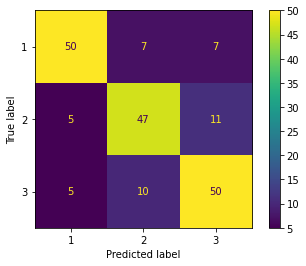


#### results for lowest loss model ####
Accuracy of: 0.7708


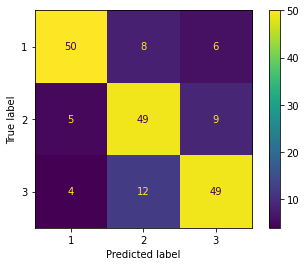


####################################################
# GRID SEARCH RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.9617 @ epoch 2377
Best training loss (min) 0.1513 @ epoch 1808

Best validation accuracy (max) 0.9167 @ epoch 2497
Best validation loss (min) 0.3088 @ epoch 1653

#### results for highest accuracy model ####
Accuracy of: 0.8906


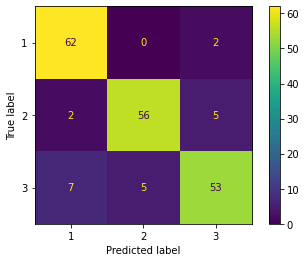


#### results for lowest loss model ####
Accuracy of: 0.8906


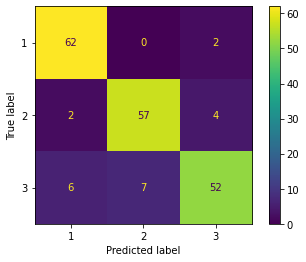


####################################################
# GRID SEARCH RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.9529 @ epoch 2186
Best training loss (min) 0.1672 @ epoch 2412

Best validation accuracy (max) 0.9215 @ epoch 1010
Best validation loss (min) 0.2724 @ epoch 981

#### results for highest accuracy model ####
Accuracy of: 0.8586


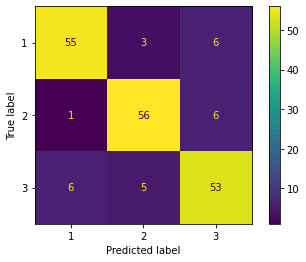


#### results for lowest loss model ####
Accuracy of: 0.8691


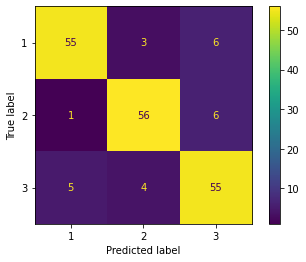

In [7]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/4/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id